# HSC - MIRA analysis 

This workbook closely follows MIRA tutorials 
https://mira-multiome.readthedocs.io/en/latest/tutorials.html


goal: 
- characterize the differences in topics in both RNA and ATAC between Healthy and Ts21
- What are the transcription factors regulating HSC priming 
- LITE modeling on the raw data


In [1]:
import mira
import optuna
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
import seaborn as sns
mira.logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.simplefilter("ignore")

umap_kwargs = dict(
    add_outline=True, outline_width=(0.1,0), outline_color=('grey', 'white'),
    legend_fontweight=350, frameon = False, legend_fontsize=12, figsize=(10,10)
)
print(mira.__version__)
mira.utils.pretty_sderr()

sc.set_figure_params(scanpy=True, dpi=200, dpi_save=300, 
                          fontsize=14, figsize=(10,10))
                  

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


1.0.4


In [4]:
#read in the raw data 
rna = anndata.read_h5ad('Single_Cell/MIRA/MIRA_input_HSCs_only.h5ad')
rna

AnnData object with n_obs × n_vars = 6215 × 36601
    obs: 'dataset', 'subclust_v6', 'sample'

In [5]:
#Note the imbalance in cell number
rna.obs['sample'].value_counts()

T21        3784
Healthy    2431
Name: sample, dtype: int64

In [6]:
#repeat the MIRA initial analysis
sc.pp.filter_genes(rna, min_cells=15)
rna.raw = rna
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

#select the endogenous versus exogenous genes
sc.pp.highly_variable_genes(rna, min_disp = 0.01)
rna.var['exog'] = rna.var.highly_variable.copy()
rna.var['endog'] = rna.var.exog & (rna.var.dispersions_norm > 0.5)
rna.layers['counts'] = rna.raw.to_adata().X.copy()

In [7]:
#load the optimized expression topic model
model = mira.topics.ExpressionTopicModel.load('Single_Cell/MIRA/RNA_topic_model_HSC_only_T21_healthy.pth')
model

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


ExpressionTopicModel(
  (decoder): Decoder(
    (beta): Linear(in_features=10, out_features=7905, bias=False)
    (bn): BatchNorm1d(7905, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
  (encoder): ExpressionEncoder(
    (fc_layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=4360, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.14010457382272842, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=22, bias=True)
        (1): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
)

In [8]:
model.predict(rna)
model.get_umap_features(rna, box_cox=0.99)

Predicting latent vars:   0%|          | 0/13 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


The parameter box_cox controls the box-cox power transformation applied to the simplical data. Passing zero or “log” gives the standard ILR transformation. Passing a float less than one gives a box-cox generalization of the ILR. Larger values generally produce more complex structures in the latent space.

<AxesSubplot:title={'center':'Expression Only'}, xlabel='UMAP1', ylabel='UMAP2'>

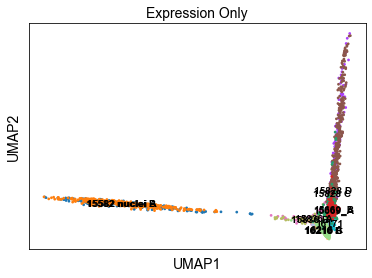

In [9]:
sc.pp.neighbors(rna, use_rep = 'X_umap_features', metric = 'manhattan', n_neighbors = 15)
sc.tl.umap(rna, min_dist = 0.1, negative_sample_rate=1)
sc.pl.umap(rna, color = ['dataset'],  legend_loc = 'on data', size = 30,
           title = 'Expression Only', show = False, na_in_legend=False)

Note the small differences in dataset batch 

2023-02-27 19:46:50,849 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2023-02-27 19:46:51,823 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2023-02-27 19:46:52,851 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2023-02-27 19:46:53,852 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2023-02-27 19:46:54,861 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2023-02-27 19:46:55,770 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2023-02-27 19:46:56,690 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2023-02-27 19:46:57,727 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2023-02-27 19:46:58,720 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2023-02-27 19:46:59,621 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2023-02-27 19:47:00,641 - harmonypy - 

<AxesSubplot:title={'center':'Expression Only'}, xlabel='UMAP1', ylabel='UMAP2'>

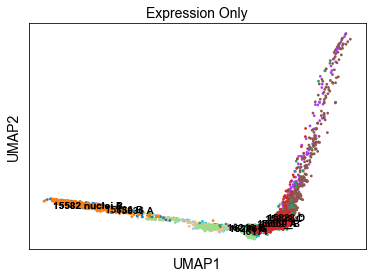

In [10]:
#treat X_umap_features (topic features) the same as X_pca 
sc.external.pp.harmony_integrate(rna, key='dataset', 
                                 basis='X_umap_features', adjusted_basis='X_umap_features_harmony')
sc.pp.neighbors(rna, use_rep = 'X_umap_features_harmony', n_neighbors = 15)
sc.tl.umap(rna, min_dist = 0.1)
sc.pl.umap(rna, color = ['dataset'],  legend_loc = 'on data', size = 30,
           title = 'Expression Only', show = False, na_in_legend=False)

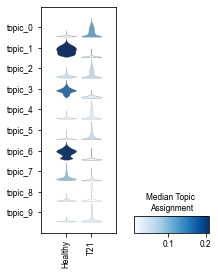

In [13]:
#there are clear differences in topic assignment between Ts21 and healthy cells
marker_genes_list = list(rna.obs.columns)
unwanted_elemnt = {'dataset', 'subclust_v6', 'sample'}
marker_genes_list = [ele for ele in marker_genes_list if ele not in unwanted_elemnt]
fig = sc.pl.stacked_violin(rna, marker_genes_list, groupby=['sample'], swap_axes=True,
                    figsize=(3,4), colorbar_title='Median Topic \nAssignment',
                    return_fig=False)

# ATAC data 

In [14]:
#read in the raw ATAC data
atac = anndata.read_h5ad('Single_Cell/MIRA/ATAC_MIRA_input_HSCs_only.h5ad')
atac

AnnData object with n_obs × n_vars = 6215 × 401340
    obs: 'dataset', 'subclust_v6', 'sample'

In [15]:
#filter 
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

#remove peaks according to episcanpy tutorial
sc.pp.filter_genes(atac, min_cells=1)
atac.var['log_counts_cells'] = [np.log10(x) for x in atac.var['n_cells_by_counts']]
subset = atac.var[atac.var['log_counts_cells']>1]
subset['peak'] = subset.index
subset_peaks = list(subset['peak'])
to_keep = atac.var_names.isin(subset_peaks)
atac = atac[:,to_keep]
atac.raw = atac

#select endog
sc.pp.normalize_total(atac, target_sum=1e4)
sc.pp.log1p(atac)

sc.pp.highly_variable_genes(atac, min_disp = 0.05)
atac.var['exog'] = atac.var.highly_variable.copy()
atac.var['endog'] = atac.var.exog & (atac.var.dispersions_norm > 0.5)
atac.layers['counts'] = atac.raw.to_adata().X.copy()

In [16]:
#read in the ATAC model 
atc_model = mira.topics.AccessibilityTopicModel.load('Single_Cell/MIRA/ATAC_topic_model_HSCs_only_T21_healthy.pth')
atc_model

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


AccessibilityTopicModel(
  (decoder): Decoder(
    (beta): Linear(in_features=11, out_features=72541, bias=False)
    (bn): BatchNorm1d(72541, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
  (encoder): DANEncoder(
    (drop): Dropout(p=0.12390677670137941, inplace=False)
    (embedding): Embedding(45096, 128, padding_idx=0)
    (fc_layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=129, out_features=22, bias=True)
        (1): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
)

Predicting latent vars:   0%|          | 0/13 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


<AxesSubplot:title={'center':'ATAC Only'}, xlabel='UMAP1', ylabel='UMAP2'>

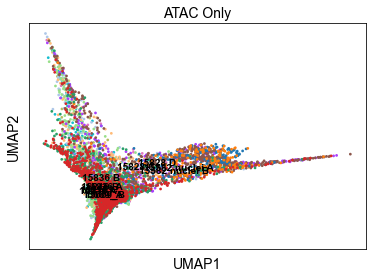

In [17]:
atc_model.predict(atac)
atc_model.get_umap_features(atac, box_cox=0.99)
sc.pp.neighbors(atac, use_rep = 'X_umap_features', metric = 'manhattan', n_neighbors = 15)
sc.tl.umap(atac, min_dist = 0.1)
sc.pl.umap(atac, color = ['dataset'],  legend_loc = 'on data', size = 30,
           title = 'ATAC Only', show = False, na_in_legend=False)


2023-02-27 19:57:44,524 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2023-02-27 19:57:45,465 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2023-02-27 19:57:46,372 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2023-02-27 19:57:47,308 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2023-02-27 19:57:48,269 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2023-02-27 19:57:49,233 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2023-02-27 19:57:50,511 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2023-02-27 19:57:51,560 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2023-02-27 19:57:52,489 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2023-02-27 19:57:53,446 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2023-02-27 19:57:54,329 - harmonypy - 

<AxesSubplot:title={'center':'ATAC Only'}, xlabel='UMAP1', ylabel='UMAP2'>

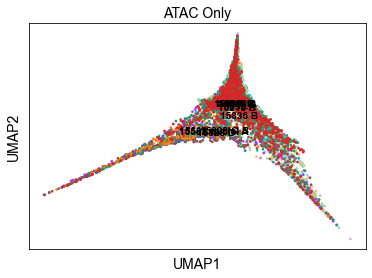

In [18]:
#treat X_umap_features the same as X_pca 
sc.external.pp.harmony_integrate(atac, key='dataset', 
                                 basis='X_umap_features', adjusted_basis='X_umap_features_harmony')

sc.pp.neighbors(atac, use_rep = 'X_umap_features_harmony', n_neighbors = 15)
sc.tl.umap(atac, min_dist = 0.1)
sc.pl.umap(atac, color = ['dataset'],  legend_loc = 'on data', size = 30,
           title = 'ATAC Only', show = False, na_in_legend=False)

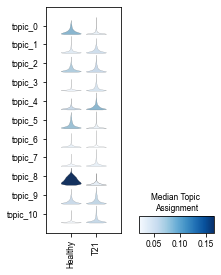

In [19]:
#there are differences in topic assignment between Ts21 and healthy cells
marker_genes_list = list(atac.obs.columns)
unwanted_elemnt = {'dataset', 'subclust_v6', 'sample','n_genes_by_counts','total_counts'}
marker_genes_list = [ele for ele in marker_genes_list if ele not in unwanted_elemnt]
fig = sc.pl.stacked_violin(atac, marker_genes_list, groupby=['sample'], swap_axes=True,
                    figsize=(3,4), colorbar_title='Median Topic \nAssignment',
                    return_fig=False)

In [20]:
#need to add the chr, start, stop into the peak identifications 
atc_index = list(atac.var.index)
chr_list = []
start_list = []
end_list = []
for peak in atc_index:
    chro,start,end = peak.split('-')
    chr_list.append(chro)
    start_list.append(start)
    end_list.append(end)
atac.var['chr']=chr_list
atac.var['start']=start_list
atac.var['end']=end_list
atac.var = atac.var.astype({"start":"int","end":"int"})
atac.var

n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
chr1-10004-10410                      139     0.023170              97.763475   
chr1-16122-16321                       80     0.012872              98.712792   
chr1-115521-115786                     14     0.002414              99.774739   
chr1-180534-181623                    579     0.109091              90.683829   
chr1-184192-184392                     19     0.003218              99.694288   
...                                   ...          ...                    ...   
chrY-56839824-56840028                 19     0.003057              99.694288   
chrY-56843657-56843952                 37     0.006114              99.404666   
chrY-56849420-56849638                 28     0.004505              99.549477   
chrY-56850346-56851112                 81     0.013998              98.696702   
chrY-56870799-56870998                 27     0.004344              99.565567   

                        total_counts  n_cells  log_counts_cells  \
chr1-10004-10410               144.0      139          2.143015   
chr1-16122-16321                80.0       80          1.903090   
chr1-115521-115786              15.0       14          1.146128   
chr1-180534-181623             678.0      579          2.762679   
chr1-184192-184392              20.0       19          1.278754   
...                              ...      ...               ...   
chrY-56839824-56840028          19.0       19          1.278754   
chrY-56843657-56843952          38.0       37          1.568202   
chrY-56849420-56849638          28.0       28          1.447158   
chrY-56850346-56851112          87.0       81          1.908485   
chrY-56870799-56870998          27.0       27          1.431364   

                        highly_variable     means  dispersions  \
chr1-10004-10410                  False  0.008983    -0.344138   
chr1-16122-16321                  False  0.006536    -0.064107   
chr1-115521-115786                False  0.000662    -0.438185   
chr1-180534-181623                 True  0.047050    -0.023361   
chr1-184192-184392                False  0.001234    -0.551472   
...                                 ...       ...          ...   
chrY-56839824-56840028            False  0.001169    -0.032832   
chrY-56843657-56843952            False  0.001899    -0.532010   
chrY-56849420-56849638            False  0.001933    -0.203291   
chrY-56850346-56851112            False  0.005675     0.081645   
chrY-56870799-56870998            False  0.001906    -0.304607   

                        dispersions_norm   exog  endog   chr     start  \
chr1-10004-10410               -0.562308  False  False  chr1     10004   
chr1-16122-16321                0.002611  False  False  chr1     16122   
chr1-115521-115786             -0.752033  False  False  chr1    115521   
chr1-180534-181623              0.084809   True  False  chr1    180534   
chr1-184192-184392             -0.980572  False  False  chr1    184192   
...                                  ...    ...    ...   ...       ...   
chrY-56839824-56840028          0.065703  False  False  chrY  56839824   
chrY-56843657-56843952         -0.941310  False  False  chrY  56843657   
chrY-56849420-56849638         -0.278172  False  False  chrY  56849420   
chrY-56850346-56851112          0.296643  False  False  chrY  56850346   
chrY-56870799-56870998         -0.482561  False  False  chrY  56870799   

                             end  
chr1-10004-10410           10410  
chr1-16122-16321           16321  
chr1-115521-115786        115786  
chr1-180534-181623        181623  
chr1-184192-184392        184392  
...                          ...  
chrY-56839824-56840028  56840028  
chrY-56843657-56843952  56843952  
chrY-56849420-56849638  56849638  
chrY-56850346-56851112  56851112  
chrY-56870799-56870998  56870998  

[388540 rows x 15 columns]

In [91]:
#Now, use the function mira.tl.get_motif_hits_in_peaks, which will scan the sequence of each peak 
#against the JASPAR 2020 vertabrates collection of motifs.
mira.tools.motif_scan.logger.setLevel(logging.INFO) 
mira.tl.get_motif_hits_in_peaks(atac,
                    genome_fasta='hg38.fa',
                    chrom = 'chr', start = 'start', end = 'end') 

INFO:mira.tools.motif_scan:Getting peak sequences ...
388540it [00:27, 14384.41it/s]
INFO:mira.tools.motif_scan:Scanning peaks for motif hits with p >= 0.0001 ...
INFO:mira.tools.motif_scan:Building motif background models ...
INFO:mira.tools.motif_scan:Starting scan ...
INFO:mira.tools.motif_scan:Found 1000000 motif hits ...
INFO:mira.tools.motif_scan:Found 2000000 motif hits ...
INFO:mira.tools.motif_scan:Found 3000000 motif hits ...
INFO:mira.tools.motif_scan:Found 4000000 motif hits ...
INFO:mira.tools.motif_scan:Found 5000000 motif hits ...
INFO:mira.tools.motif_scan:Found 6000000 motif hits ...
INFO:mira.tools.motif_scan:Found 7000000 motif hits ...
INFO:mira.tools.motif_scan:Found 8000000 motif hits ...
INFO:mira.tools.motif_scan:Found 9000000 motif hits ...
INFO:mira.tools.motif_scan:Found 10000000 motif hits ...
INFO:mira.tools.motif_scan:Found 11000000 motif hits ...
INFO:mira.tools.motif_scan:Found 12000000 motif hits ...
INFO:mira.tools.motif_scan:Found 13000000 motif hits 

In [93]:
#save to use later in analysis 
atac.write('Single_cell/ATAC_HSCs.TF_motif_hits.h5ad')

... storing 'chr' as categorical


# Joint RNA + ATAC

Now, let’s combine the modailities. We can construct the joint embedding space using mira.utils.make_joint_representation. This function takes the two modalities’ AnnDatas as input, then finds common cells, joins the separate transformed topic spaces to make the joint embedding for each cell, and returns those AnnDatas.



In [21]:
rna, atac = mira.utils.make_joint_representation(rna, atac)
rna.uns['sample_colors']= np.array(['#7FB685', '#EF6F6C'], dtype=object)
rna

INFO:mira.adata_interface.utils:6215 out of 6215 cells shared between datasets (100%).
INFO:mira.adata_interface.utils:Key added to obsm: X_joint_umap_features


AnnData object with n_obs × n_vars = 6215 × 20880
    obs: 'dataset', 'subclust_v6', 'sample', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog'
    uns: 'log1p', 'hvg', 'topic_dendogram', 'neighbors', 'umap', 'dataset_colors', 'sample_colors'
    obsm: 'X_topic_compositions', 'X_umap_features', 'X_umap', 'X_umap_features_harmony', 'X_joint_umap_features'
    varm: 'topic_feature_compositions', 'topic_feature_activations'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

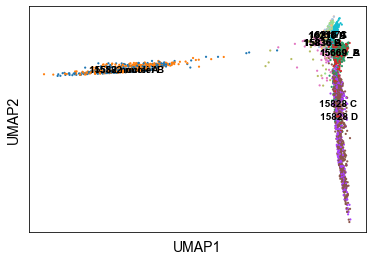

In [22]:
sc.pp.neighbors(rna, use_rep = 'X_joint_umap_features',
               n_neighbors = 15)
sc.tl.umap(rna, min_dist = 0.1)
sc.pl.umap(rna, color = 'dataset', legend_loc = 'on data', 
           title = '')

2023-02-27 20:48:19,374 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2023-02-27 20:48:20,279 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2023-02-27 20:48:21,250 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2023-02-27 20:48:22,193 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2023-02-27 20:48:23,127 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2023-02-27 20:48:24,085 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2023-02-27 20:48:25,036 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2023-02-27 20:48:25,936 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations


<AxesSubplot:title={'center':'ATAC+RNA'}, xlabel='UMAP1', ylabel='UMAP2'>

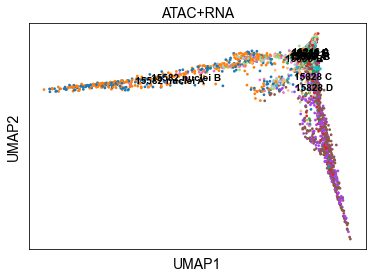

In [23]:
#since they are seperating by dataset, need to batch correct
#treat X_umap_features the same as X_pca 
sc.external.pp.harmony_integrate(rna, key='dataset', 
                                 basis='X_joint_umap_features', adjusted_basis='X_joint_umap_features_harmony')

sc.pp.neighbors(rna, use_rep = 'X_joint_umap_features_harmony', n_neighbors = 15)
sc.tl.umap(rna, min_dist = 0.1)
sc.pl.umap(rna, color = ['dataset'],  legend_loc = 'on data', size = 30,
           title = 'ATAC+RNA', show = False, na_in_legend=False)

In [25]:
#After joining the AnnDatas, it is useful to transfer some metadata from the ATAC dataframe to the RNA dataframe 
#so that we have one main object for plotting and running other functions:
rna.obs = rna.obs.join(
    atac.obs.add_prefix('ATAC_') 
)

atac.obsm['X_umap'] = rna.obsm['X_umap']

In [26]:
mira.tl.get_cell_pointwise_mutual_information(rna, atac)
mira.tl.summarize_mutual_information(rna, atac)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added cols to obs: pointwise_mutual_information
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


0.09120377

Usually, more stable cell states, such as terminal cell states, will have greater concordance between topic compositions.

the higher the value the more similar the topics are 

To summarize mutual information across all cells, use mira.tl.summarize_mutual_information. 

Typically, this will give a value between 0 -low concordance- and 0.5 -high concordance.

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


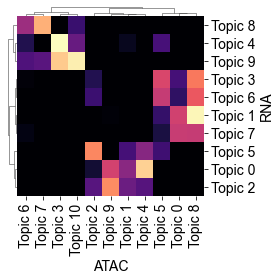

In [27]:
#this is the similarity of the combined data including both Ts21 and healthy cells
cross_correlation = mira.tl.get_topic_cross_correlation(rna, atac)
sns.clustermap(cross_correlation, vmin = 0,
               cmap = 'magma', method='ward',
               dendrogram_ratio=0.05, cbar_pos=None, figsize=(4,4))

Text(0.5, 0, '')

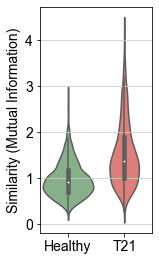

In [28]:
#plot the pointwise mutual information differences between healthy and disease 
#there is a clear different in the similarity of the two groups
import pandas as pd
df_joint = pd.DataFrame(rna.obs)
plt.figure(figsize=(2,4))
ax = sns.violinplot(data=df_joint, y="pointwise_mutual_information", x="sample", width=0.9,
              palette=['#7FB685', '#EF6F6C'], )
plt.ylabel('Similarity (Mutual Information)')
plt.xlabel("")


<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

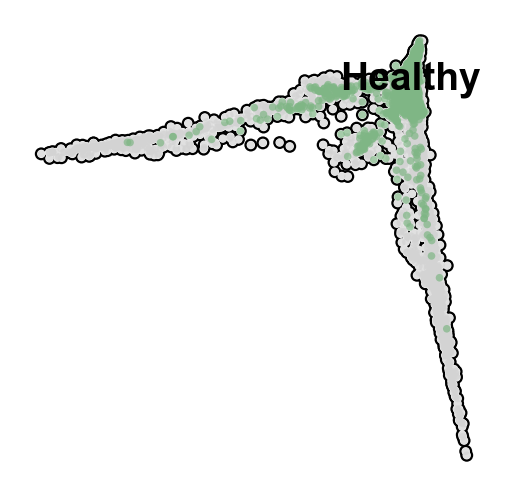

In [63]:
sc.set_figure_params(figsize=(3,3), dpi=200)
sc.pl.umap(embed, color = ['sample'], groups='Healthy', legend_loc = 'on data', size = 30,
           title = '', show = False, na_in_legend=False,frameon=False, add_outline=True)

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

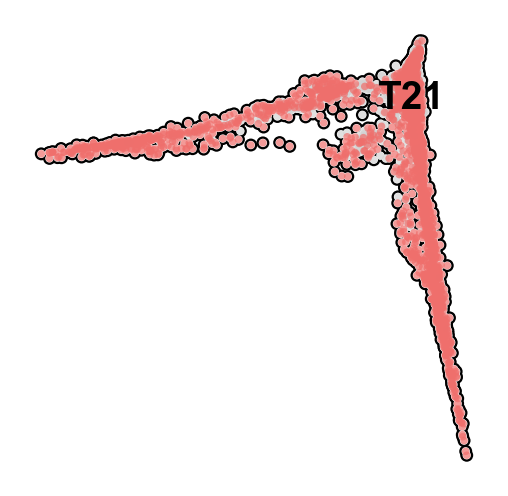

In [64]:
sc.set_figure_params(figsize=(3,3), dpi=200)
sc.pl.umap(embed, color = ['sample'], groups='T21', legend_loc = 'on data', size = 30,
           title = '', show = False, na_in_legend=False,frameon=False, add_outline=True)

Notice that the Ts21 and Healthy phsyically map to different locations within the joint embedding

# Compare similarity between healthy and T21

now that they are jointly represented, lets seperate according to Ts21 and Healthy in order to visualize any differences

note: this is strictly for observational purposes

In [29]:
#Ts21
rna_t21 = rna[rna.obs['sample']=='T21']
atac_t21 = atac[atac.obs['sample']=='T21']

mira.tl.get_cell_pointwise_mutual_information(rna_t21, atac_t21)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added cols to obs: pointwise_mutual_information


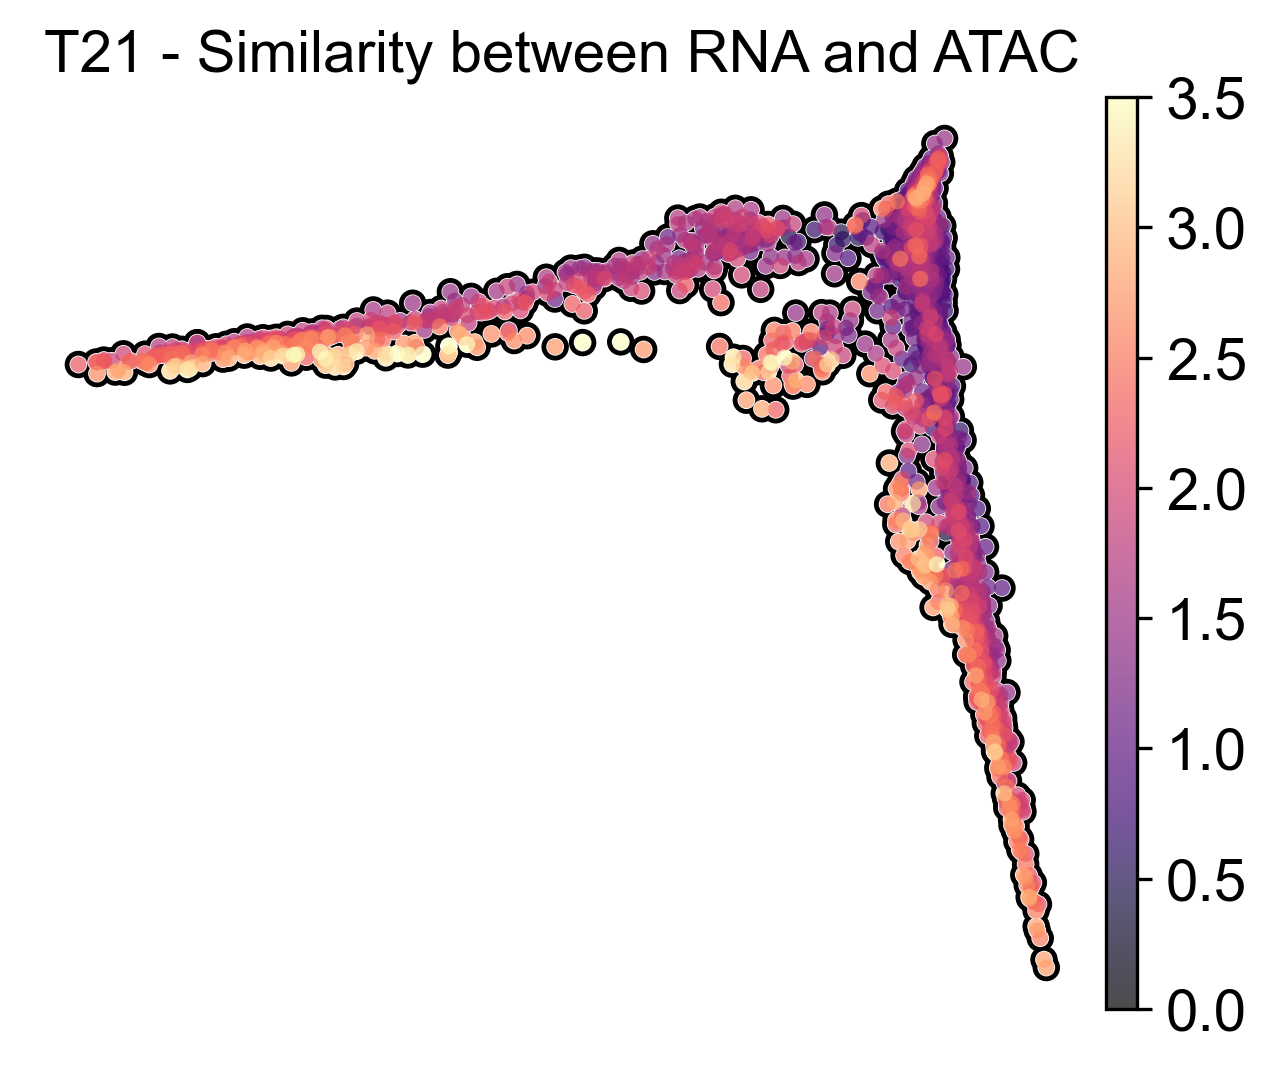

In [31]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
sc.set_figure_params(dpi=300)
sc.pl.umap(rna_t21, color = 'pointwise_mutual_information', ax = ax, vmin = 0,
           title='T21 - Similarity between RNA and ATAC',
          color_map='magma', frameon=False, add_outline=True, vmax = 3.5, size = 60)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


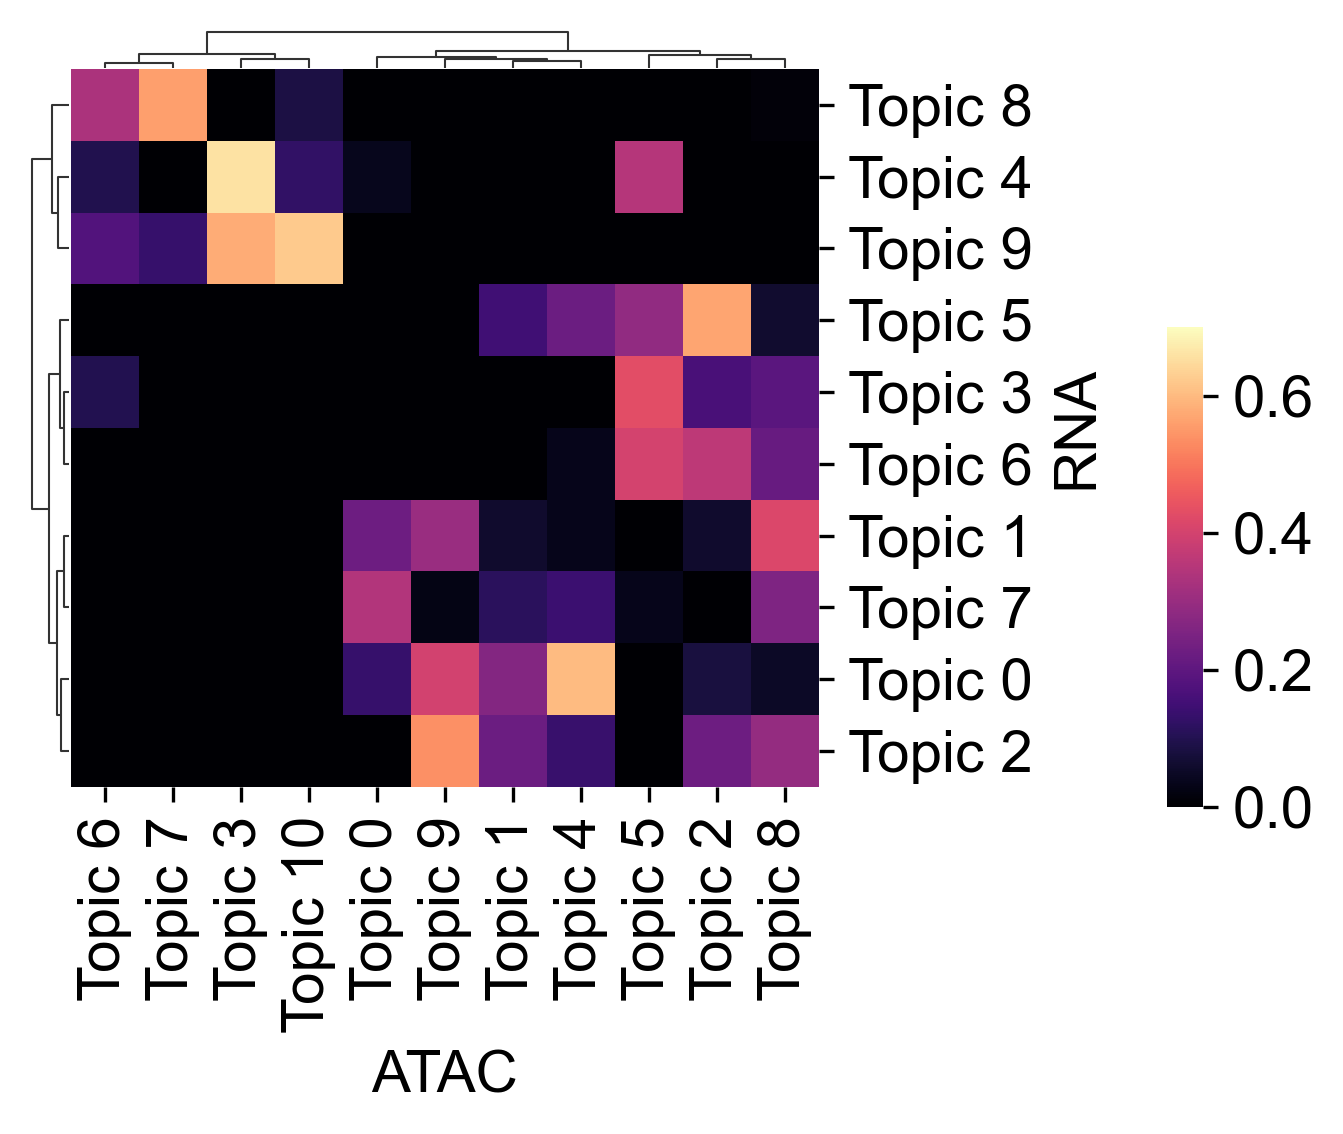

In [32]:
mira.tl.summarize_mutual_information(rna_t21, atac_t21)
cross_correlation_t21 = mira.tl.get_topic_cross_correlation(rna_t21, atac_t21)
sns.clustermap(cross_correlation_t21,vmin = 0,vmax=0.7,
               cmap = 'magma', method='ward',cbar_pos=(1, .3, .03, .4),
               dendrogram_ratio=0.05, figsize=(4,4))

In [33]:
#Healthy 
rna_healthy = rna[rna.obs['sample']=='Healthy']
atac_healthy = atac[atac.obs['sample']=='Healthy']

mira.tl.get_cell_pointwise_mutual_information(rna_healthy, atac_healthy)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added cols to obs: pointwise_mutual_information


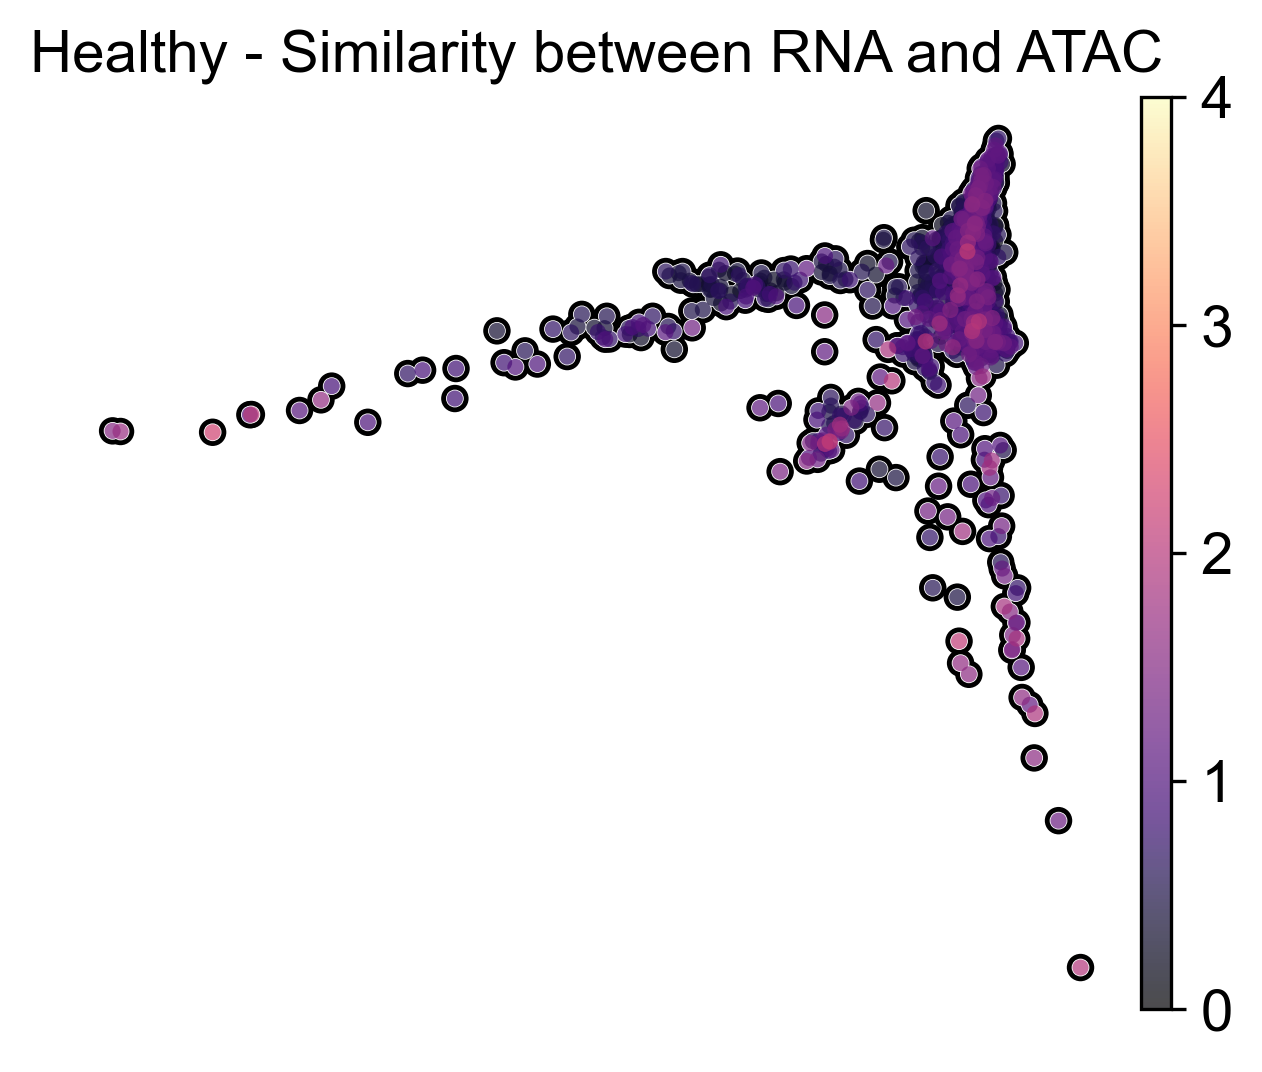

In [34]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
sc.set_figure_params(dpi=300)
sc.pl.umap(rna_healthy, color = 'pointwise_mutual_information', ax = ax, vmin = 0,
           title='Healthy - Similarity between RNA and ATAC',
          color_map='magma', frameon=False, add_outline=True, vmax = 4, size = 60)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


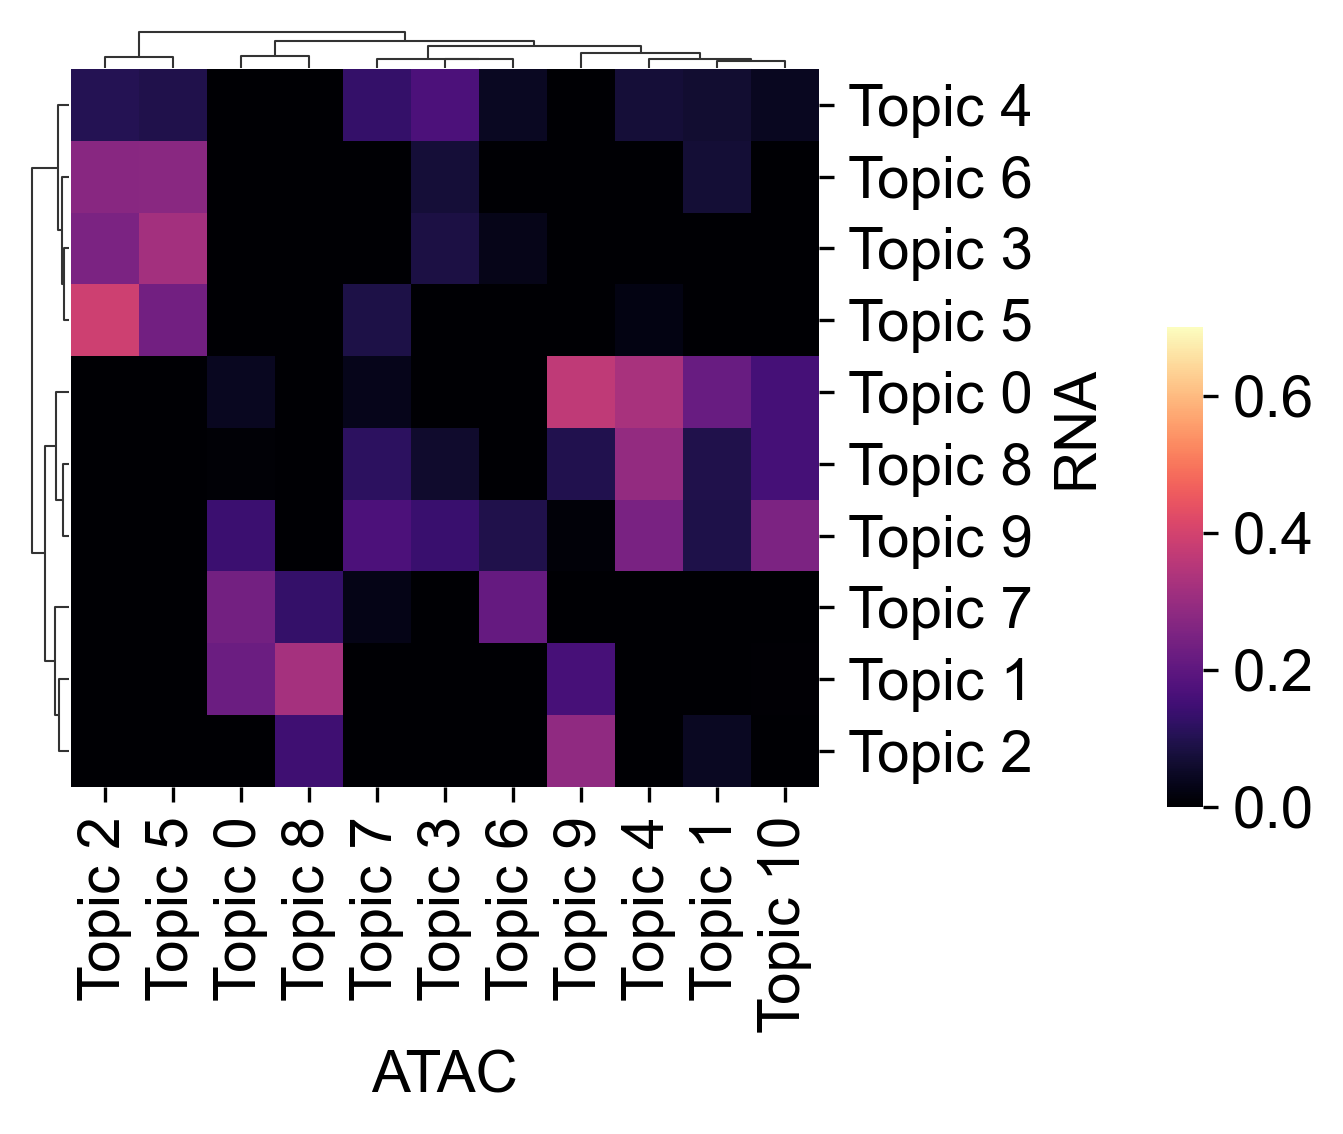

In [35]:
mira.tl.summarize_mutual_information(rna_healthy, atac_healthy)
cross_correlation_healthy = mira.tl.get_topic_cross_correlation(rna_healthy, atac_healthy)
sns.clustermap(cross_correlation_healthy, vmin = 0, vmax=0.7,
               cmap = 'magma', method='ward',cbar_pos=(1, .3, .03, .4),
               dendrogram_ratio=0.05, figsize=(4,4))

The RNA and ATAC topics are more similar in healthy HSCs than in Ts21 HSCs

# Calculate Pseudotime from the Joint Modalities

In [200]:
#First, calculate the diffusion map, then use mira.time.normalize_diffmap to rescale the components of the diffusion map. 
#This regularizes distortions in magnitude of the eigenvectors.
sc.tl.diffmap(data)
mira.time.normalize_diffmap(data)

INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 14 components.
INFO:root:Added key to uns: eigen_gap


Recommending 3 diffusion map components.


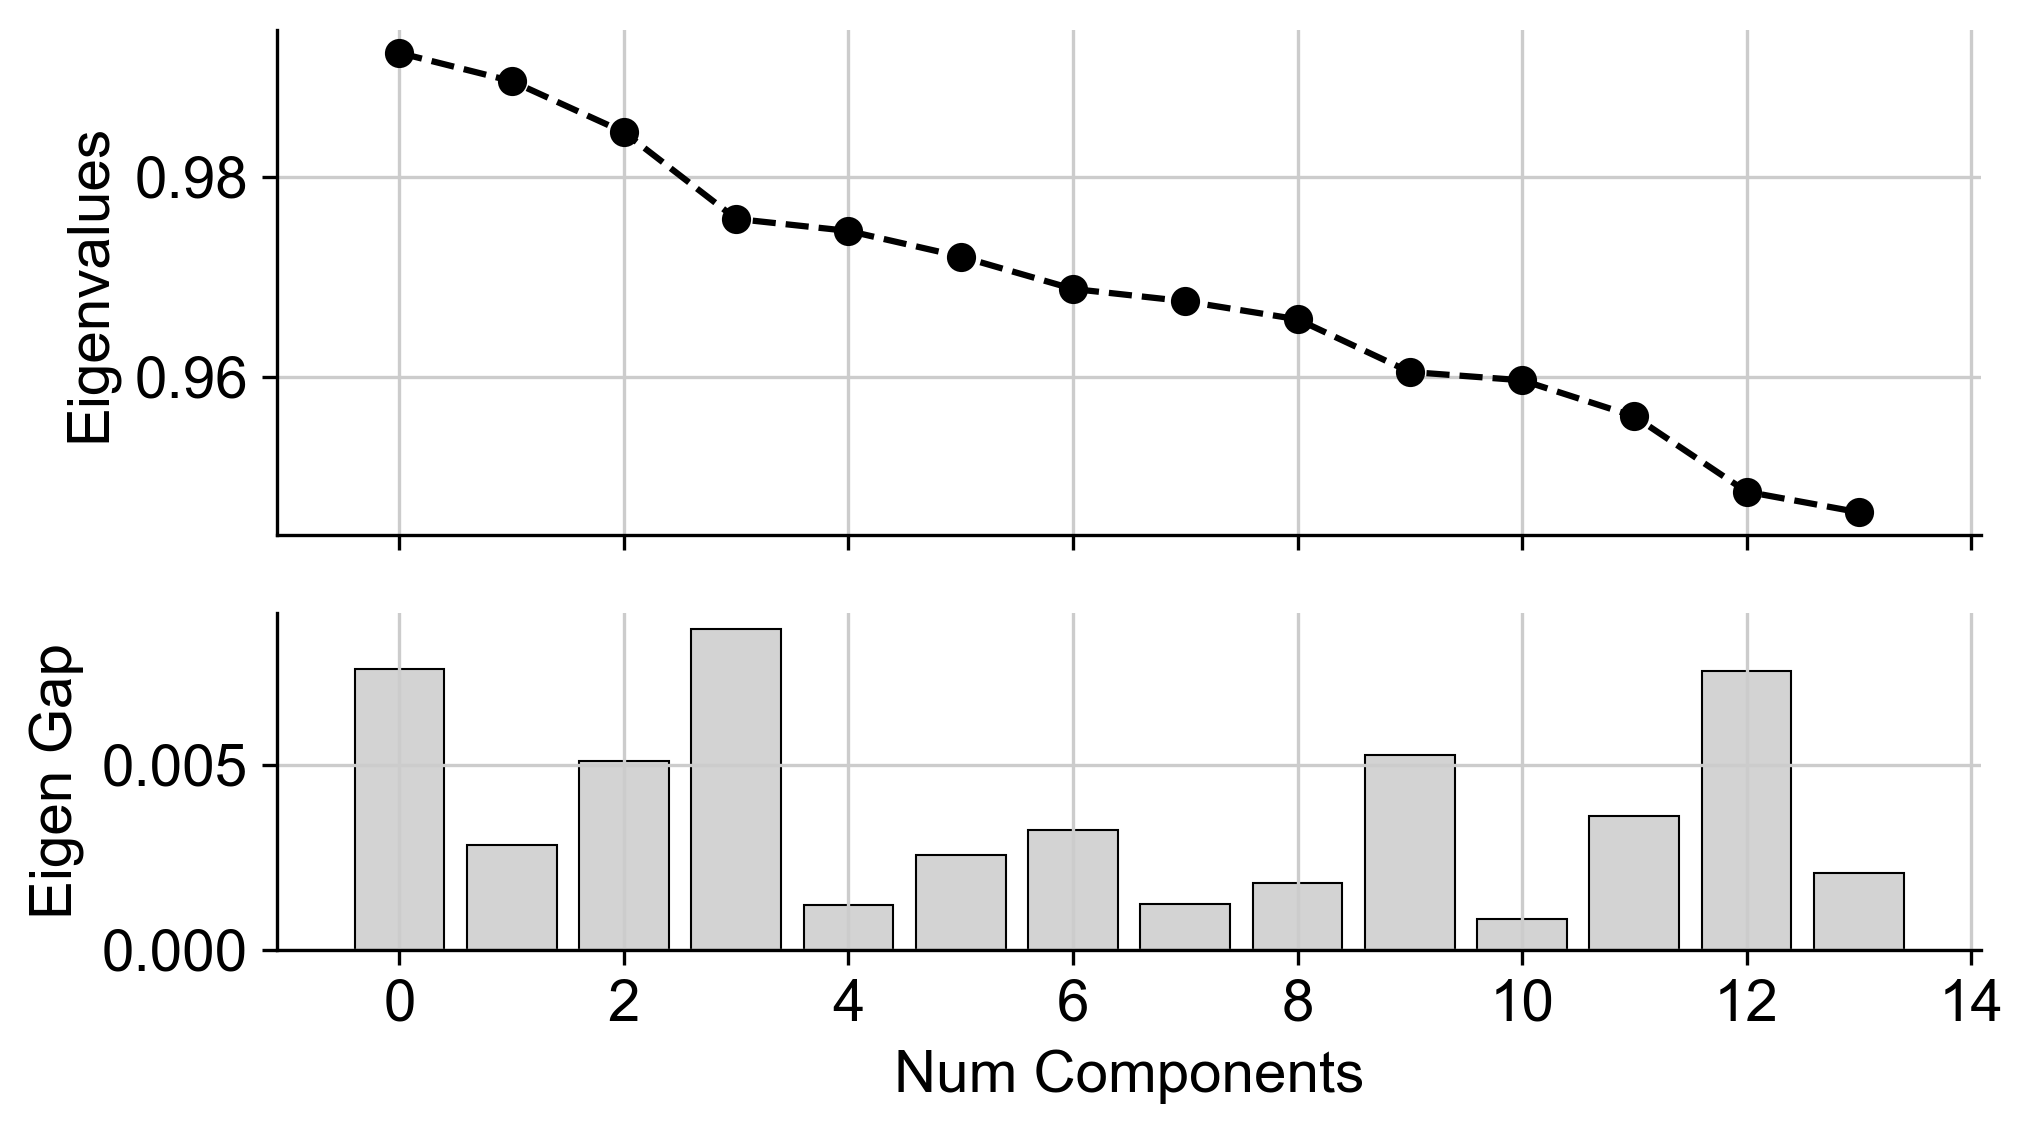

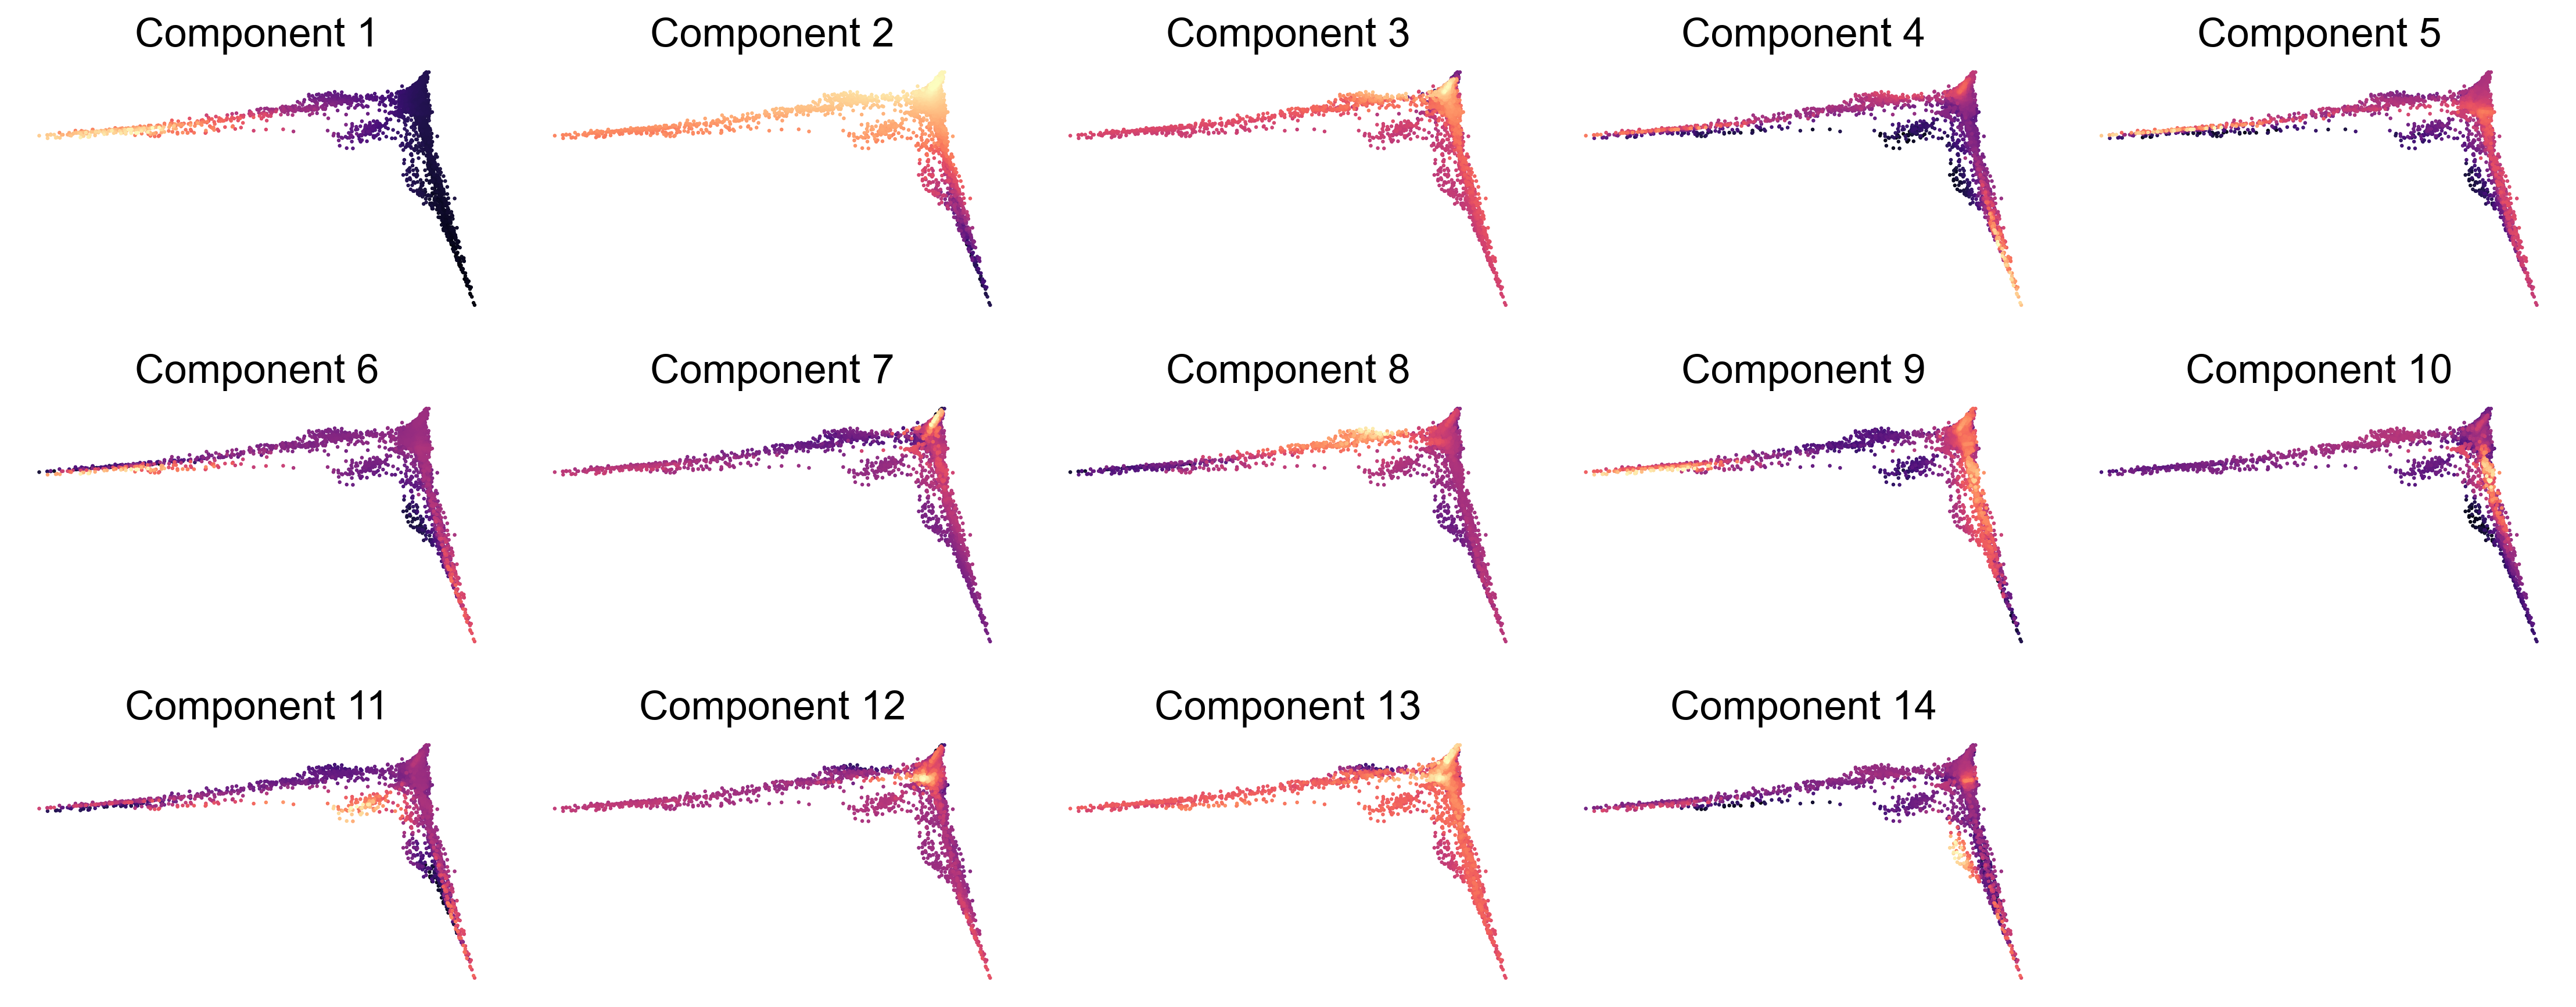

In [201]:
mira.pl.plot_eigengap(data, palette='magma')
plt.show()

The component with the highest Eigengap is an estimate of the best number of components to represent the data, but may not capture all relevent structure. For this reason, we also plot the diffusion components projected over the UMAP, with which we can check how many components are needed to capture differences between cell types.

In [202]:
#The eigengap is the biggest after the first 3 components, so we will use the first 3 components for the diffusion map
data.obsm['X_diffmap'] = data.obsm['X_diffmap'][:,:3] 
sc.pp.neighbors(data, use_rep='X_diffmap', key_added='X_diffmap')


In [203]:
#the components have to be connected for the next layers to work
mira.time.get_connected_components(data)

INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components


Now, we can assign cells a pseudotime and define a transport map describing a markov chain model of forward differentiation using mira.time.get_transport_map. This function requires we define a start cell, which must be chosen using knowledge of the system.

In [210]:
#going to use the minimum diffusion cell of the 3rd compoent as the root
#This function calculates the transport map and assigns cells a pseudotime based on their shortest-path distance from the start cell
mira.time.get_transport_map(data, start_cell= int(data.obsm['X_diffmap'][:,2].argmax()))

INFO:mira.pseudotime.pseudotime:Calculating inter-cell distances ...
INFO:root:Using 1 core. Speed this up by allocating more n_jobs.


Calculating pseudotime:   0%|          | 0/62000 [00:00<?, ?it/s]

INFO:mira.pseudotime.pseudotime:Calculating transport map ...
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added key to obsp: transport_map
INFO:mira.adata_interface.pseudotime:Added key to uns: start_cell


<AxesSubplot:title={'center':'mira_pseudotime'}, xlabel='UMAP1', ylabel='UMAP2'>

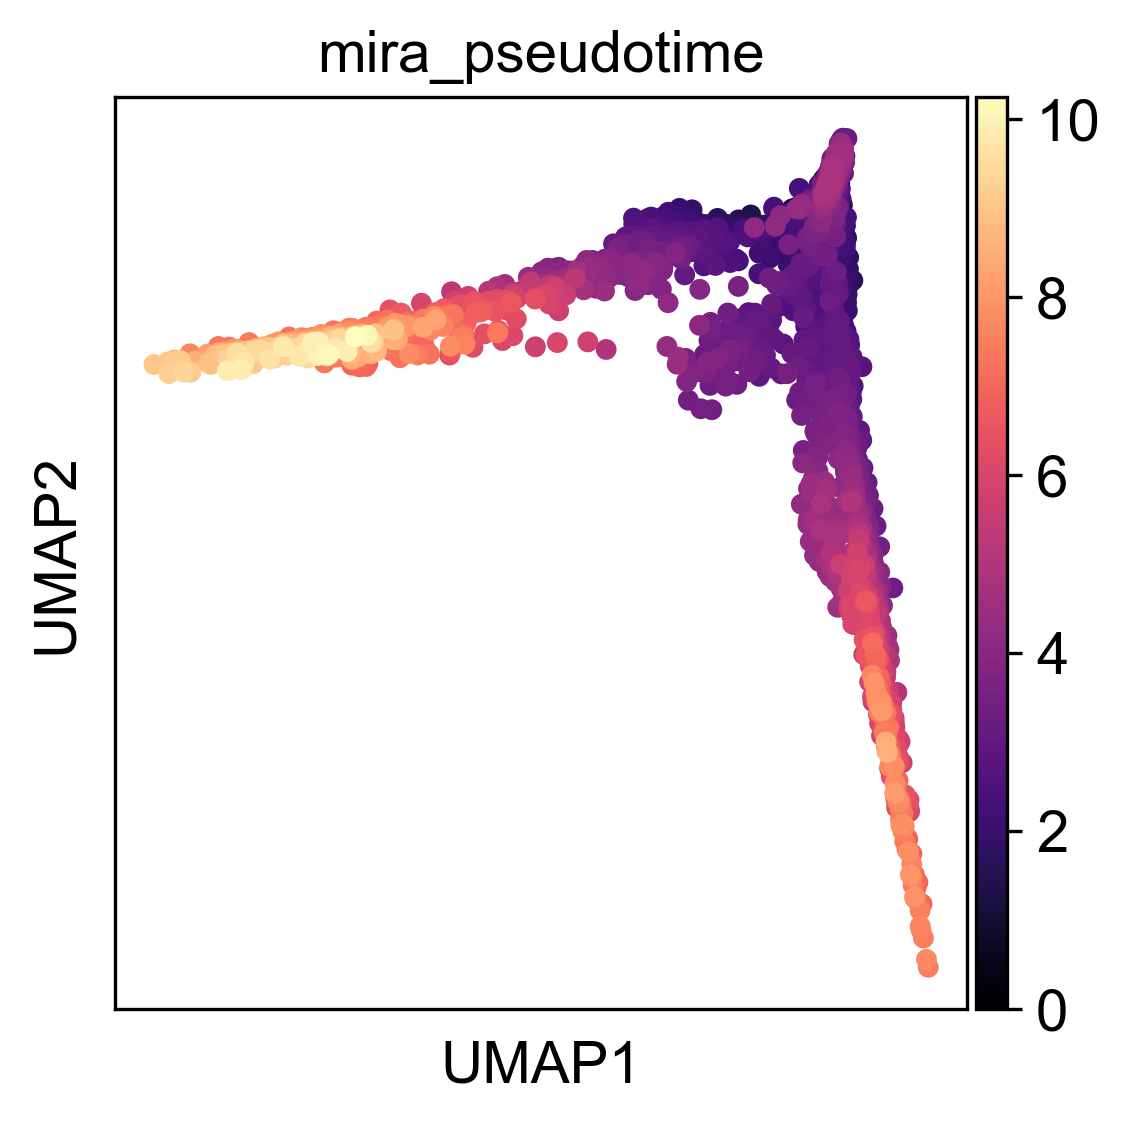

In [211]:
sc.pl.umap(data, color = 'mira_pseudotime', show = False,
          color_map = 'magma', size=100)

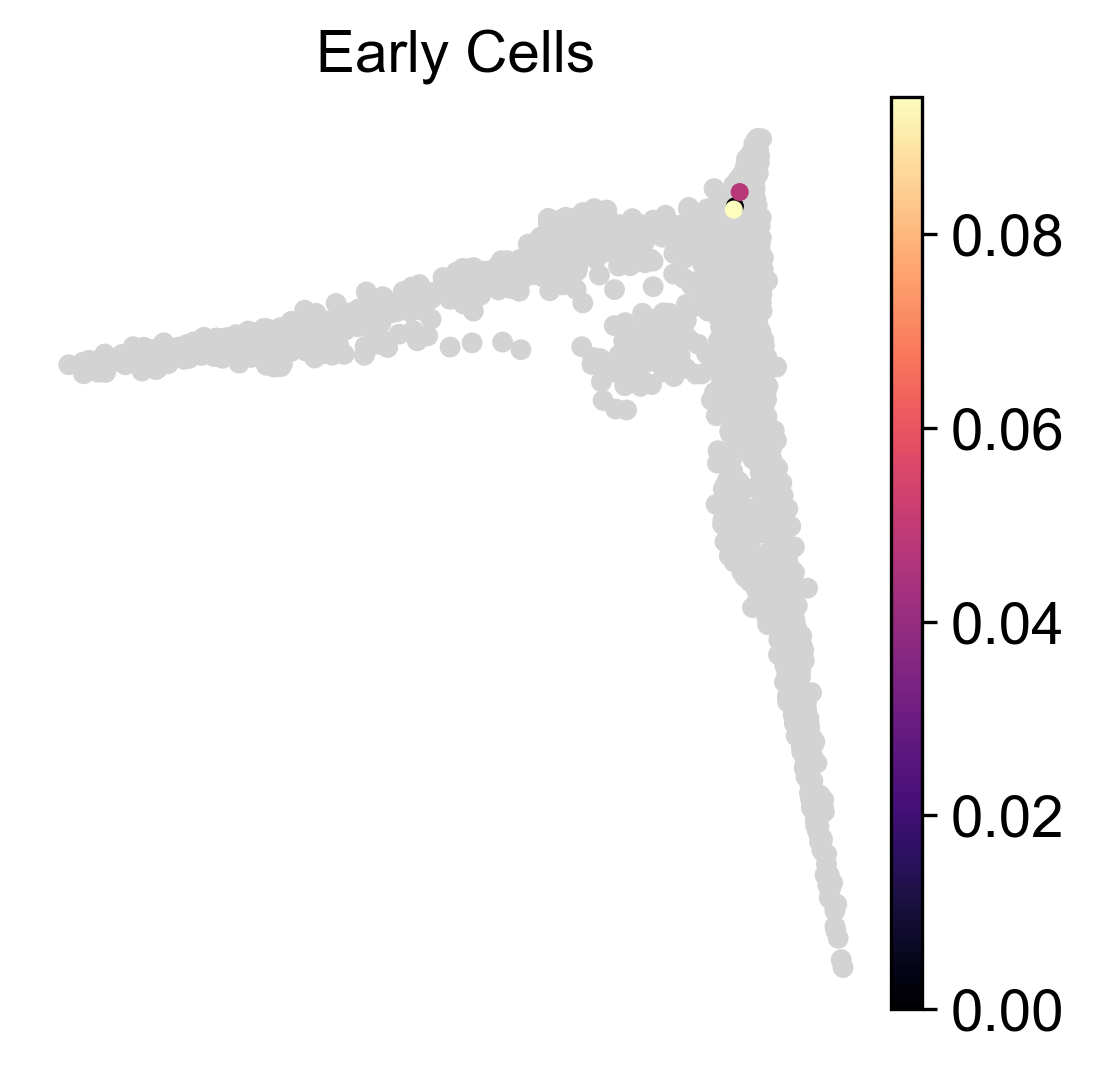

In [320]:
ax = sc.pl.umap(data, size=100, show=False)
sc.pl.umap(
    data[data.obs['mira_pseudotime']<0.1],
    size=75,
    color = ['mira_pseudotime'],
    title='Early Cells',
    ax=ax,
    frameon=False, color_map='magma', 
)

INFO:mira.pseudotime.pseudotime:Found 9 terminal states from stationary distribution.


Terminal cells:  ACTTATGAGGTCAAAG-1_2-1, TTACGTTTCATGCTTT-1_4-0, AGGTTAGAGGAAGCAC-1_3-0, GATGGCTGTCATAAGT-1_5-0, AATAACCGTGCAATAT-1_6-0, CGTTAGTAGGAGCAAC-1_3-0, TAGCTAATCGTAATCA-1_6-1, GGCCAACTCGGTCAAT-1_4-1, GTTTAGCAGATAACCC-1_2-0


INFO:mira.pseudotime.pseudotime:Found 12 terminal states from stationary distribution.


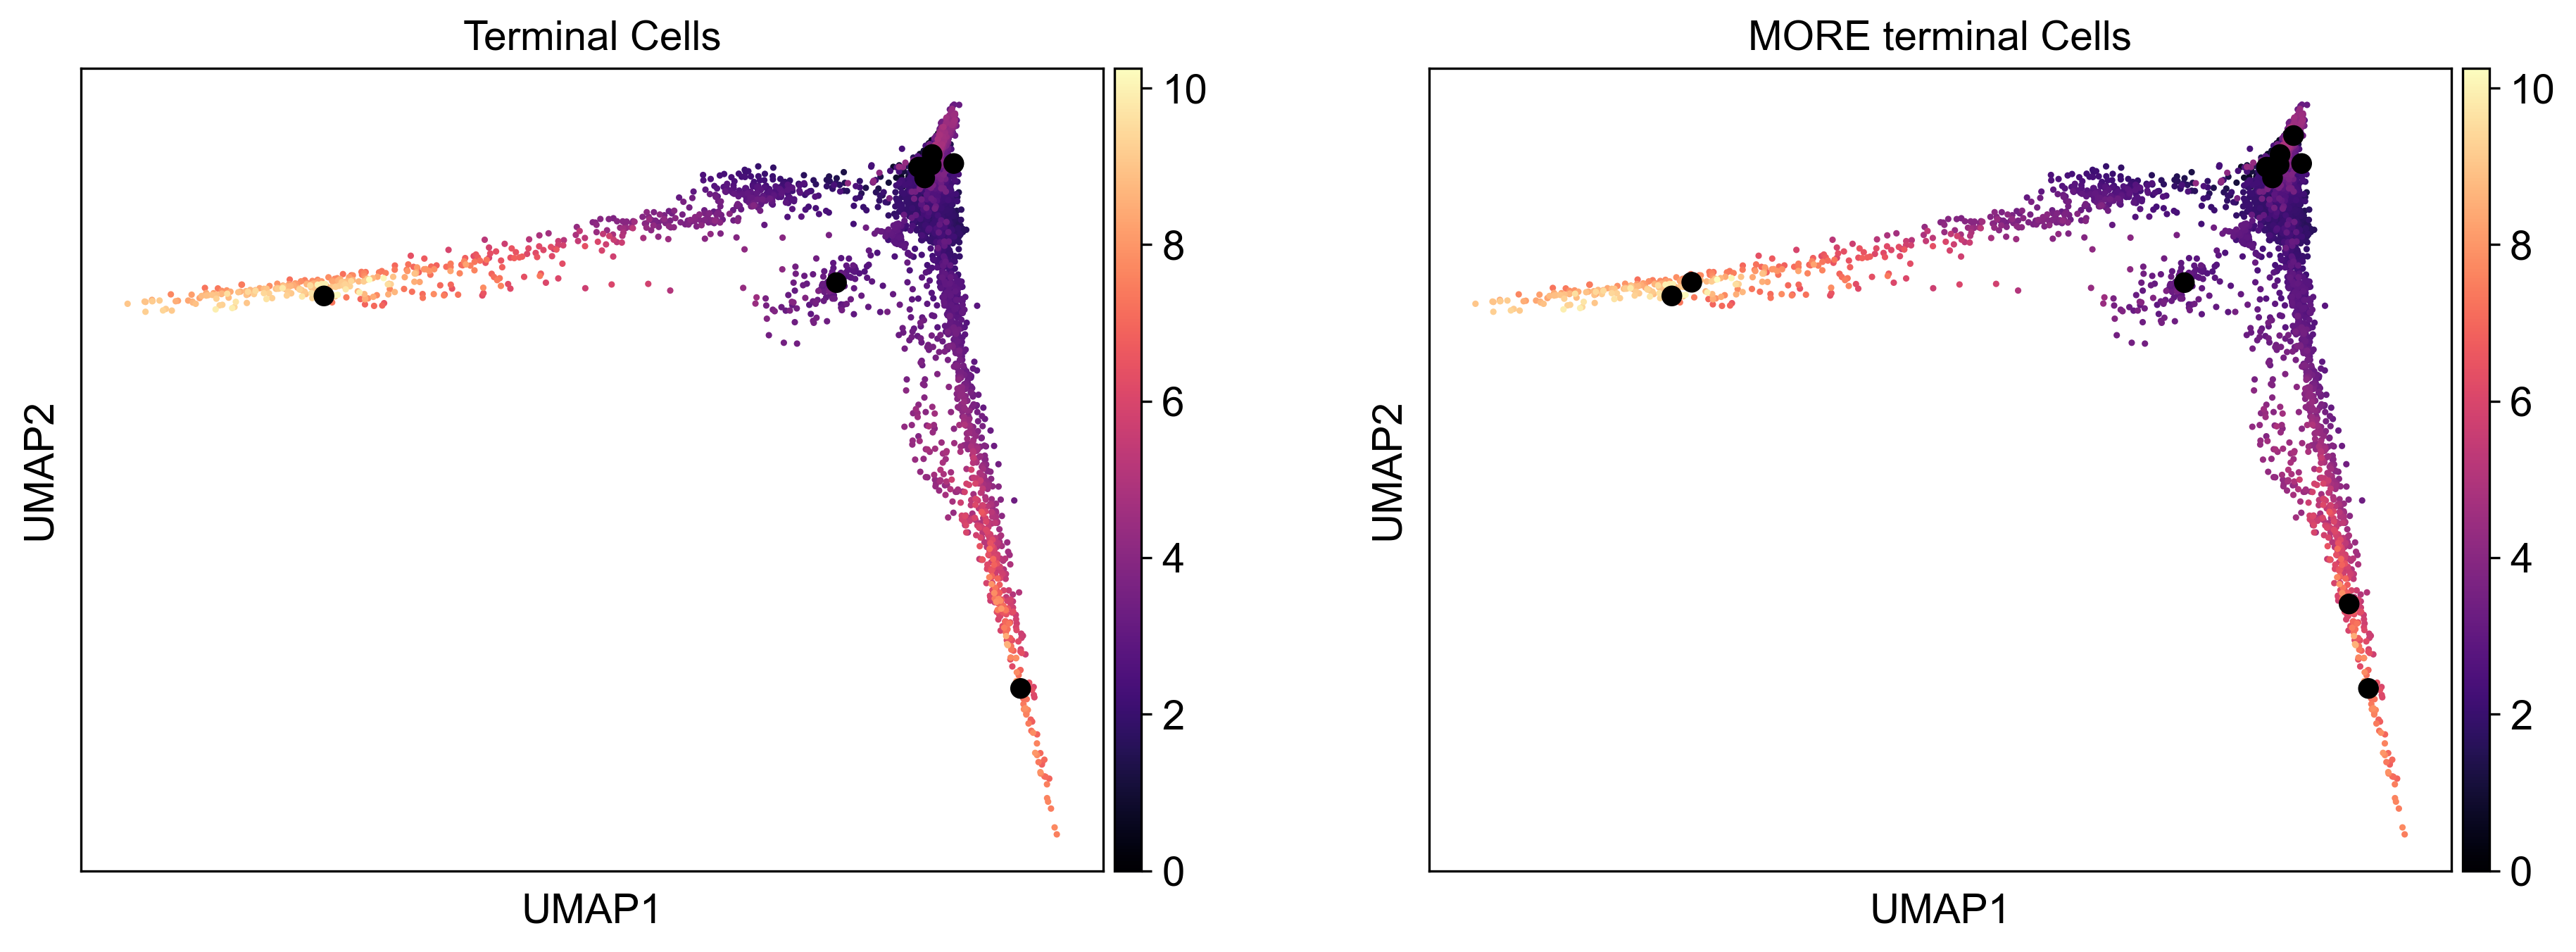

In [213]:
#From the transport map, we may find terminal states where the markov chain reaches a steady state. 
#mira.time.find_terminal_cells outputs cells that appear to be at the termini of lineages.
terminal_cells = mira.time.find_terminal_cells(data, seed = 3, threshold=1e-3, iterations = 6)
print('Terminal cells: ', ', '.join(terminal_cells))
MORE_terminal_cells = mira.time.find_terminal_cells(data, seed = 3, iterations = 8, threshold=1e-2)

#Increase the iterations parameter, or increase the treshold parameter (e.g. 1e-3 to 1e-2) to find more terminal cell candidates
fig, ax = plt.subplots(1,2,figsize=(15,5))
sc.pl.umap(data, color = 'mira_pseudotime', show = False,
            color_map = 'magma', ax = ax[0])
sc.pl.umap(data[terminal_cells], na_color = 'black', ax = ax[0],
          size = 200, title = 'Terminal Cells', show=False)

sc.pl.umap(data, color = 'mira_pseudotime', show = False,
           color_map = 'magma', ax = ax[1])
sc.pl.umap(data[MORE_terminal_cells], na_color = 'black', ax = ax[1],
           size = 200, title = 'MORE terminal Cells')

Note that the cells selected will slightly alter the branch probabilities

This would be something to improve the software and analysis in the future. An automatic selection of the cells that are the termini of the lineages

In [214]:
#select the cells at most terminal locations of 3 branches
mira.time.get_branch_probabilities(data, terminal_cells= {
    'Lineage_1' : 'AGGTTAGAGGAAGCAC-1_3-0',
    'Lineage_2' : 'ACTTATGAGGTCAAAG-1_2-1',
    'Lineage_3' : 'GGCCAACTCGGTCAAT-1_4-1'
})

INFO:mira.pseudotime.pseudotime:Simulating random walks ...
INFO:mira.adata_interface.pseudotime:Added key to obsm: branch_probs
INFO:mira.adata_interface.pseudotime:Added key to uns: lineage_names
INFO:mira.adata_interface.core:Added cols to obs: Lineage_1_prob
INFO:mira.adata_interface.core:Added cols to obs: Lineage_2_prob
INFO:mira.adata_interface.core:Added cols to obs: Lineage_3_prob
INFO:mira.adata_interface.core:Added cols to obs: differentiation_entropy


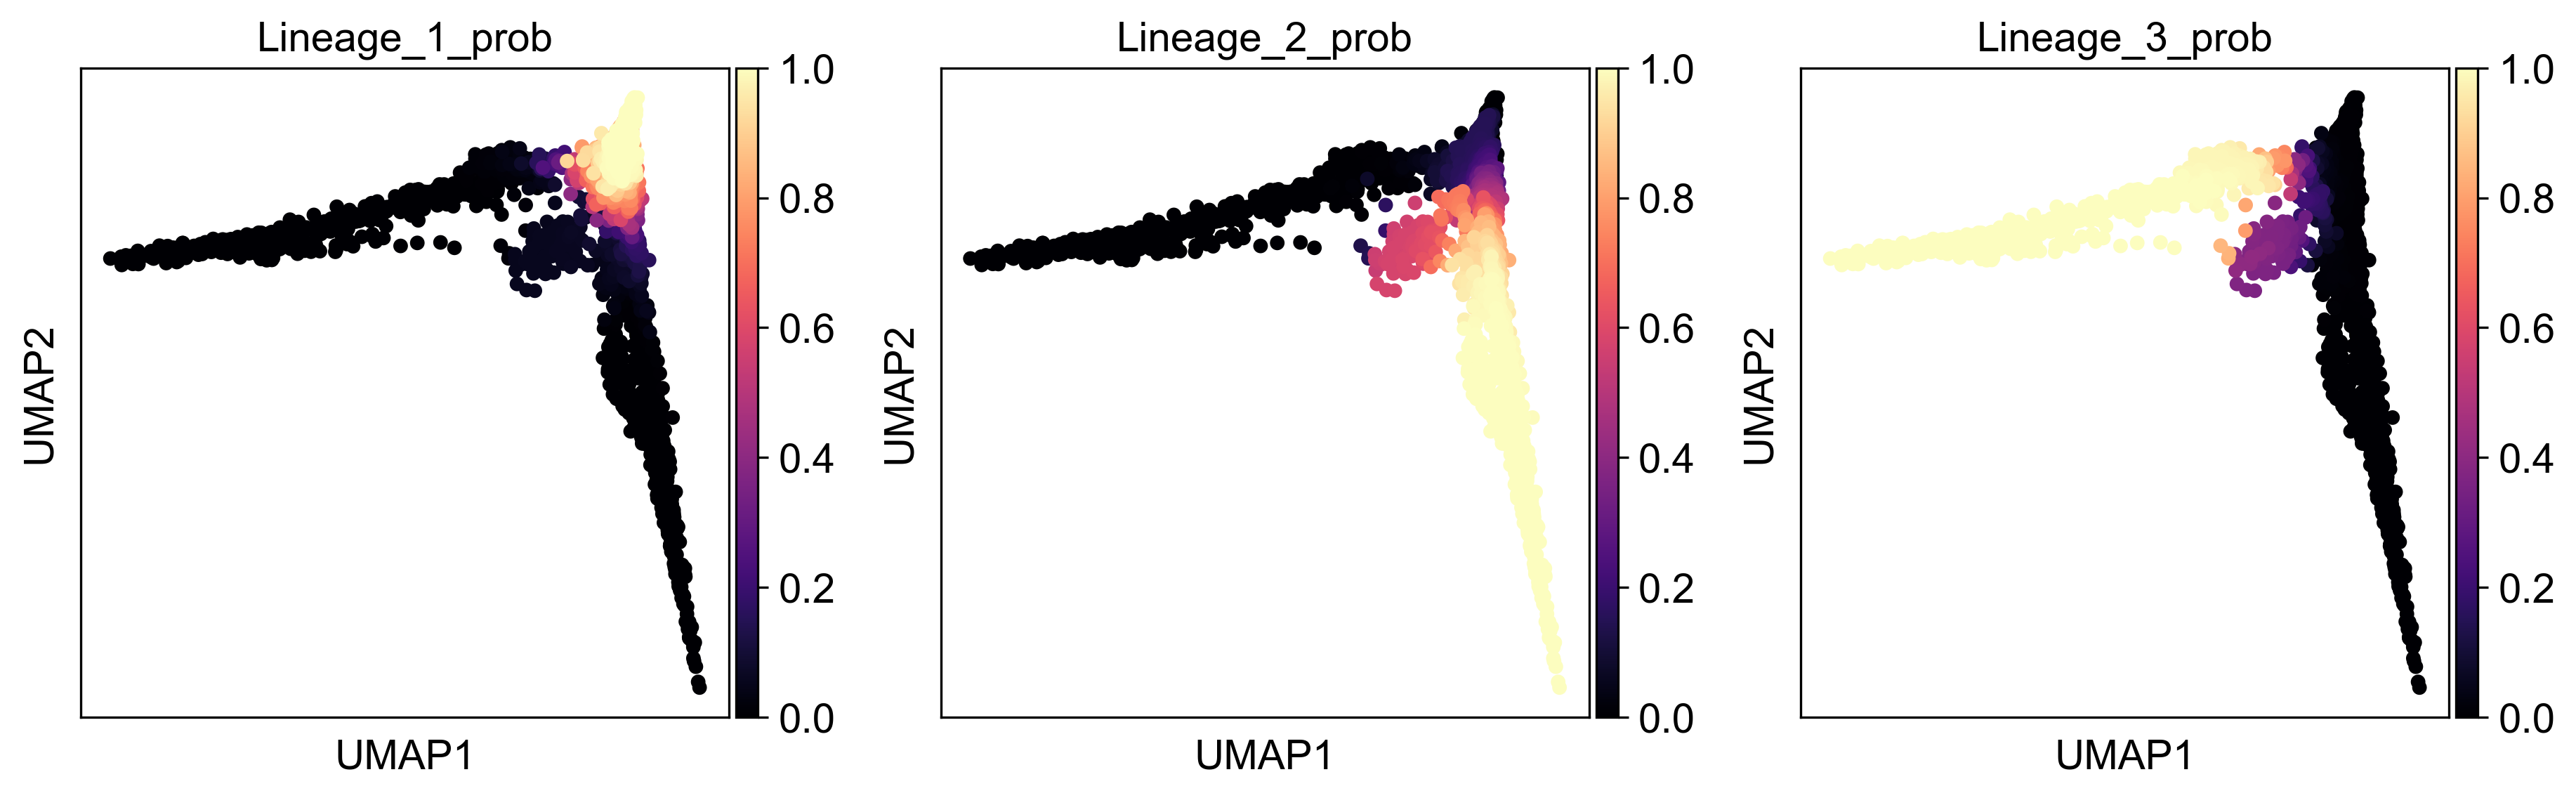

In [215]:
#sc.set_figure_params(dpi=300)
sc.pl.umap(data,size=100,
   color = [x + '_prob' for x in data.uns['lineage_names']],
   color_map='magma', )

In [216]:
#add the lineage ID to the data.obs
probs = pd.DataFrame(data.obs[['Lineage_1_prob','Lineage_2_prob','Lineage_3_prob']])
probs['lineage']=probs.idxmax(axis=1)
data.obs['lineage_id'] = probs['lineage']
data.obs

dataset subclust_v6   sample   topic_0  \
AAACAGCCAATTTGGT-1_4-0         16216 A        HSCs  Healthy  0.074140   
AAACAGCCACGTAATT-1_5-1         15669_A        HSCs      T21  0.070877   
AAACATGCACCAAAGG-1_6-1         15669_B        HSCs      T21  0.356007   
AAACATGCACTCAACA-1_6-0         16216 C        HSCs  Healthy  0.059937   
AAACATGCACTGGCCA-1_2-0         15836 B        HSCs  Healthy  0.039790   
...                                ...         ...      ...       ...   
TTTGTGTTCATGGCCA-1_5-1         15669_A        HSCs      T21  0.527575   
TTTGTGTTCGTTAGCG-1_2-1         15828 D        HSCs      T21  0.103658   
TTTGTTGGTAGGTTTG-1_6-0         16216 C        HSCs  Healthy  0.026887   
TTTGTTGGTATTGTCC-1_3-1  15582 nuclei A        HSCs      T21  0.016481   
TTTGTTGGTTGGTTAG-1_1-1         15828 C        HSCs      T21  0.301673   

                         topic_1   topic_2   topic_3   topic_4   topic_5  \
AAACAGCCAATTTGGT-1_4-0  0.106372  0.125760  0.161056  0.073365  0.118748   
AAACAGCCACGTAATT-1_5-1  0.025019  0.136288  0.059019  0.086465  0.528083   
AAACATGCACCAAAGG-1_6-1  0.025621  0.323884  0.031714  0.009339  0.193866   
AAACATGCACTCAACA-1_6-0  0.158530  0.039664  0.183762  0.042795  0.048636   
AAACATGCACTGGCCA-1_2-0  0.069174  0.040320  0.174865  0.138613  0.087510   
...                          ...       ...       ...       ...       ...   
TTTGTGTTCATGGCCA-1_5-1  0.016821  0.346680  0.016785  0.012329  0.035543   
TTTGTGTTCGTTAGCG-1_2-1  0.070901  0.211751  0.050471  0.267560  0.019935   
TTTGTTGGTAGGTTTG-1_6-0  0.202803  0.038244  0.196284  0.025415  0.031222   
TTTGTTGGTATTGTCC-1_3-1  0.050395  0.042955  0.101441  0.045711  0.025261   
TTTGTTGGTTGGTTAG-1_1-1  0.014676  0.162824  0.024437  0.227909  0.064482   

                         topic_6  ...   RBC_TRS      TRS_id  Subcluster_id  \
AAACAGCCAATTTGGT-1_4-0  0.240097  ...  0.202348  Other HSCs              3   
AAACAGCCACGTAATT-1_5-1  0.060666  ...  0.102366  Other HSCs              1   
AAACATGCACCAAAGG-1_6-1  0.033856  ...  0.120146  Other HSCs              1   
AAACATGCACTCAACA-1_6-0  0.268988  ...  0.258575  Other HSCs              3   
AAACATGCACTGGCCA-1_2-0  0.188383  ...  0.087446  Other HSCs              3   
...                          ...  ...       ...         ...            ...   
TTTGTGTTCATGGCCA-1_5-1  0.018553  ...  1.867089  Other HSCs              1   
TTTGTGTTCGTTAGCG-1_2-1  0.043435  ...  0.199014  Other HSCs              1   
TTTGTTGGTAGGTTTG-1_6-0  0.383438  ...  0.224606  Other HSCs              3   
TTTGTTGGTATTGTCC-1_3-1  0.095114  ...  0.101091  Other HSCs              3   
TTTGTTGGTTGGTTAG-1_1-1  0.017131  ...  0.181422  Other HSCs              1   

                       mira_connected_components mira_pseudotime  \
AAACAGCCAATTTGGT-1_4-0                         0        2.105842   
AAACAGCCACGTAATT-1_5-1                         0        3.576084   
AAACATGCACCAAAGG-1_6-1                         0        1.840182   
AAACATGCACTCAACA-1_6-0                         0        1.755990   
AAACATGCACTGGCCA-1_2-0                         0        2.944595   
...                                          ...             ...   
TTTGTGTTCATGGCCA-1_5-1                         0        2.524307   
TTTGTGTTCGTTAGCG-1_2-1                         0        1.174444   
TTTGTTGGTAGGTTTG-1_6-0                         0        3.149079   
TTTGTTGGTATTGTCC-1_3-1                         0        2.843117   
TTTGTTGGTTGGTTAG-1_1-1                         0        0.964088   

                       Lineage_1_prob  Lineage_2_prob  Lineage_3_prob  \
AAACAGCCAATTTGGT-1_4-0       0.990869        0.005566    3.565659e-03   
AAACAGCCACGTAATT-1_5-1       0.999925        0.000074    8.238152e-07   
AAACATGCACCAAAGG-1_6-1       0.970141        0.026639    3.220595e-03   
AAACATGCACTCAACA-1_6-0       0.495618        0.499837    4.545114e-03   
AAACATGCACTGGCCA-1_2-0       0.999209        0.000781    9.880727e-06   
...                               ...            

The get tree threshold controls how great the log2-ratio of differentiating down one branch compared to another must be to declare a branch point. 

INFO:mira.adata_interface.pseudotime:Added key to obs: tree_states
INFO:mira.adata_interface.pseudotime:Added key to uns: tree_state_names
INFO:mira.adata_interface.pseudotime:Added key to uns: connectivities_tree
... storing 'lineage_id' as categorical
... storing 'tree_states' as categorical


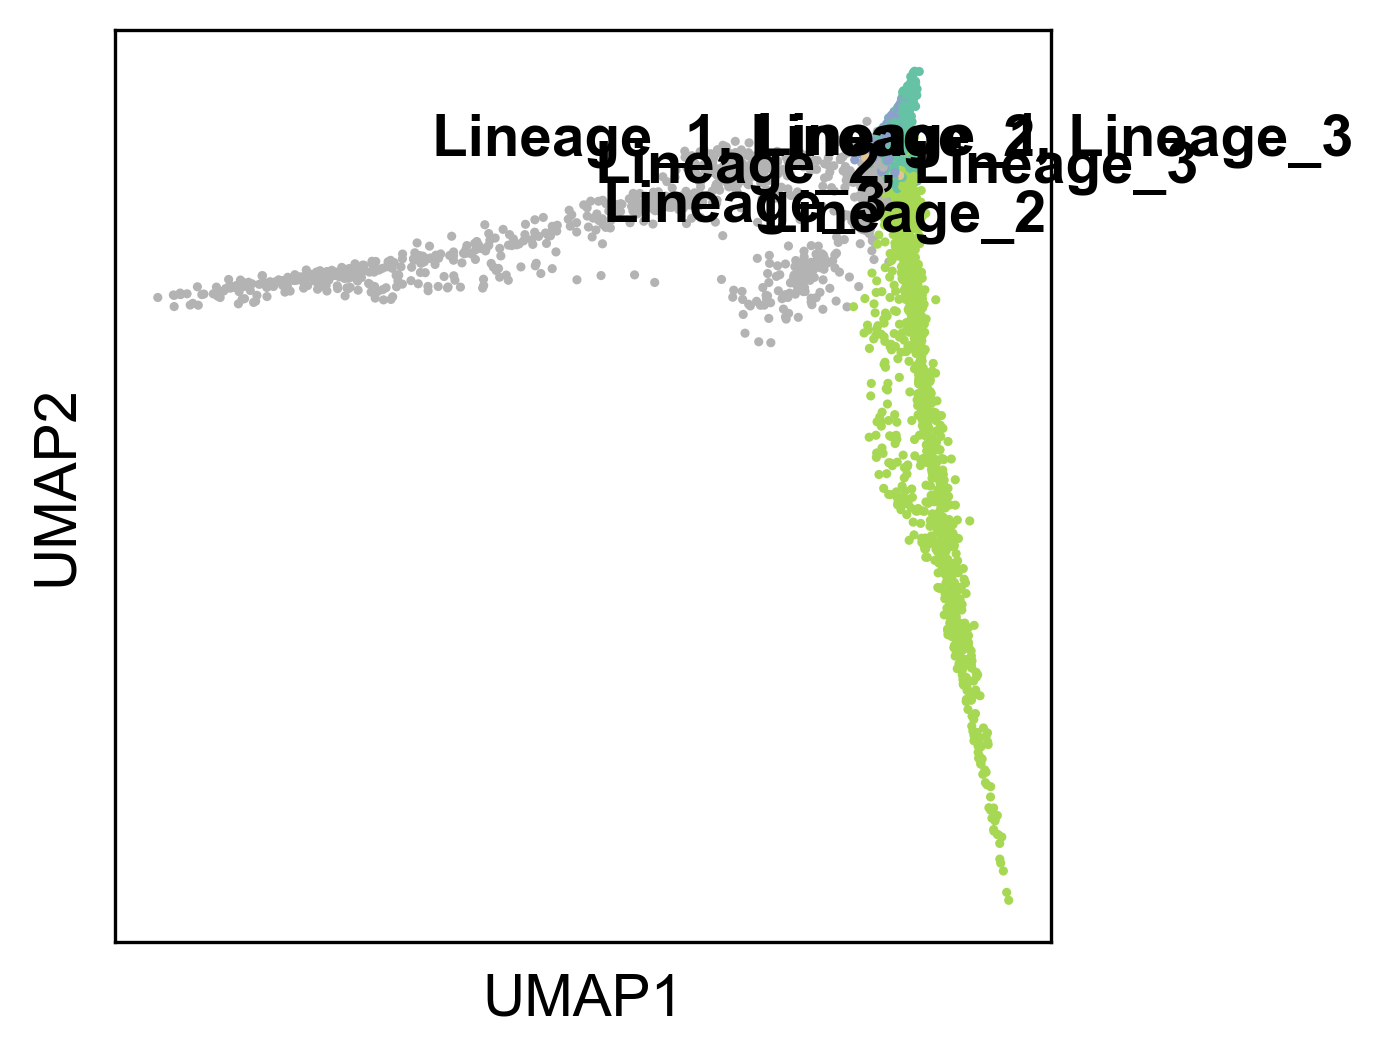

In [217]:
#recover dendrogram from branches 
mira.time.get_tree_structure(data, threshold = 1)
sc.pl.umap(data, color = 'tree_states', palette = 'Set2',
            title = '', legend_loc='on data')


In [218]:
data.obs.tree_states.unique()

['Lineage_1', 'Lineage_2', 'Lineage_3', 'Lineage_1, Lineage_2, Lineage_3', 'Lineage_2, Lineage_3']
Categories (5, object): ['Lineage_1', 'Lineage_2', 'Lineage_3', 'Lineage_1, Lineage_2, Lineage_3', 'Lineage_2, Lineage_3']

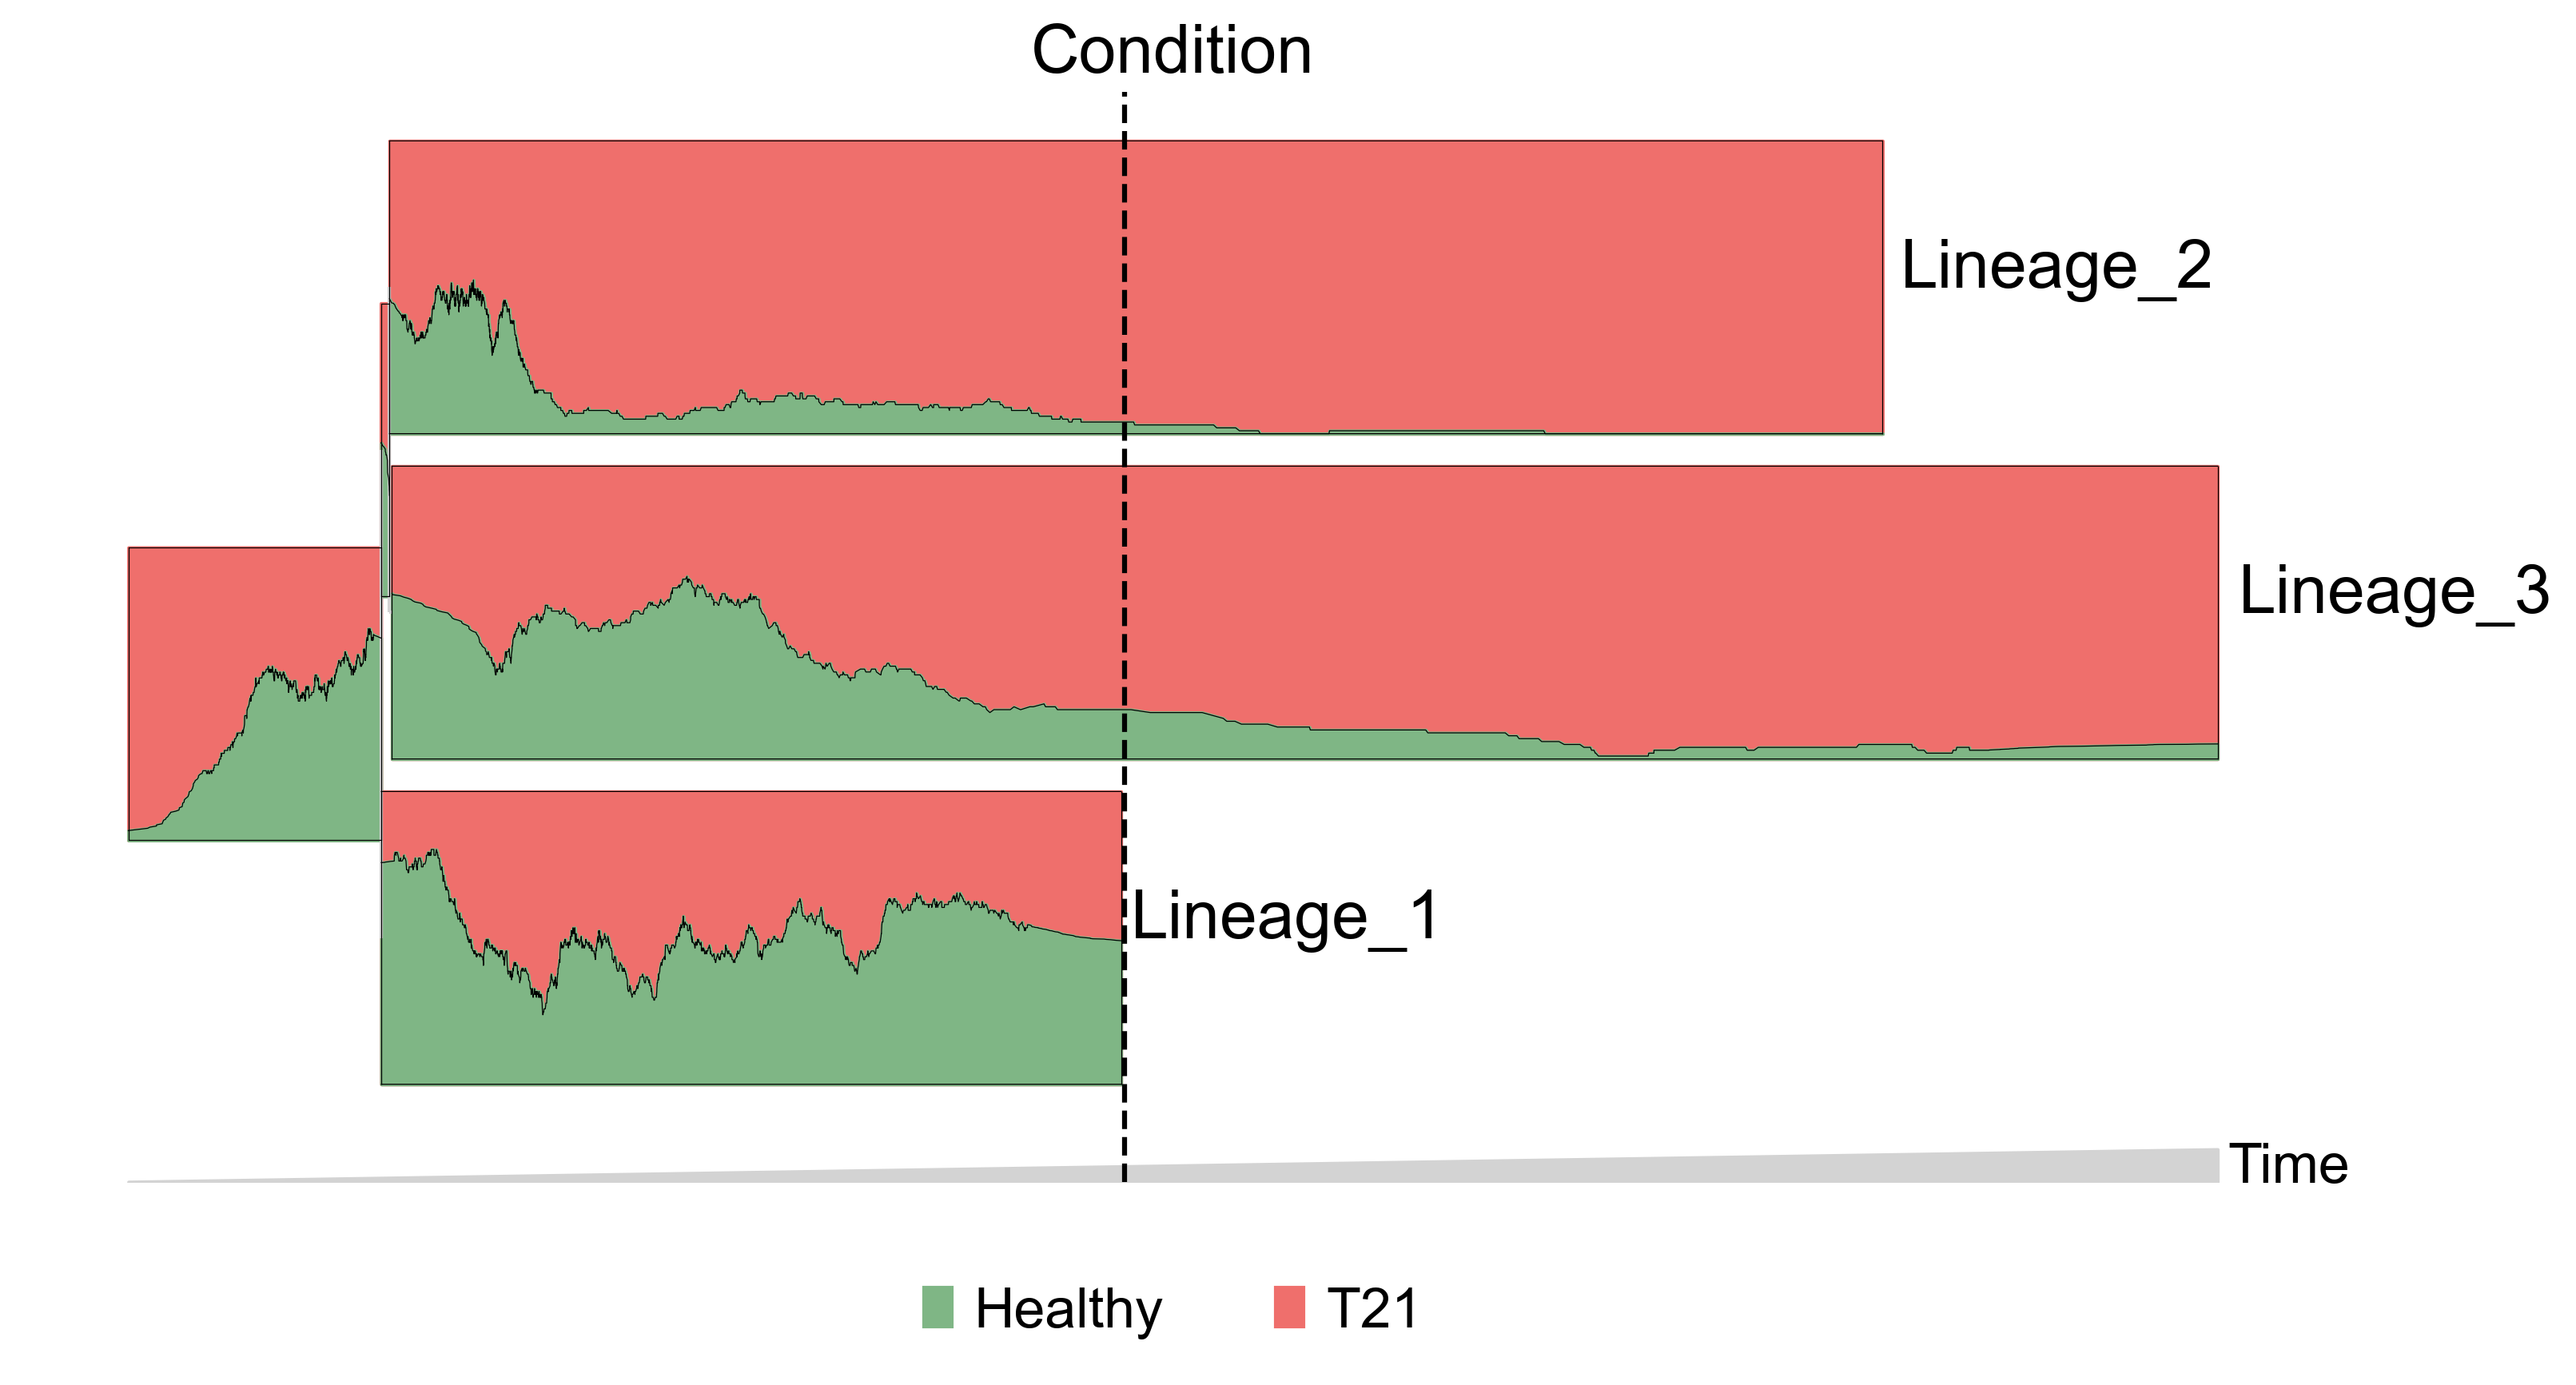

In [308]:
#plot proportion of T21 and healthy cells
#for the exact figure in the manuscript see the notebook with additional figures (the only difference is the smoothing factor)
plot_kwargs = dict(hide_feature_threshold=0.03, linewidth=0.3, max_bar_height=0.9,
                     legend_cols=4, figsize = (11,6), log_pseudotime=False)


data.obs['Healthy'] = [1.0 if x=='Healthy' else 0.0 for x in data.obs.sample]
data.obs['T21'] = [1.0 if x=='T21' else 0.0 for x in data.obs.sample]

mira.pl.plot_stream(data,
                    data = ['Healthy', 'T21'],
                    title = 'Condition',
                    palette=['#7FB685', '#EF6F6C'],
                    **plot_kwargs)

plt.axvline(x = 4.89, color = 'black', ls='--', )

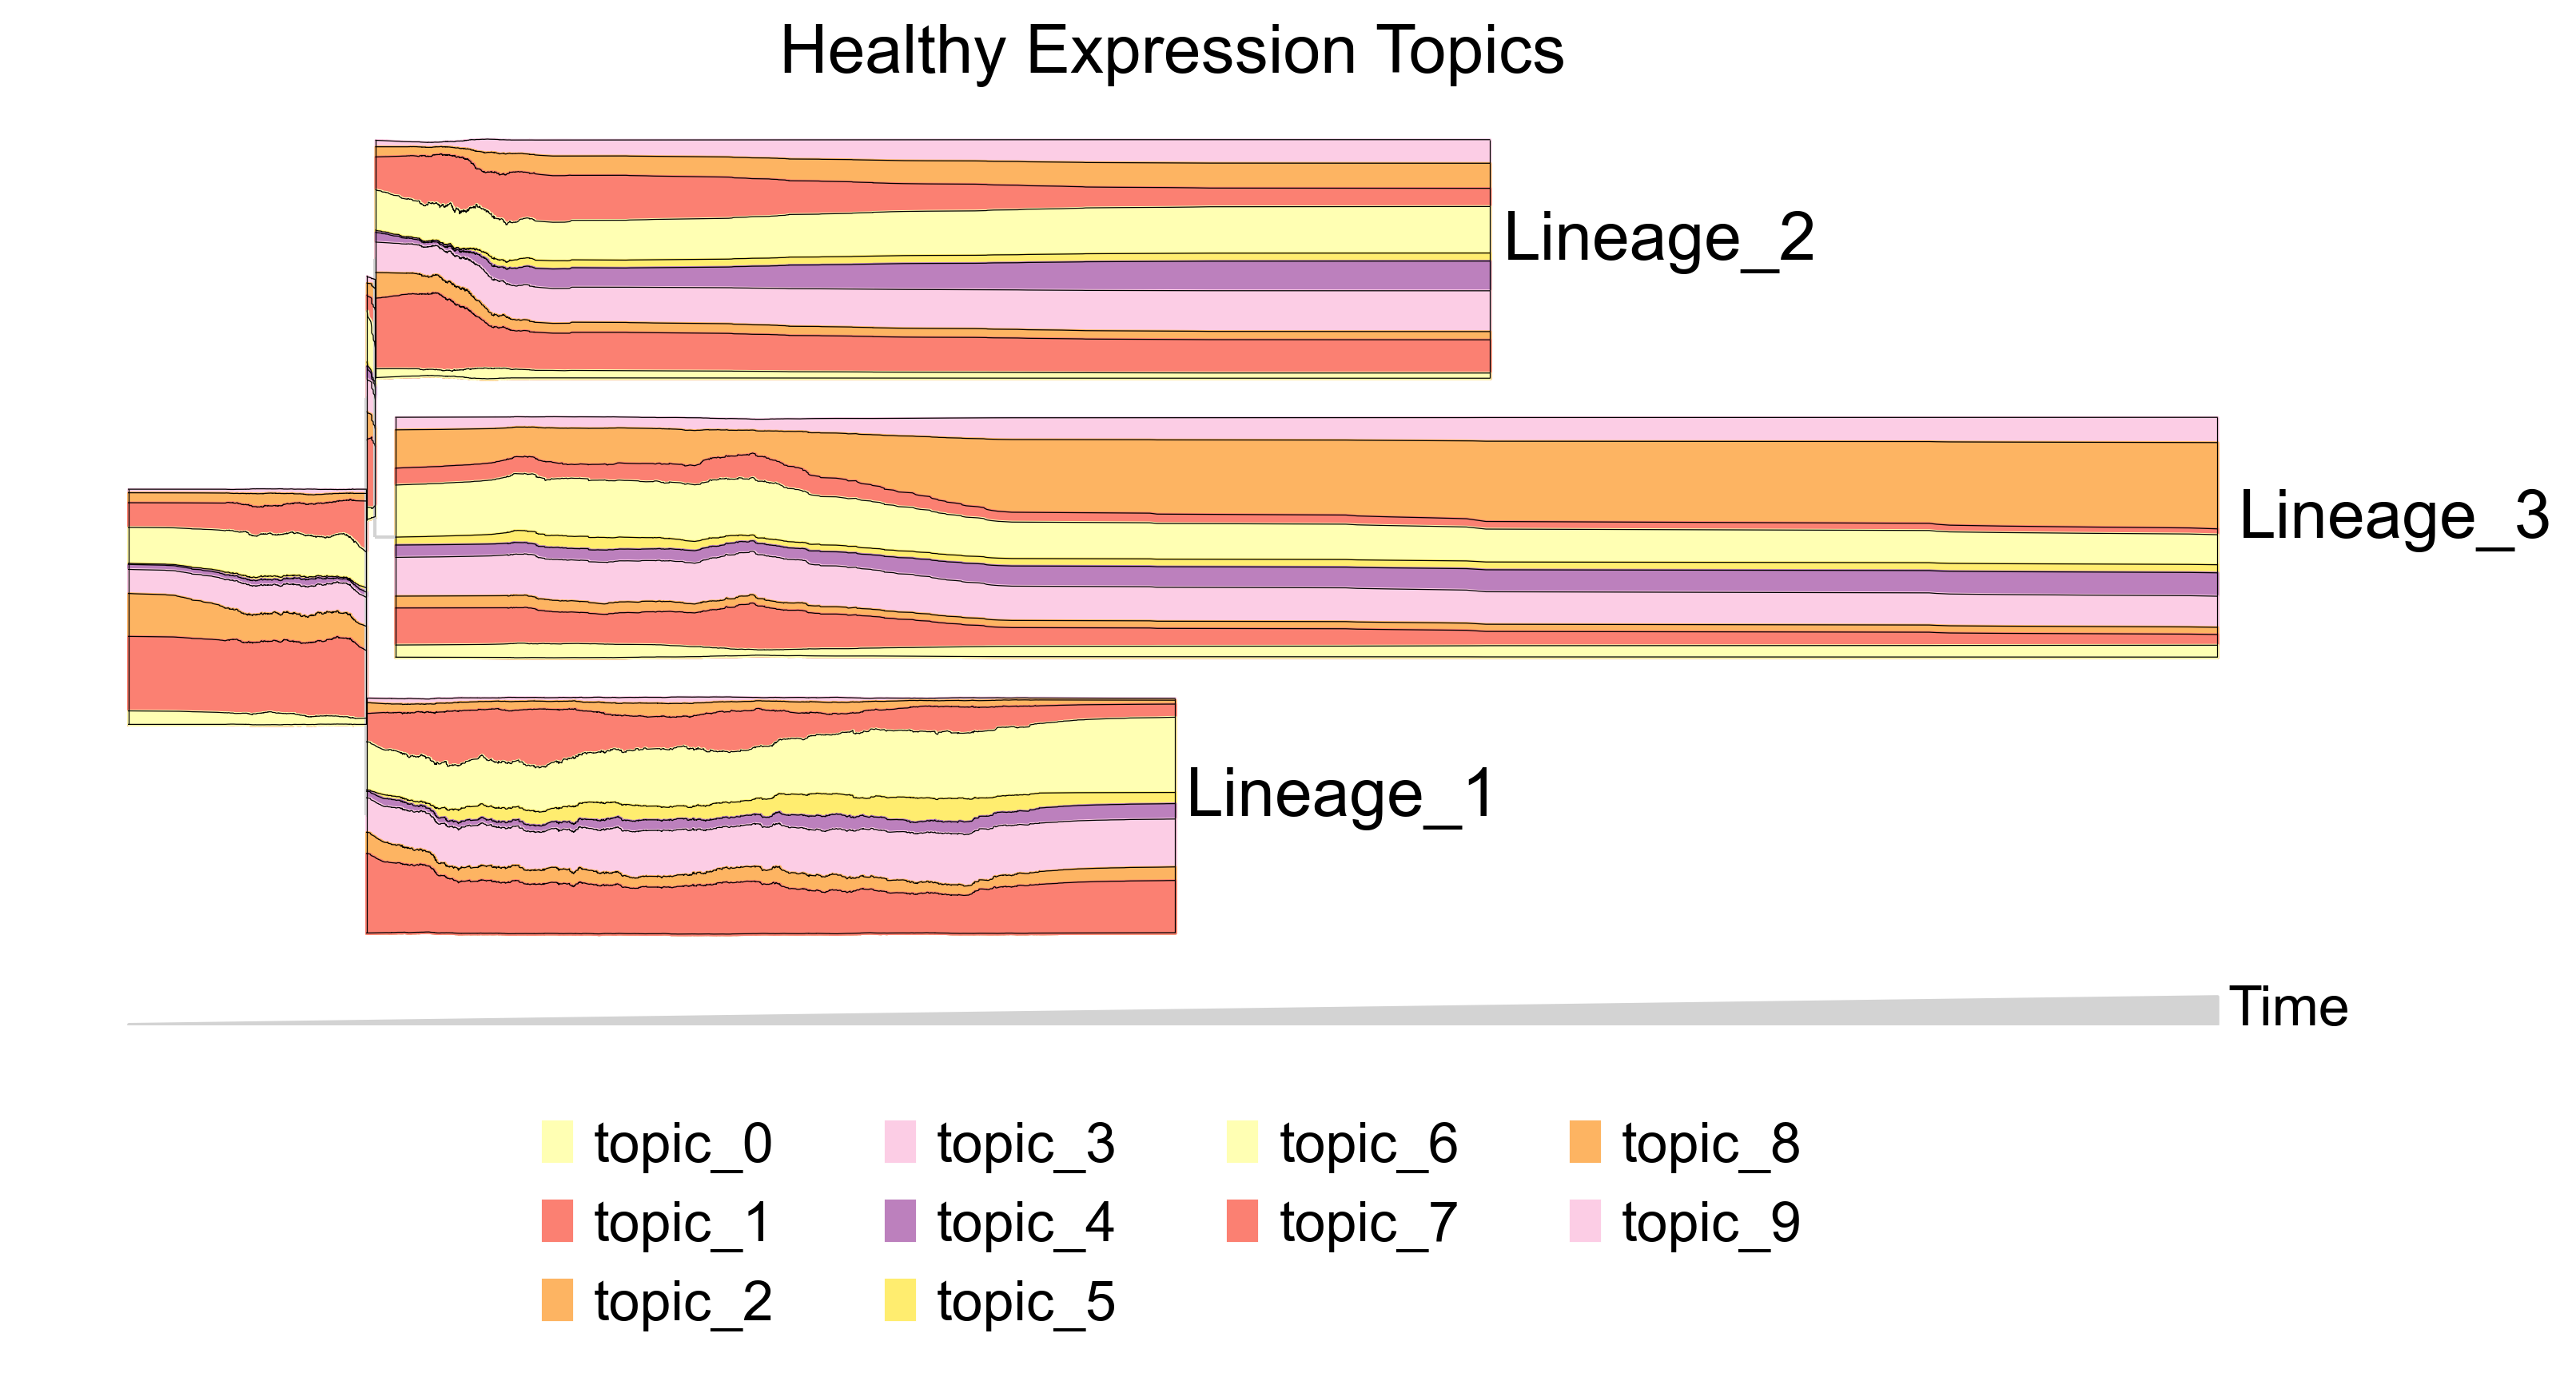

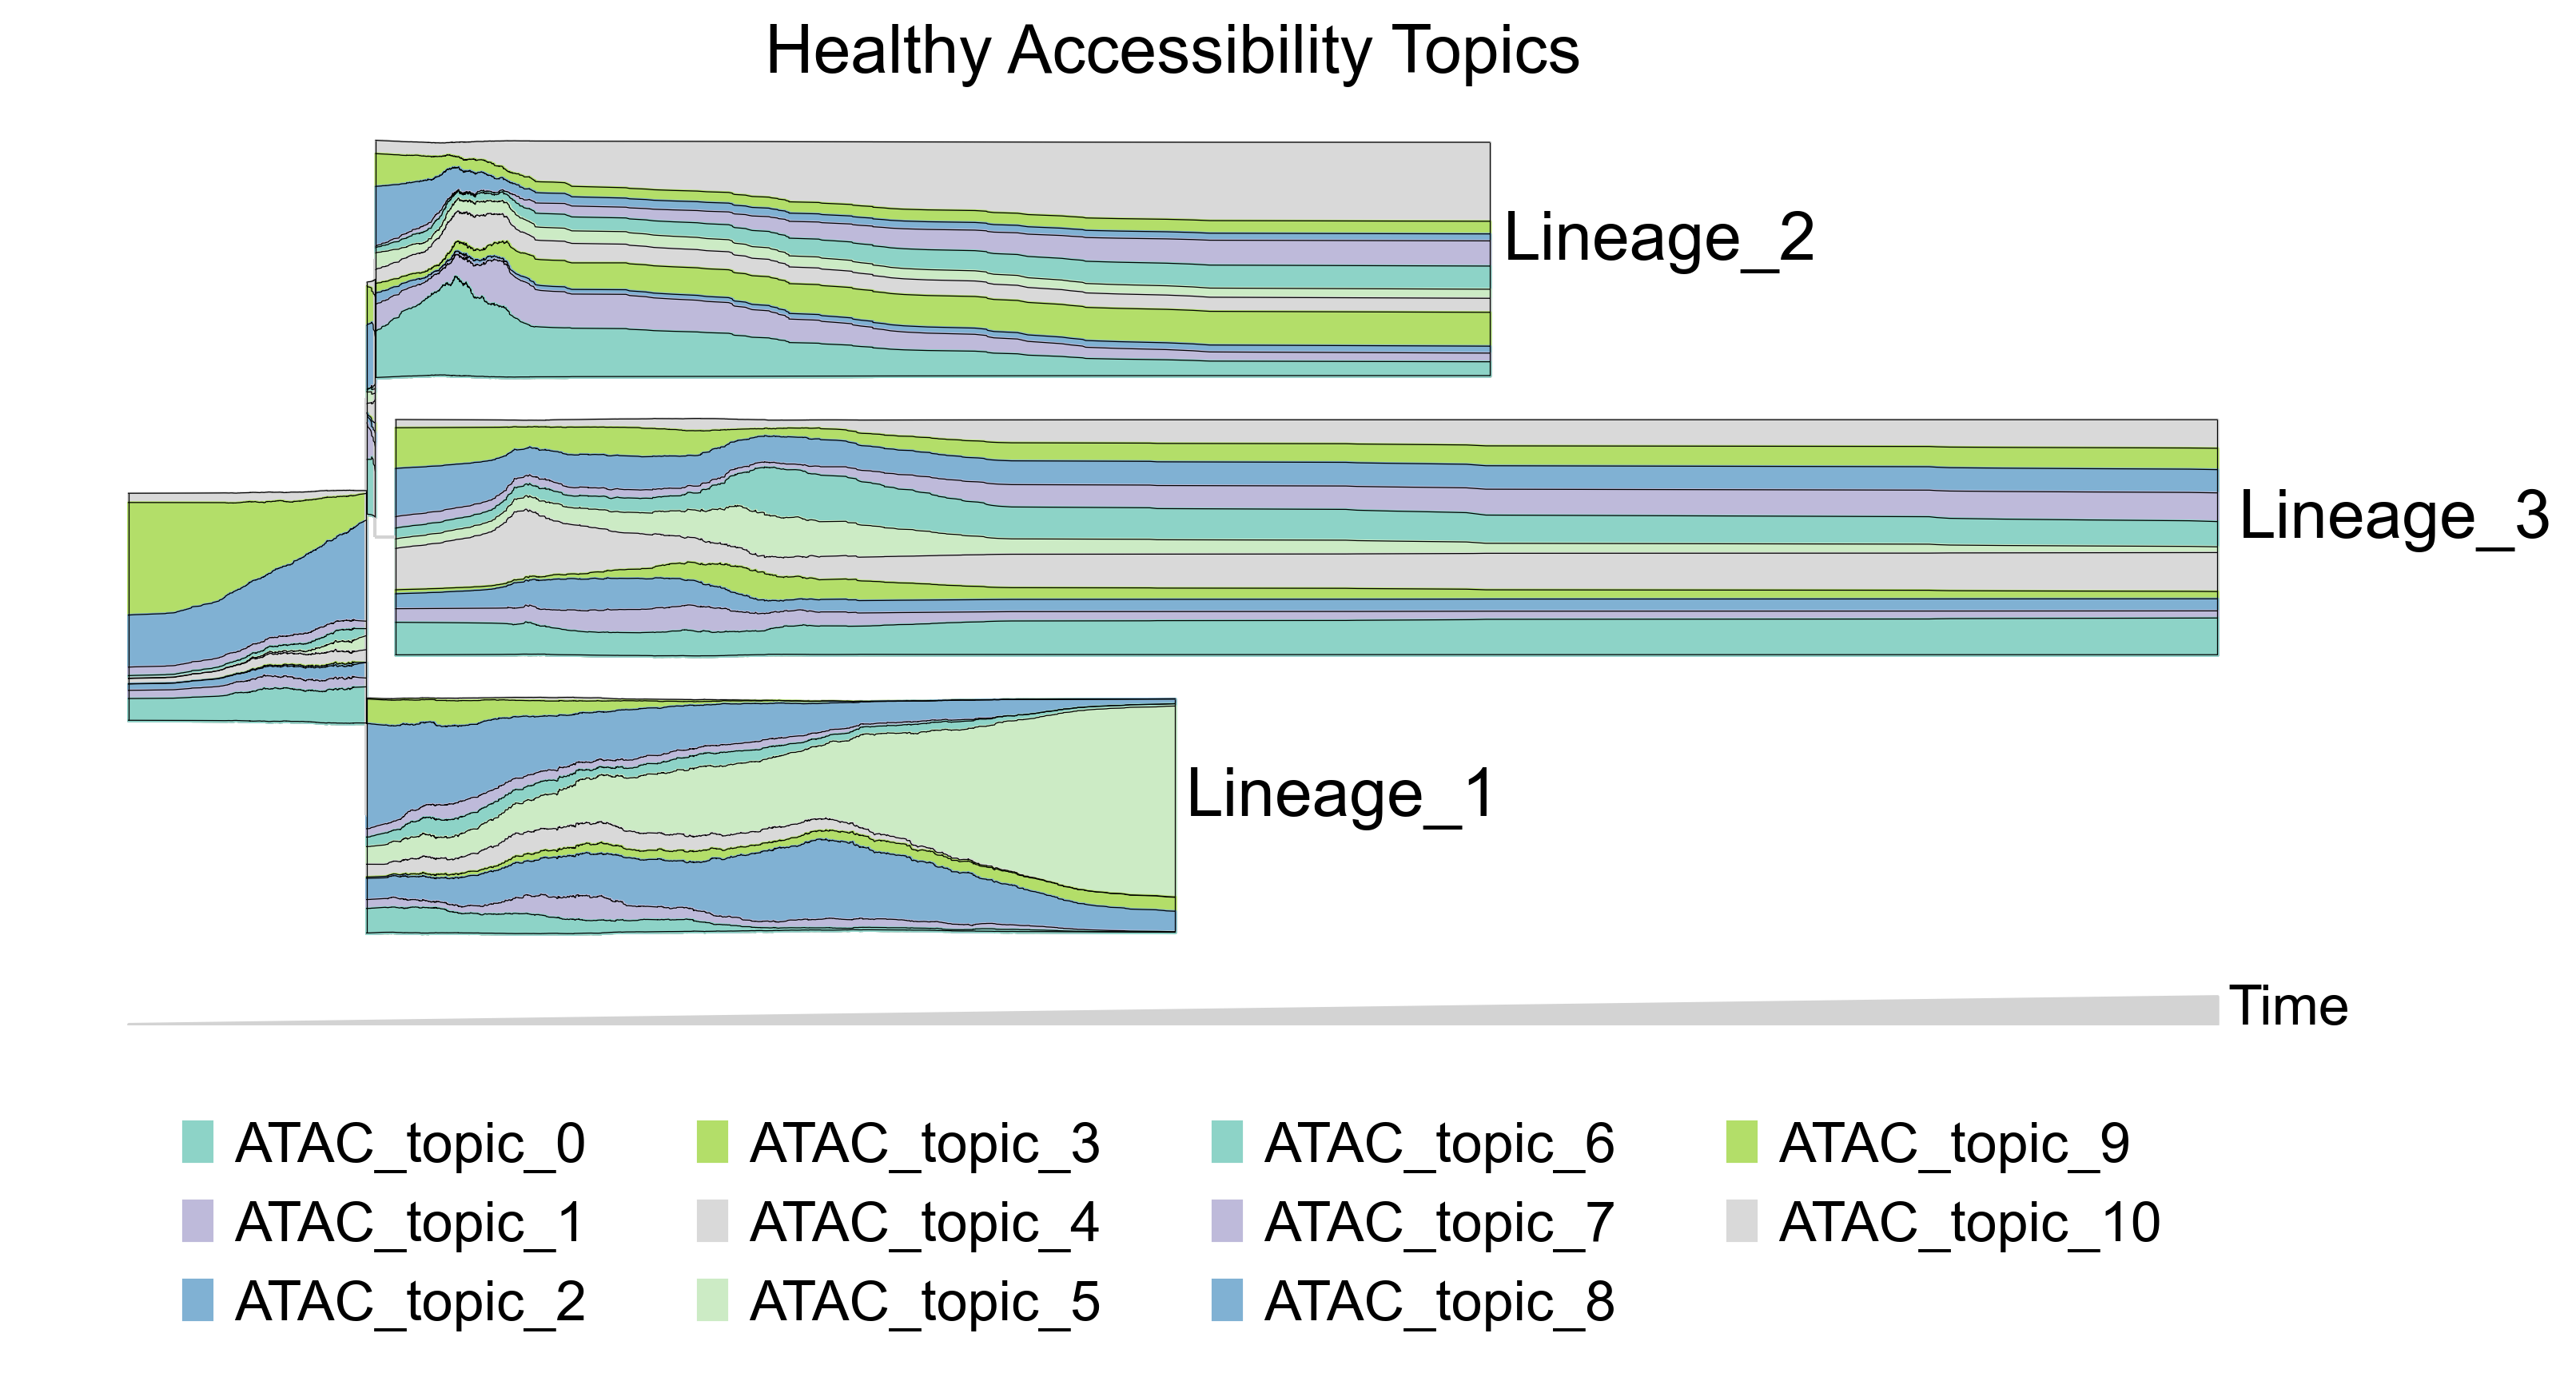

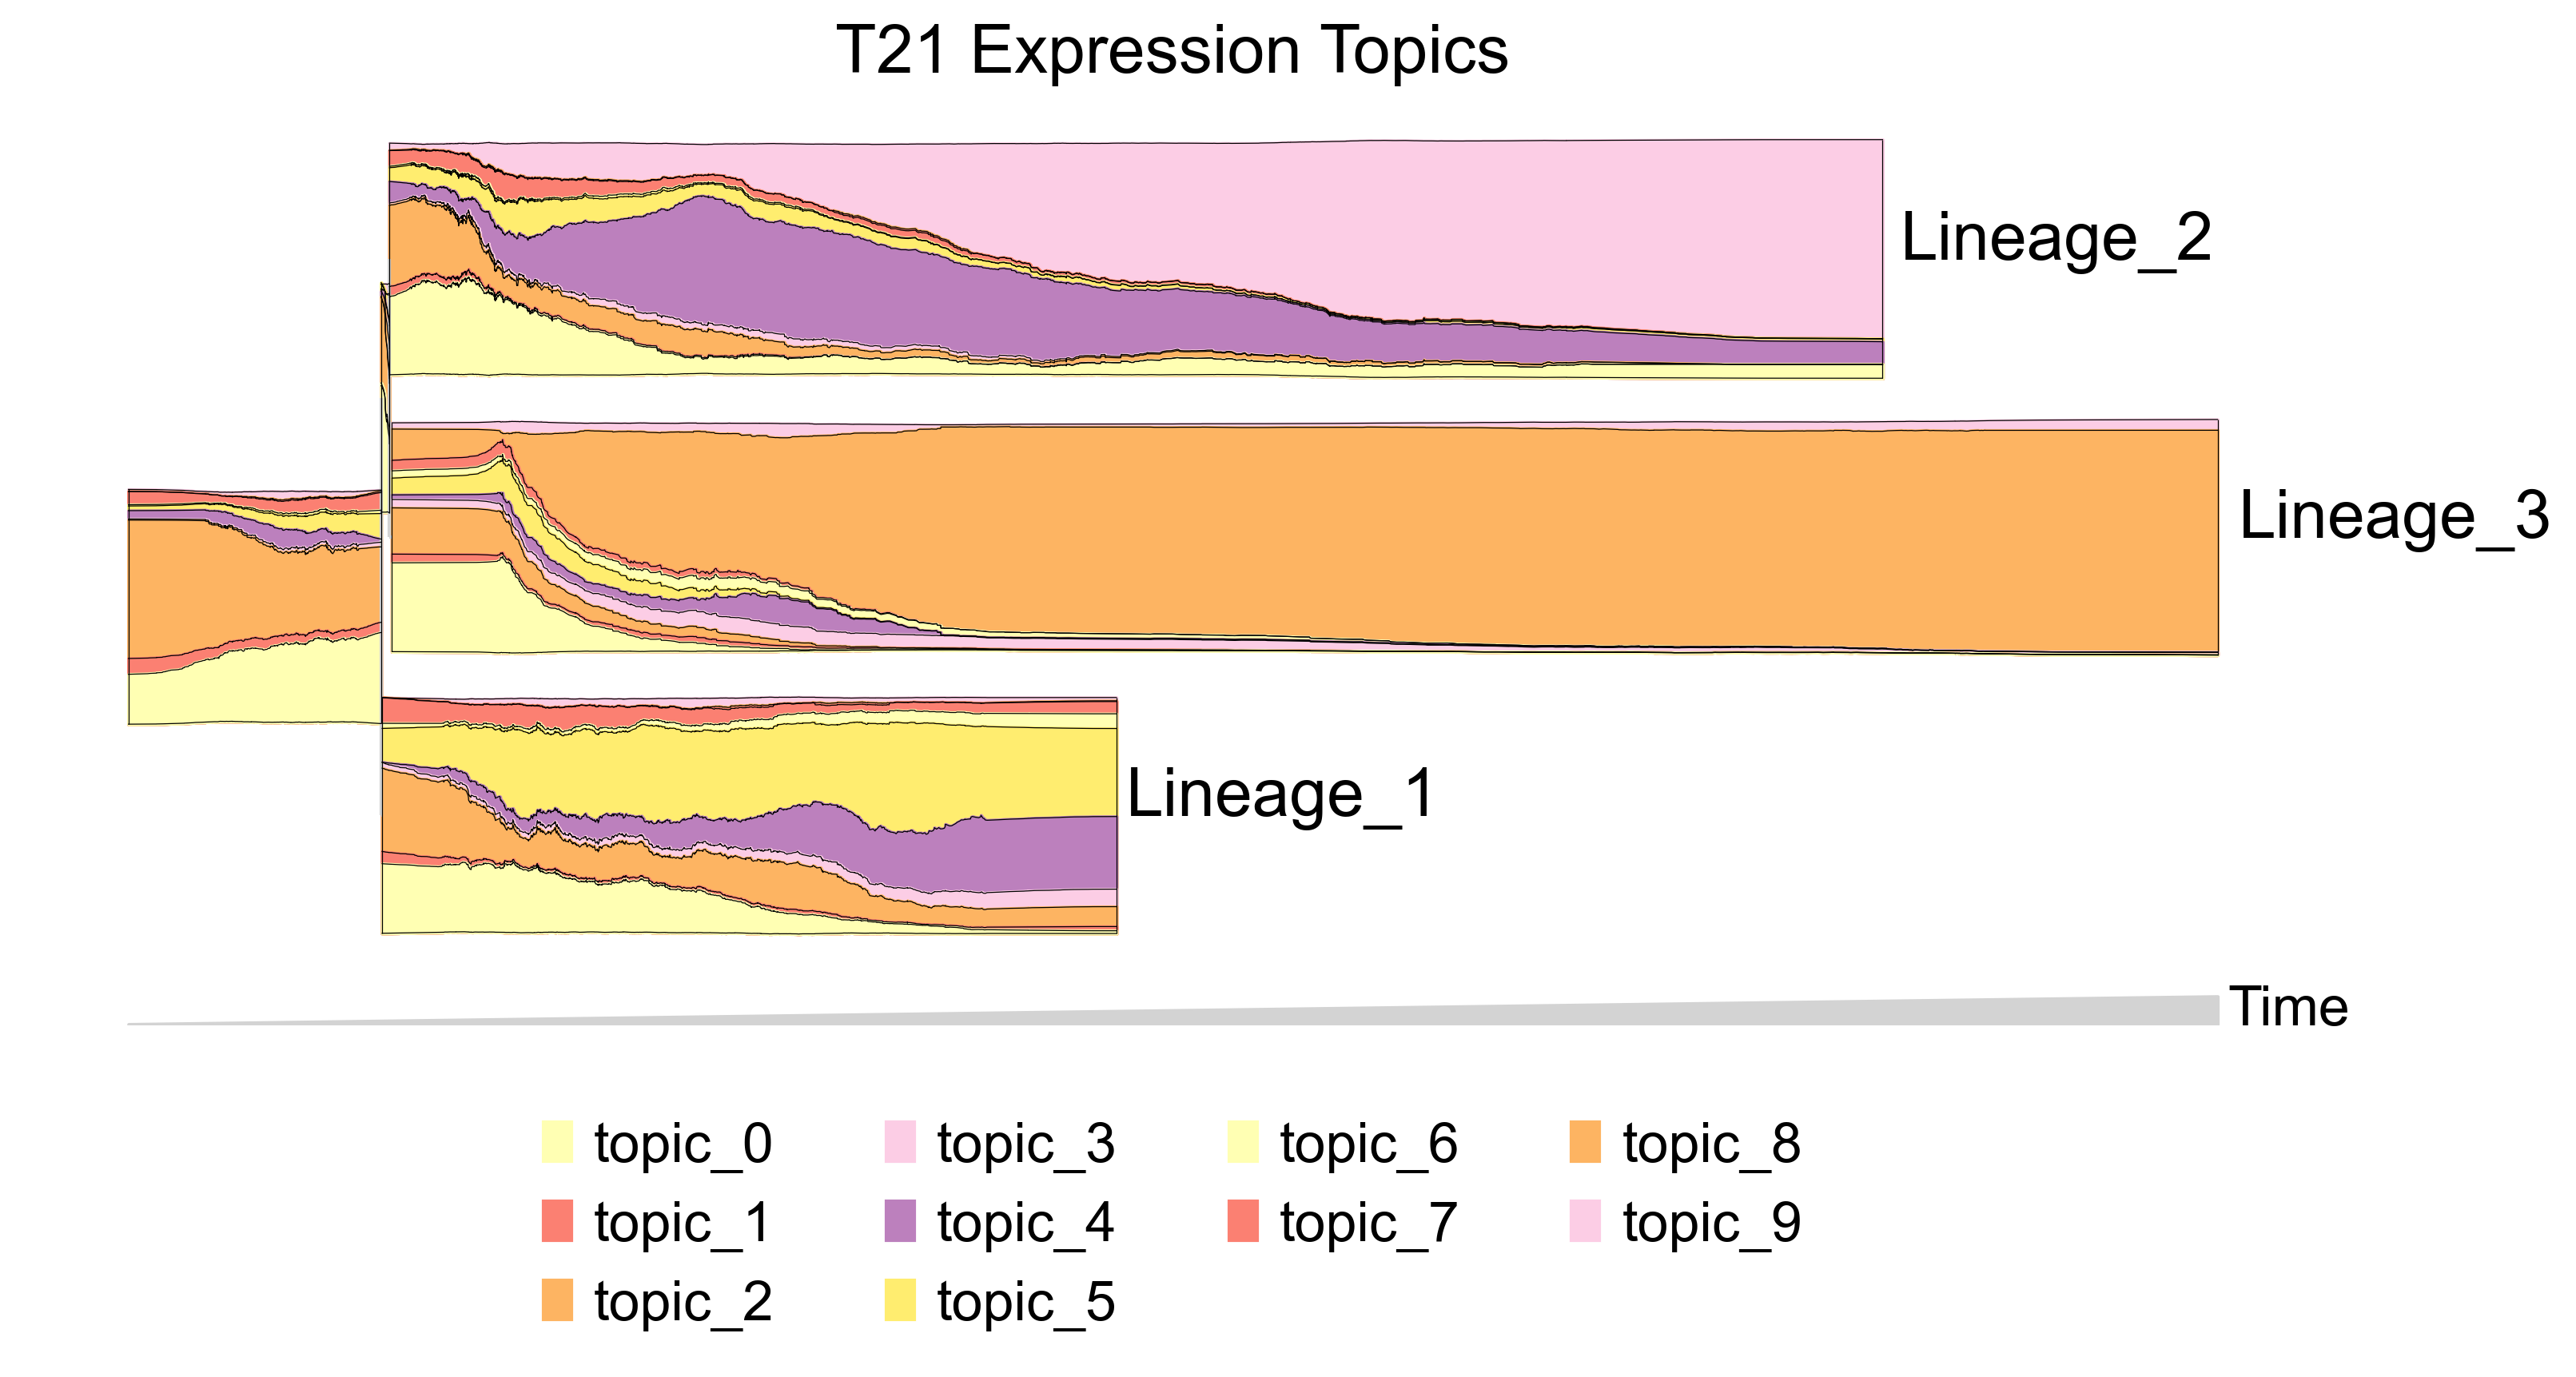

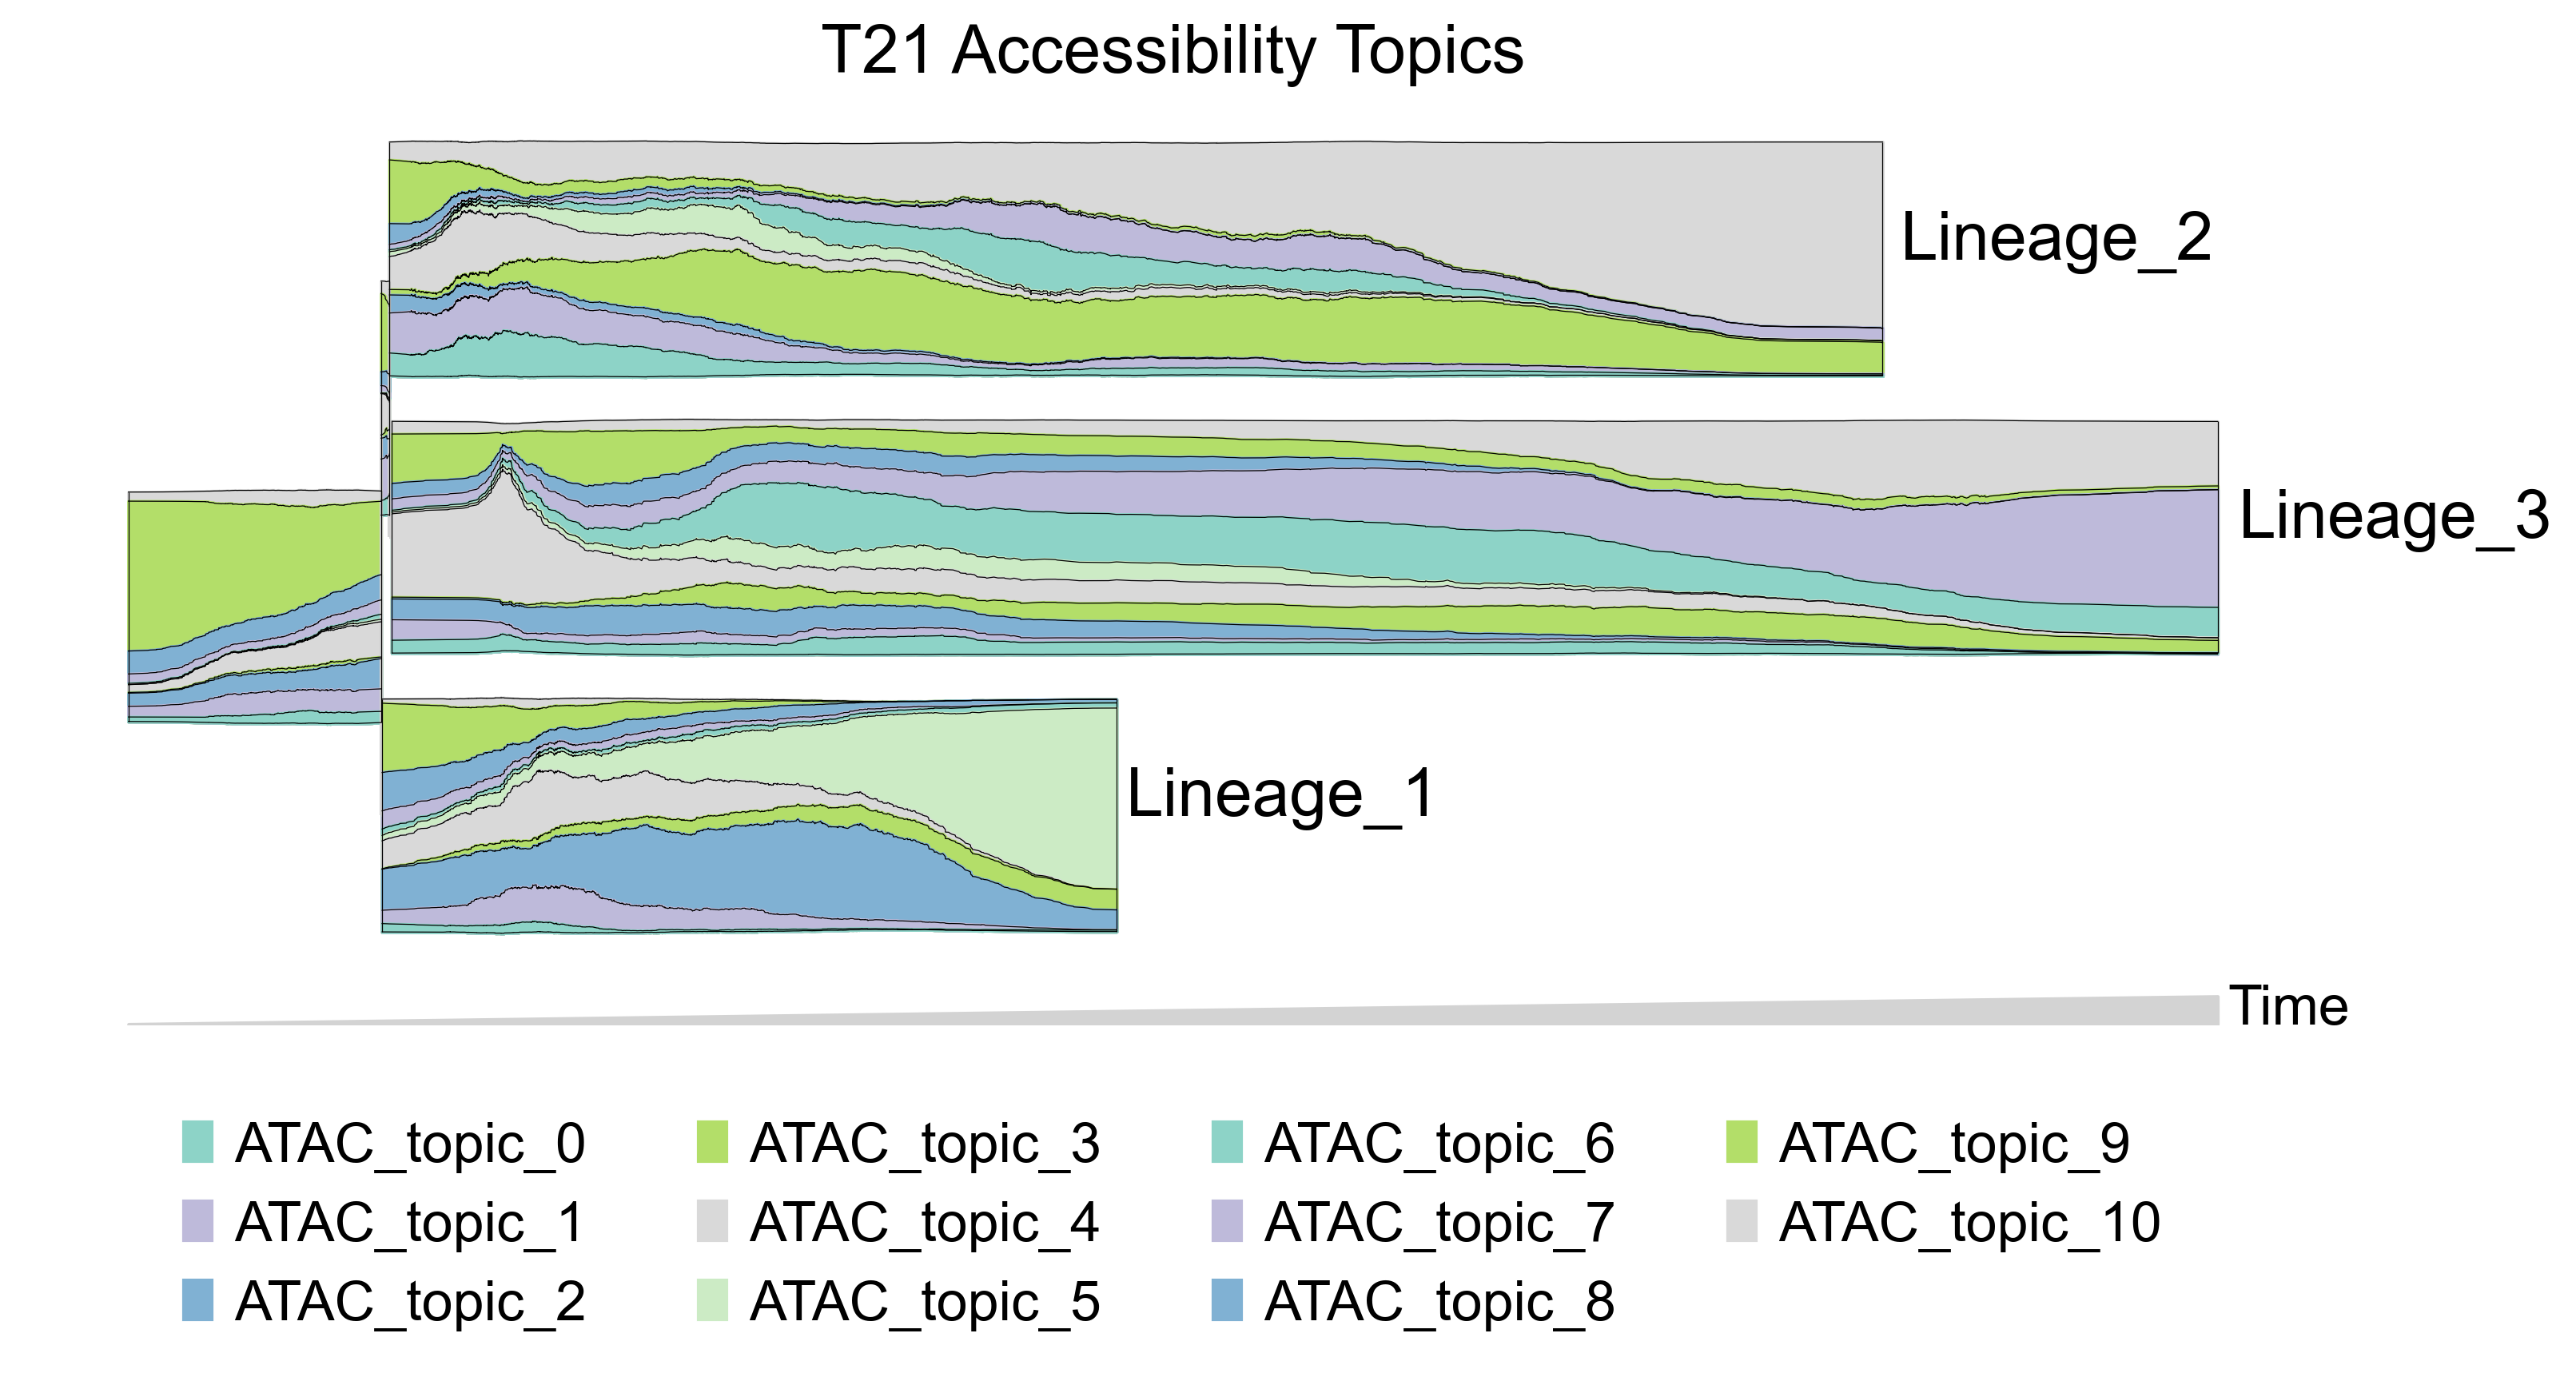

In [317]:
#plot how the topics change over pseudotime comparing between Healthy HSCs and Ts21 HSCs
hdata = data[data.obs['sample']=='Healthy']
tdata = data[data.obs['sample']=='T21']
mira.pl.plot_stream(hdata,
                    data = ['topic_' + str(i) for i in [0,1,2,3,4,5,6,7,8,9]],
                    title = 'Healthy Expression Topics',
                    palette=sns.color_palette('Set3')[1::2], # warm tones
                    **plot_kwargs)

mira.pl.plot_stream(hdata,
                    data = ['ATAC_topic_' + str(i) for i in [0,1,2,3,4,5,6,7,8,9,10]],
                    title = 'Healthy Accessibility Topics',
                    palette=sns.color_palette('Set3')[::2], #+ sns.color_palette('tab20')[::1], # cool tones
                    **plot_kwargs)

mira.pl.plot_stream(tdata,
                    data = ['topic_' + str(i) for i in [0,1,2,3,4,5,6,7,8,9]],
                    title = 'T21 Expression Topics',
                    palette=sns.color_palette('Set3')[1::2], # warm tones
                    **plot_kwargs)

mira.pl.plot_stream(tdata,
                    data = ['ATAC_topic_' + str(i) for i in [0,1,2,3,4,5,6,7,8,9,10]],
                    title = 'T21 Accessibility Topics',
                    palette=sns.color_palette('Set3')[::2], # cool tones
                    **plot_kwargs)

plt.show()


Notice how specific topics dominate the Ts21 HSCs as pseudotime progresses

INFO:mira.pseudotime.backtrace:Creating transport map ...
INFO:mira.pseudotime.backtrace:Tracing ancestral populations ...


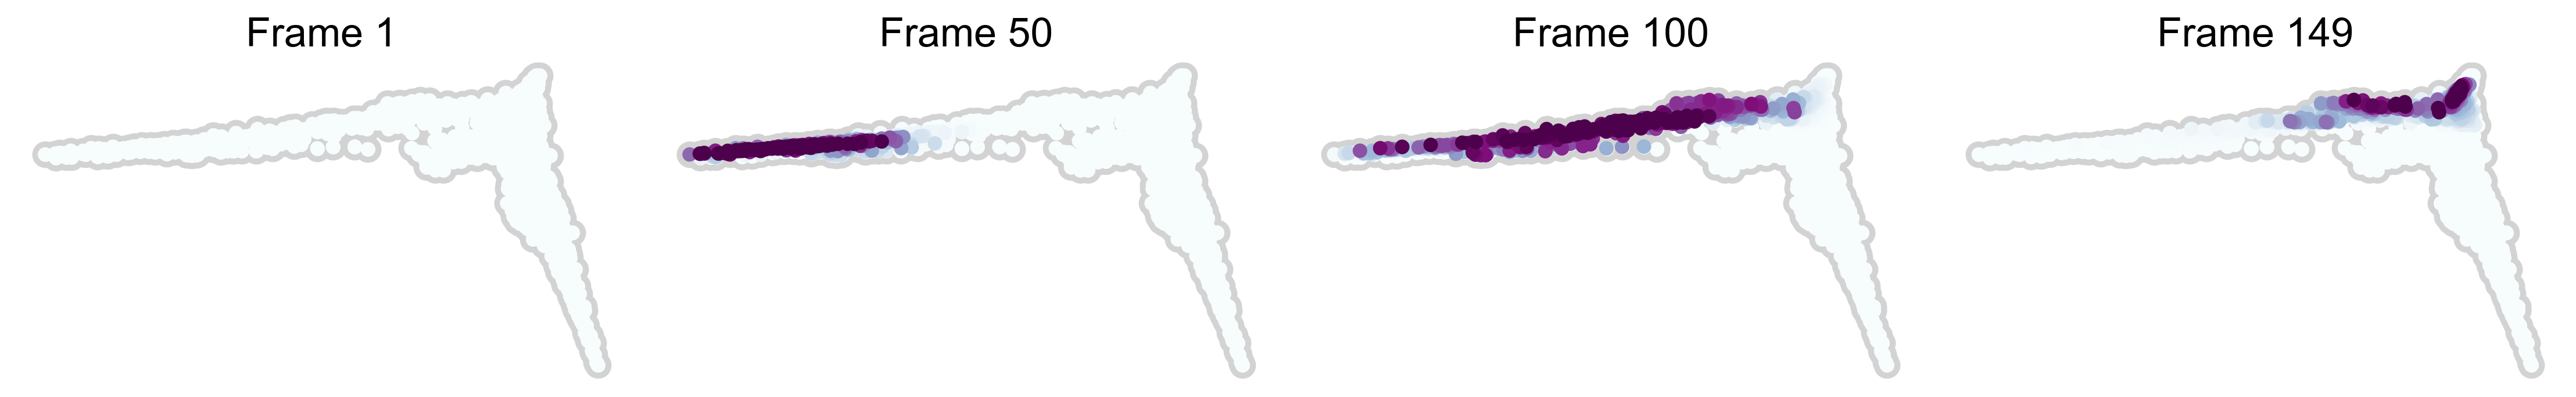

INFO:mira.pseudotime.backtrace:Creating animation ...
INFO:mira.pseudotime.backtrace:Saving animation ...
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


In [293]:
mira.time.trace_differentiation(data, start_lineage='Lineage_3', num_steps=1500,
                               save_name='Single_Cell/MIRA/figures/Lineage_3_gifs.gif', 
                                direction='backward', sqrt_time=True, size=25,outline_width=(0,3),
                               log_prob=True, steps_per_frame=10, figsize=(7,5), ka=3)


INFO:mira.pseudotime.backtrace:Creating transport map ...
INFO:mira.pseudotime.backtrace:Tracing ancestral populations ...


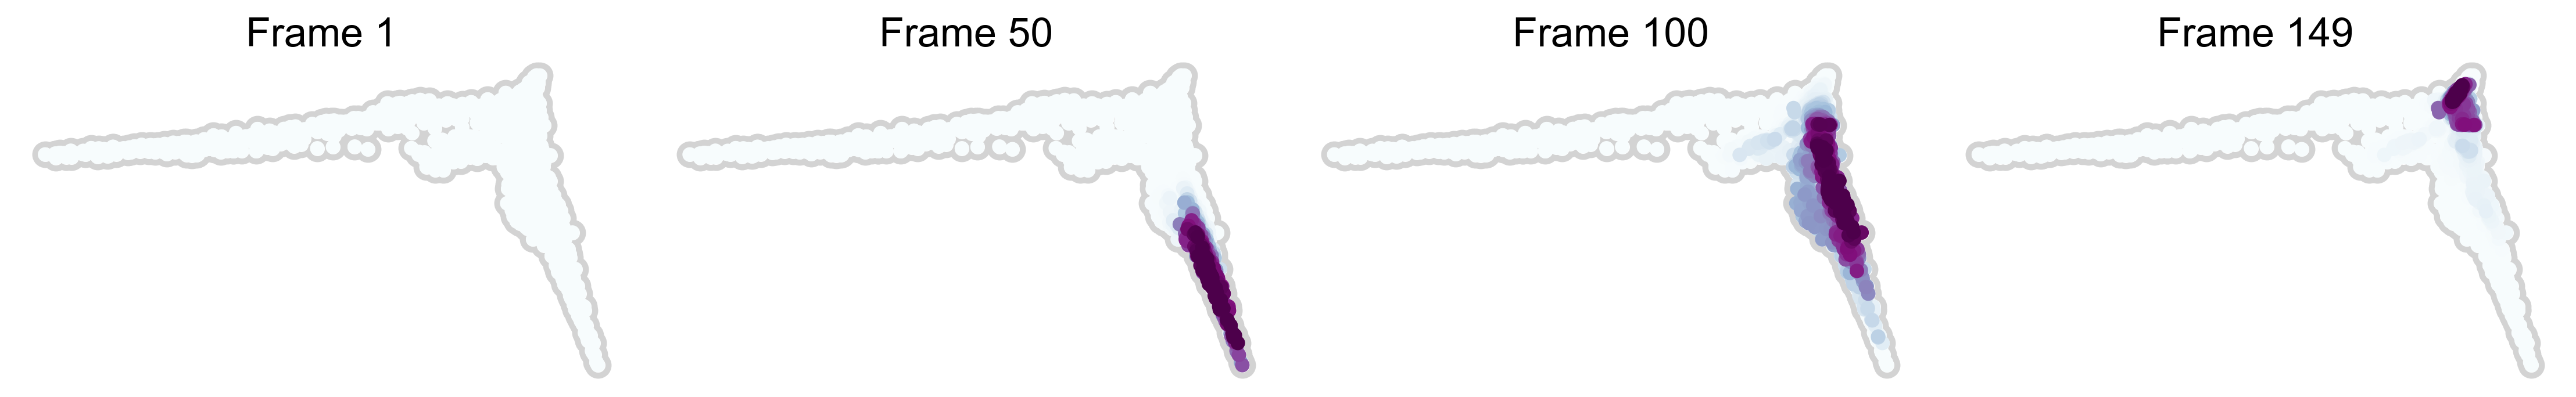

INFO:mira.pseudotime.backtrace:Creating animation ...
INFO:mira.pseudotime.backtrace:Saving animation ...
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


In [294]:
mira.time.trace_differentiation(data, start_lineage='Lineage_2', num_steps=1500,
                               save_name='Single_Cell/MIRA/figures/Lineage_2_gifs.gif', 
                                direction='backward', sqrt_time=True, size=25,outline_width=(0,3),
                               log_prob=True, steps_per_frame=10, figsize=(7,5), ka=3)

# Regulatory Modeling -- LITE MODEL

In [71]:
import warnings
warnings.simplefilter("ignore")
from IPython.display import Image

In [578]:
#ensure we are modeling the raw counts 
rna.layers['X_norm'] = rna.X.copy()
rna.X = rna.layers['counts']
print(rna.X[:20,:20])

  (0, 2)	1.0
  (2, 17)	4.0
  (3, 17)	1.0
  (5, 1)	1.0
  (5, 3)	1.0
  (5, 17)	1.0
  (6, 11)	1.0
  (6, 17)	5.0
  (8, 17)	2.0
  (10, 17)	1.0
  (11, 11)	1.0
  (12, 1)	1.0
  (12, 16)	1.0
  (13, 5)	1.0
  (13, 11)	1.0
  (13, 19)	1.0
  (14, 11)	1.0
  (15, 2)	1.0
  (15, 3)	2.0
  (15, 4)	1.0
  (15, 11)	1.0
  (15, 17)	2.0
  (16, 2)	1.0
  (16, 3)	1.0
  (16, 17)	1.0
  (16, 19)	1.0
  (17, 11)	1.0
  (19, 6)	1.0


In [72]:
#import the necessary supplementary data
mira.datasets.hg38_chrom_sizes()
mira.datasets.hg38_tss_data()


INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/hg38.chrom.sizes
INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/hg38_tss_data.bed12


In [75]:
mira.tl.get_distance_to_TSS(atac,
                            tss_data='mira-datasets/hg38_tss_data.bed12',
                            genome_file='mira-datasets/hg38.chrom.sizes')

INFO:mira.tools.connect_genes_peaks:Finding peak intersections with promoters ...
INFO:mira.tools.connect_genes_peaks:Calculating distances between peaks and TSS ...
INFO:mira.tools.connect_genes_peaks:Masking other genes' promoters ...
INFO:mira.adata_interface.rp_model:Added key to var: distance_to_TSS
INFO:mira.adata_interface.rp_model:Added key to uns: distance_to_TSS_genes


In [210]:
#make a dictionary of the ATAC and RNA datasets
rp_args = dict(expr_adata = rna, atac_adata= atac)

In [556]:
#we recommend training models for all highly-variable genes, 
#plus all genes that scored in the top 5% most-activated for any topic, 
#which gives a good survey of interesting gene expression variation in your data
rp_genes = list(model.features[model.highly_variable])
for topic in range(model.num_topics):
    rp_genes.extend(model.get_top_genes(topic, 200))
rp_genes = list(set(rp_genes))

In [570]:
#remove the genes that are not found in the TSS list 
tss = pd.read_csv('mira-datasets/hg38_tss_data.bed12', delimiter='\t')
tss_genes = list(tss['#geneSymbol'])
rp_genes_shared = []
for gene in rp_genes:
    if gene in tss_genes:
        rp_genes_shared.append(gene)

print(len(rp_genes))
print(len(rp_genes_shared))

5367
4454


In [580]:
litemodel = mira.rp.LITE_Model(expr_model = model,
                              accessibility_model=atc_model,
                              genes = rp_genes_shared)

In [581]:
litemodel.fit(**rp_args, n_workers=4,
              callback = mira.rp.SaveCallback('data/rpmodels/'))

Fitting models:   0%|          | 0/4454 [00:00<?, ?it/s]

In [583]:
#If you are interested in the distance of estimated regulatory influence for a certain gene
#distance is decay rate in kilobases
litemodel['GATA2'].parameters_

{'theta': 1.5638549,
 'gamma': 0.37924236,
 'bias': 1.1142153,
 'bn_mean': 5.0749054,
 'bn_var': 0.10346471,
 'bn_eps': 1e-05,
 'a_upstream': 1.8727912,
 'a_promoter': 1.4119313,
 'a_downstream': 0.103365056,
 'distance_upstream': 88.47313,
 'distance_downstream': 48.27579}

In [585]:
#Access all of the parameters for every gene 
LITE_param = pd.DataFrame(
    litemodel.parameters_
).T
LITE_param.to_csv('Single_Cell/MIRA/LITE_model_gene_parameters_HSCs_only.csv')
LITE_param

theta     gamma      bias   bn_mean        bn_var   bn_eps  \
BCOR        4.191417  0.077454  0.898671  1.625170  1.015631e-02  0.00001   
COL24A1     0.916089  0.350999  1.398409  0.401097  3.916571e-03  0.00001   
ABCD1       1.542740  0.093337 -1.302043  0.801186  1.334742e-02  0.00001   
GLIS1       0.673136  1.010719 -4.144593  0.011478  1.598349e-06  0.00001   
RAI1-AS1    1.400195  0.814623 -4.119866  0.004415  2.240767e-07  0.00001   
...              ...       ...       ...       ...           ...      ...   
MGAT5B      0.650492  0.142535 -3.524787  0.079749  2.578500e-04  0.00001   
DNM2       11.004759  0.173494  1.776851  1.008250  4.141082e-02  0.00001   
ATP5ME      1.954226  0.019878  0.384561  0.539113  2.309115e-03  0.00001   
MIR3681HG   0.901343  0.513438 -1.081419  0.033784  2.721125e-04  0.00001   
MYOM1       0.271019  0.738831 -0.944047  0.003413  2.236115e-07  0.00001   

           a_upstream  a_promoter  a_downstream  distance_upstream  \
BCOR         0.997646    1.206075      0.346469          35.553631   
COL24A1      1.865966    0.275294      0.755543          42.379723   
ABCD1        0.551683    0.635582      0.818270          16.064974   
GLIS1        0.303395    0.508322      0.396312           4.502354   
RAI1-AS1     0.243355    0.188334      0.236354           1.438262   
...               ...         ...           ...                ...   
MGAT5B       0.558554    0.431278      0.427249           9.967818   
DNM2         2.049239    1.335174      0.141654          26.593620   
ATP5ME       0.968271    0.558380      0.746373          29.618464   
MIR3681HG    0.452070    0.183439      0.705291           4.865978   
MYOM1        0.227038    0.359653      0.328765           1.919715   

           distance_downstream  
BCOR                 32.844948  
COL24A1              10.613233  
ABCD1                17.604122  
GLIS1                 5.815435  
RAI1-AS1              1.200558  
...                        ...  
MGAT5B                7.376906  
DNM2                 31.637800  
ATP5ME               22.416969  
MIR3681HG             4.062331  
MYOM1                 7.174246  

[4450 rows x 11 columns]

Say one wanted a list of all peaks within the influence of WNT3’s RP model. You can quickly access the peaks that make up a gene’s local cis-regulatory neighborhood using get_influential_local_peaks. 

This function takes the parameter decay_periods, which defines the distance covered by the gene’s chromatin neighborhood in terms of the decay_periods times the RP model’s upstream and downstream decay distances.

In [586]:
#Get the cis regulatory peaks for a specific gene 
litemodel['GATA2'].get_influential_local_peaks(atac, decay_periods = 5.).head(5)

n_cells_by_counts  mean_counts  \
chr3-128255029-128255239                 21     0.003379   
chr3-128269454-128270110                 36     0.006114   
chr3-128274121-128274560                 55     0.009815   
chr3-128278842-128279246                 53     0.009010   
chr3-128293995-128294409                 47     0.007884   

                          pct_dropout_by_counts  total_counts  n_cells  \
chr3-128255029-128255239              99.662108          21.0       21   
chr3-128269454-128270110              99.420756          38.0       36   
chr3-128274121-128274560              99.115044          61.0       55   
chr3-128278842-128279246              99.147224          56.0       53   
chr3-128293995-128294409              99.243765          49.0       47   

                          log_counts_cells  highly_variable     means  \
chr3-128255029-128255239          1.322219            False  0.001275   
chr3-128269454-128270110          1.556303            False  0.001587   
chr3-128274121-128274560          1.740363            False  0.003022   
chr3-128278842-128279246          1.724276            False  0.003966   
chr3-128293995-128294409          1.672098            False  0.003950   

                          dispersions  dispersions_norm   exog  endog   chr  \
chr3-128255029-128255239    -0.451628         -0.779152  False  False  chr3   
chr3-128269454-128270110    -0.768948         -1.419295  False  False  chr3   
chr3-128274121-128274560     0.061349          0.255697  False  False  chr3   
chr3-128278842-128279246     0.187227          0.509637  False  False  chr3   
chr3-128293995-128294409     0.527461          1.196006  False  False  chr3   

                              start        end  distance_to_TSS  is_upstream  
chr3-128255029-128255239  128255029  128255239         238066.0        False  
chr3-128269454-128270110  128269454  128270110         223418.0        False  
chr3-128274121-128274560  128274121  128274560         218860.0        False  
chr3-128278842-128279246  128278842  128279246         214156.0        False  
chr3-128293995-128294409  128293995  128294409         198998.0        False

In [588]:
#TSS-peak distances
tss_distances = mira.utils.fetch_gene_TSS_distances(atac)
tss_distances

AnnData object with n_obs × n_vars = 61261 × 388540
    obs: 'gene', 'chromosome', 'txStart', 'txEnd', 'strand'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'log_counts_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog', 'chr', 'start', 'end'

In [589]:
tss_distances.obs

gene chromosome   txStart     txEnd strand
DDX11L1          DDX11L1       chr1     11868     14409      +
MIR6859-1      MIR6859-1       chr1     17368     17436      -
MIR1302-2HG  MIR1302-2HG       chr1     29553     31097      +
WASH7P            WASH7P       chr1     14403     29570      -
MIR1302-2      MIR1302-2       chr1     30365     30503      +
...                  ...        ...       ...       ...    ...
CYCSP49          CYCSP49       chrY  26549424  26549743      +
SLC25A15P1    SLC25A15P1       chrY  26586641  26591601      -
CCNQP2            CCNQP2       chrY  26626519  26627159      -
PARP4P1          PARP4P1       chrY  26594850  26634652      -
CTBP2P1          CTBP2P1       chrY  56855243  56855488      +

[61261 rows x 5 columns]

With trained RP models, the predict function calculates the maximum aposteriori prediction of expression given the accessibility state of each gene in each cell.

In [590]:
#predict expression according to accessibility state, this takes 5-10 minutes
litemodel.predict(**rp_args)

Predicting expression:   0%|          | 0/4450 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


RP models define a local chromatin neighborhood where changes in accessibility appear to influence gene expression. One may assume that transcription factor binding in many cis-regulatory elements within this neighborhood suggests the transcription factor regulates the gene of interest. MIRA can query for these types of interactions at a systems level, finding potential regulatory associations across many gene-TF pairs.

# CIS regulation and TF association 

The algorithm for calculating these associations is called probabilistic in-silico deletion (pISD), and it measures the ability of the RP model to predict expression of a gene before and after the regulatory elements predicted to bind a certain transcription factor are masked. In this way, pISD simulates a “computational knock out” of that factor.

In [626]:
#calculate probabilistic in-silico deletion
litemodel.probabilistic_isd(**rp_args, n_workers = 4)

Predicting TF influence:   0%|          | 0/4450 [00:00<?, ?it/s]

INFO:mira.adata_interface.rp_model:Appending to expression adata:
INFO:mira.adata_interface.rp_model:Added key to varm: 'motifs-prob_deletion')
INFO:mira.adata_interface.rp_model:Added key to layers: motifs-informative_samples
INFO:mira.adata_interface.rp_model:Added key to uns: motifs


In [629]:
#save the motifs and modeled 
motifs.write('Single_Cell/MOTIFS_TFs_HSC.h5ad')

... storing 'mira_connected_components' as categorical
... storing 'tree_states' as categorical
... storing 'name' as categorical


In [628]:
rna.write('Single_Cell/rna_data_HSCs.rp_modeled.TF_to_gene_association.h5ad')

In [630]:
data.write('Single_Cell/Joint_representation_HSCs.lineages.pseudotime.h5ad')

# Input the gene to TF targeting from the regulatory potential model

In [2]:
rna = anndata.read_h5ad('Single_Cell/rna_data_HSCs.rp_modeled.TF_to_gene_association.h5ad')
rna

AnnData object with n_obs × n_vars = 6215 × 20880
    obs: 'dataset', 'subclust_v6', 'sample', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'ATAC_dataset', 'ATAC_subclust_v6', 'ATAC_sample', 'ATAC_n_genes_by_counts', 'ATAC_total_counts', 'ATAC_topic_0', 'ATAC_topic_1', 'ATAC_topic_2', 'ATAC_topic_3', 'ATAC_topic_4', 'ATAC_topic_5', 'ATAC_topic_6', 'ATAC_topic_7', 'ATAC_topic_8', 'ATAC_topic_9', 'ATAC_topic_10', 'pointwise_mutual_information', 'RBC_TRS', 'TRS_id', 'Subcluster_id', 'model_read_scale', 'softmax_denom'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog'
    uns: 'dataset_colors', 'hvg', 'log1p', 'motifs', 'neighbors', 'sample_colors', 'topic_dendogram', 'umap'
    obsm: 'X_joint_umap_features', 'X_joint_umap_features_harmony', 'X_topic_compositions', 'X_umap', 'X_umap_features', 'X_umap_features_harmony'
    varm: 'motifs-prob_deletion', 'topic_feature_activation

In [3]:
data = anndata.read_h5ad('Single_Cell/Joint_representation_HSCs.lineages.pseudotime.h5ad')
data

AnnData object with n_obs × n_vars = 6215 × 20880
    obs: 'dataset', 'subclust_v6', 'sample', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'ATAC_dataset', 'ATAC_subclust_v6', 'ATAC_sample', 'ATAC_n_genes_by_counts', 'ATAC_total_counts', 'ATAC_topic_0', 'ATAC_topic_1', 'ATAC_topic_2', 'ATAC_topic_3', 'ATAC_topic_4', 'ATAC_topic_5', 'ATAC_topic_6', 'ATAC_topic_7', 'ATAC_topic_8', 'ATAC_topic_9', 'ATAC_topic_10', 'pointwise_mutual_information', 'RBC_TRS', 'TRS_id', 'Subcluster_id', 'mira_connected_components', 'mira_pseudotime', 'Lineage_1_prob', 'Lineage_2_prob', 'Lineage_3_prob', 'differentiation_entropy', 'lineage_id', 'tree_states', 'Healthy', 'T21', 'Subcluster_1', 'Subcluster_2', 'Subcluster_3'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog'
    uns: 'X_diffmap', 'connectivities_tree', 'dataset_colors', 'diffmap_evals', 'eigen_gap', 'hvg', 'lineage_names', 'log1p', 'n

In [4]:
#This test defines a matrix of association scores between gene-TF pairs. We can access this matrix directly with:
isd_matrix = mira.utils.fetch_ISD_matrix(rna) # ISD results stored in RNA AnnData
# genes are rows, TFs are columns
isd_matrix 


SMAD4           SRF       CRX       GLI2     FOXK1     RUNX2  \
LINC01409 -0.001751  0.000000e+00  0.002268  -0.123095  0.239453  0.236818   
LINC00115 -0.753136 -1.833723e-07 -2.559813   2.657066 -1.804005  0.311790   
LINC02593 -0.078132  0.000000e+00  0.009452  -0.060653  0.573114 -0.989360   
SAMD11    -0.718533  0.000000e+00 -0.090139  -0.563124  0.916678 -1.862879   
NOC2L     -2.923326  0.000000e+00  0.324921   0.888201  2.359562 -0.208220   
...             ...           ...       ...        ...       ...       ...   
IKBKG      0.662145  5.547270e-01 -0.004626  -0.565490  0.662259 -0.110118   
MPP1      -2.450082  6.154475e-01 -0.498359  39.477558  1.602888  0.000000   
PCDH11Y    0.000000  0.000000e+00  0.000000   0.000000  0.000000  0.000000   
NLGN4Y     0.000000  0.000000e+00  0.000000   0.000000  0.000000  0.000000   
MT-ND6     0.000000  0.000000e+00  0.000000   0.000000  0.000000  0.000000   

              FOXP3   CREB3L2  NR4A2::RXRA    MLXIPL  ...      STAT6  \
LINC01409 -0.001093 -0.123134    -0.000010 -0.118530  ...   0.003319   
LINC00115 -0.109697  3.544615     0.293240  2.381905  ...  -2.889976   
LINC02593 -0.000010  0.580495     0.000320  0.000000  ...  -0.232144   
SAMD11    -0.010262  0.966132     0.119901 -0.000014  ...  -0.635094   
NOC2L      0.090940  1.716630     2.173050  0.039463  ...  -0.763435   
...             ...       ...          ...       ...  ...        ...   
IKBKG     -0.082308 -1.626528    -0.332451 -2.303104  ...  -8.097947   
MPP1       0.673911  9.328157     0.848750  0.840305  ...  16.419536   
PCDH11Y    0.000000  0.000000     0.000000  0.000000  ...   0.000000   
NLGN4Y     0.000000  0.000000     0.000000  0.000000  ...   0.000000   
MT-ND6     0.000000  0.000000     0.000000  0.000000  ...   0.000000   

                  GATA5     HOXA9     HOXB4  NR1H2::RXRA     NR4A2     PLAGL2  \
LINC01409 -3.949481e-10 -0.000142 -0.004176    -0.004633 -0.000593  -0.120778   
LINC00115  4.490355e-02  0.708333  0.039259    -0.152122 -1.412209   1.392558   
LINC02593  0.000000e+00  4.098104  0.000000    -0.983483 -0.487346  24.748113   
SAMD11     0.000000e+00  5.908970  0.000000    -2.320852 -1.701459  16.876391   
NOC2L      1.767941e-03  2.025110  0.006570    -0.767644 -5.143808   2.338109   
...                 ...       ...       ...          ...       ...        ...   
IKBKG     -2.293776e+00 -1.121351  0.000460    -1.139675 -2.863404 -11.512898   
MPP1       1.770000e+01 -2.314530 -0.009848    -4.300698 -2.861862  13.225516   
PCDH11Y    0.000000e+00  0.000000  0.000000     0.000000  0.000000   0.000000   
NLGN4Y     0.000000e+00  0.000000  0.000000     0.000000  0.000000   0.000000   
MT-ND6     0.000000e+00  0.000000  0.000000     0.000000  0.000000   0.000000   

             NFATC4     SMAD5       POU5F1B  
LINC01409  0.000000 -0.001583 -1.239368e-08  
LINC00115  0.007589  0.926212 -4.531055e-02  
LINC02593  0.000000  0.580495  0.000000e+00  
SAMD11     0.000000  0.966144  0.000000e+00  
NOC2L     -0.001091  1.404072 -2.044898e-03  
...             ...       ...           ...  
IKBKG     -0.000571 -3.139678  2.083112e-02  
MPP1       0.124610  0.815819  8.397294e-01  
PCDH11Y    0.000000  0.000000  0.000000e+00  
NLGN4Y     0.000000  0.000000  0.000000e+00  
MT-ND6     0.000000  0.000000  0.000000e+00  

[4450 rows x 468 columns]

In [5]:
#to find the top transcription factors associated with binding sites within GATA2 neighborhood
isd_matrix.loc['GATA2'].sort_values().tail(10)

ZFX       149.491451
WT1       151.727482
E2F6      158.749413
PLAGL1    171.133527
GATA5     172.180509
ZNF148    175.478680
KLF11     187.809942
KLF9      207.997211
KLF4      237.134046
KLF5      264.867033
Name: GATA2, dtype: float64

In [187]:
#to find the top genes regulated in cis by the specific transcription factor 
df_subset = isd_matrix.filter(regex='^GATA|ZNF460|EWSR1-FLI1')
df_subset = df_subset.sort_values(by='ZNF460', ascending=False)
df_subset.head(10)

GATA2  GATA1::TAL1       ZNF460        GATA4  EWSR1-FLI1  \
ANK1        456.744054  1632.431649  5420.231609   458.143094    5.219933   
TFRC         85.613950     5.362900  1071.424448     8.370038   59.702405   
SPNS3         1.245901     1.245901   810.788445    23.951842   -3.432638   
CD247        69.690362     3.846617   612.169933    28.937736  476.198380   
ABCC4        41.171366    -0.451381   595.326126    32.298364   17.771461   
CSF3R        42.802245     0.551541   593.205443   638.176153  537.066114   
CDC42BPA    164.996764     6.784944   591.854493   177.643643  520.010092   
MSRB3       -10.050725   -20.884332   577.133241   -11.136479   89.561565   
TLE1         96.294199    96.306920   528.911279    -0.000007   95.473133   
LINC01151  3960.828959  2920.155264   472.027457  3973.721624  328.532814   

                GATA3        GATA1        GATA5  
ANK1       492.885615   496.780575  1949.763733  
TFRC        10.696715    -0.689212   119.355175  
SPNS3        0.000000    -0.000150     0.000000  
CD247        7.162693    -5.071116    48.096004  
ABCC4        0.009019    13.450274    12.542247  
CSF3R        0.214444    -1.539655     0.190061  
CDC42BPA   136.346298   103.799490   173.527262  
MSRB3       15.604090    -8.904816    16.544228  
TLE1         0.000002     0.000000     0.000002  
LINC01151  361.393424  2268.828351   -47.942811

In [188]:
#save to input into the table
df_subset.to_csv('Single_Cell/MIRA/TF_to_gene_association.csv')

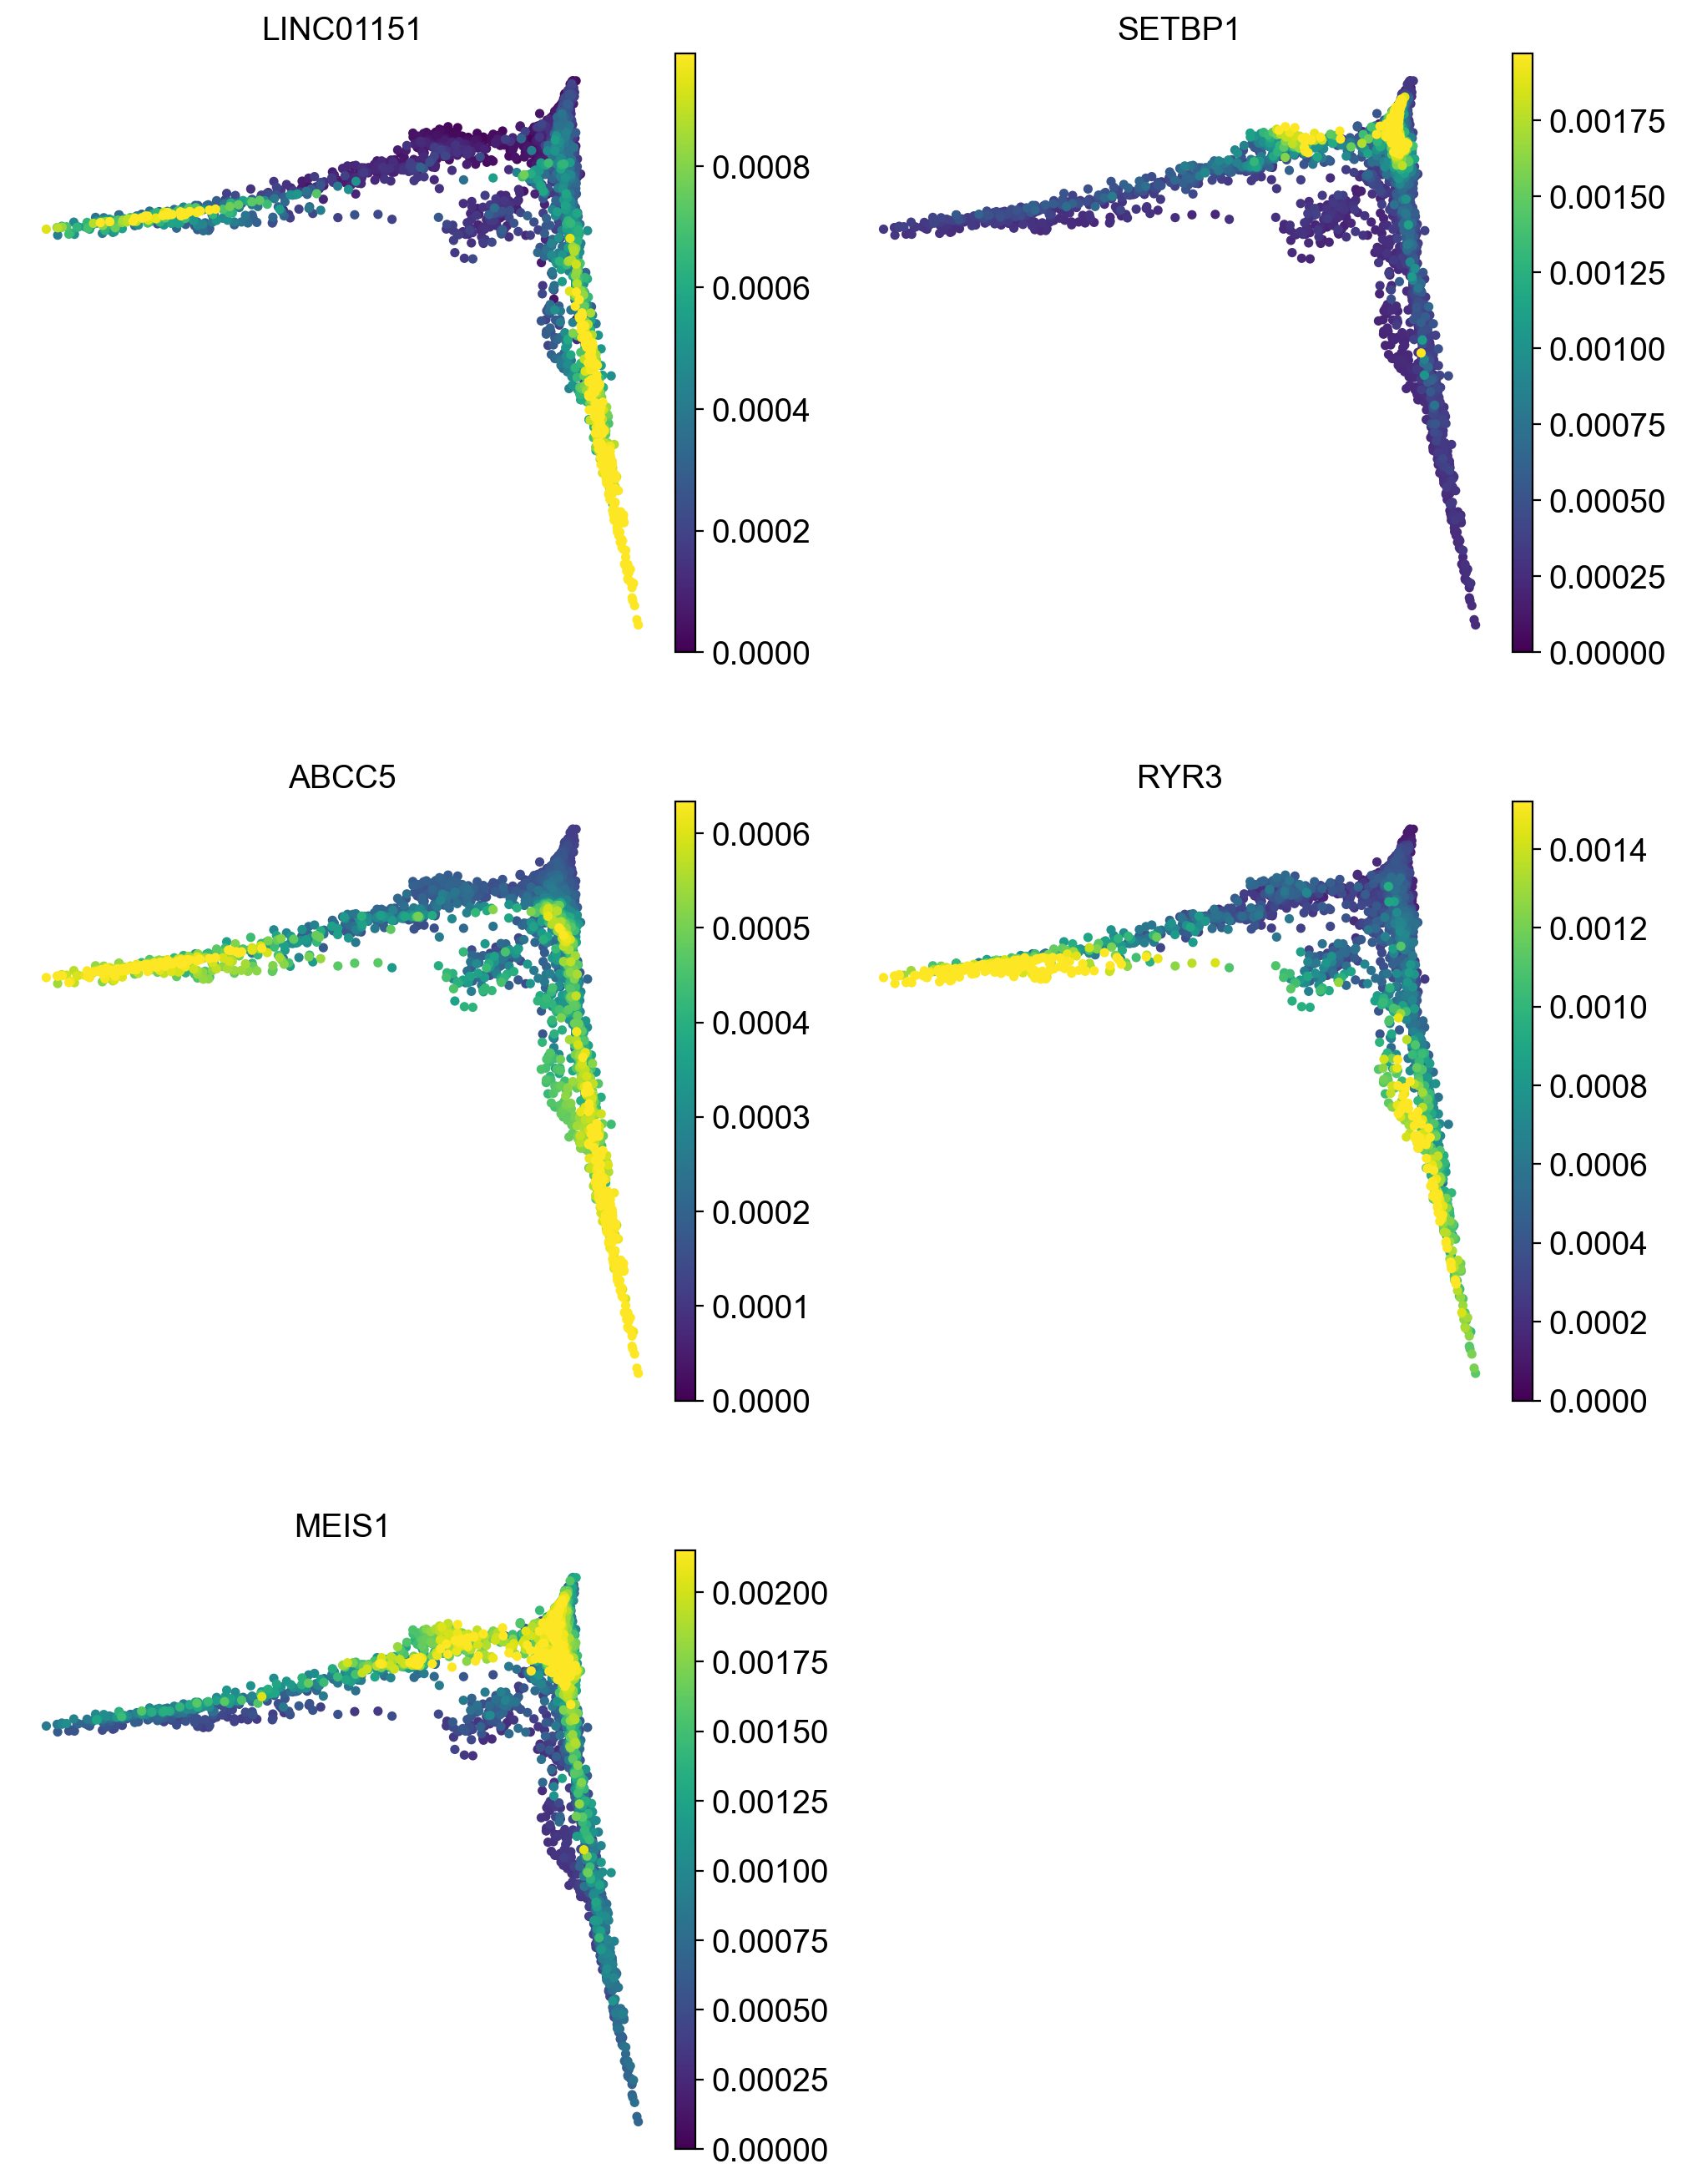

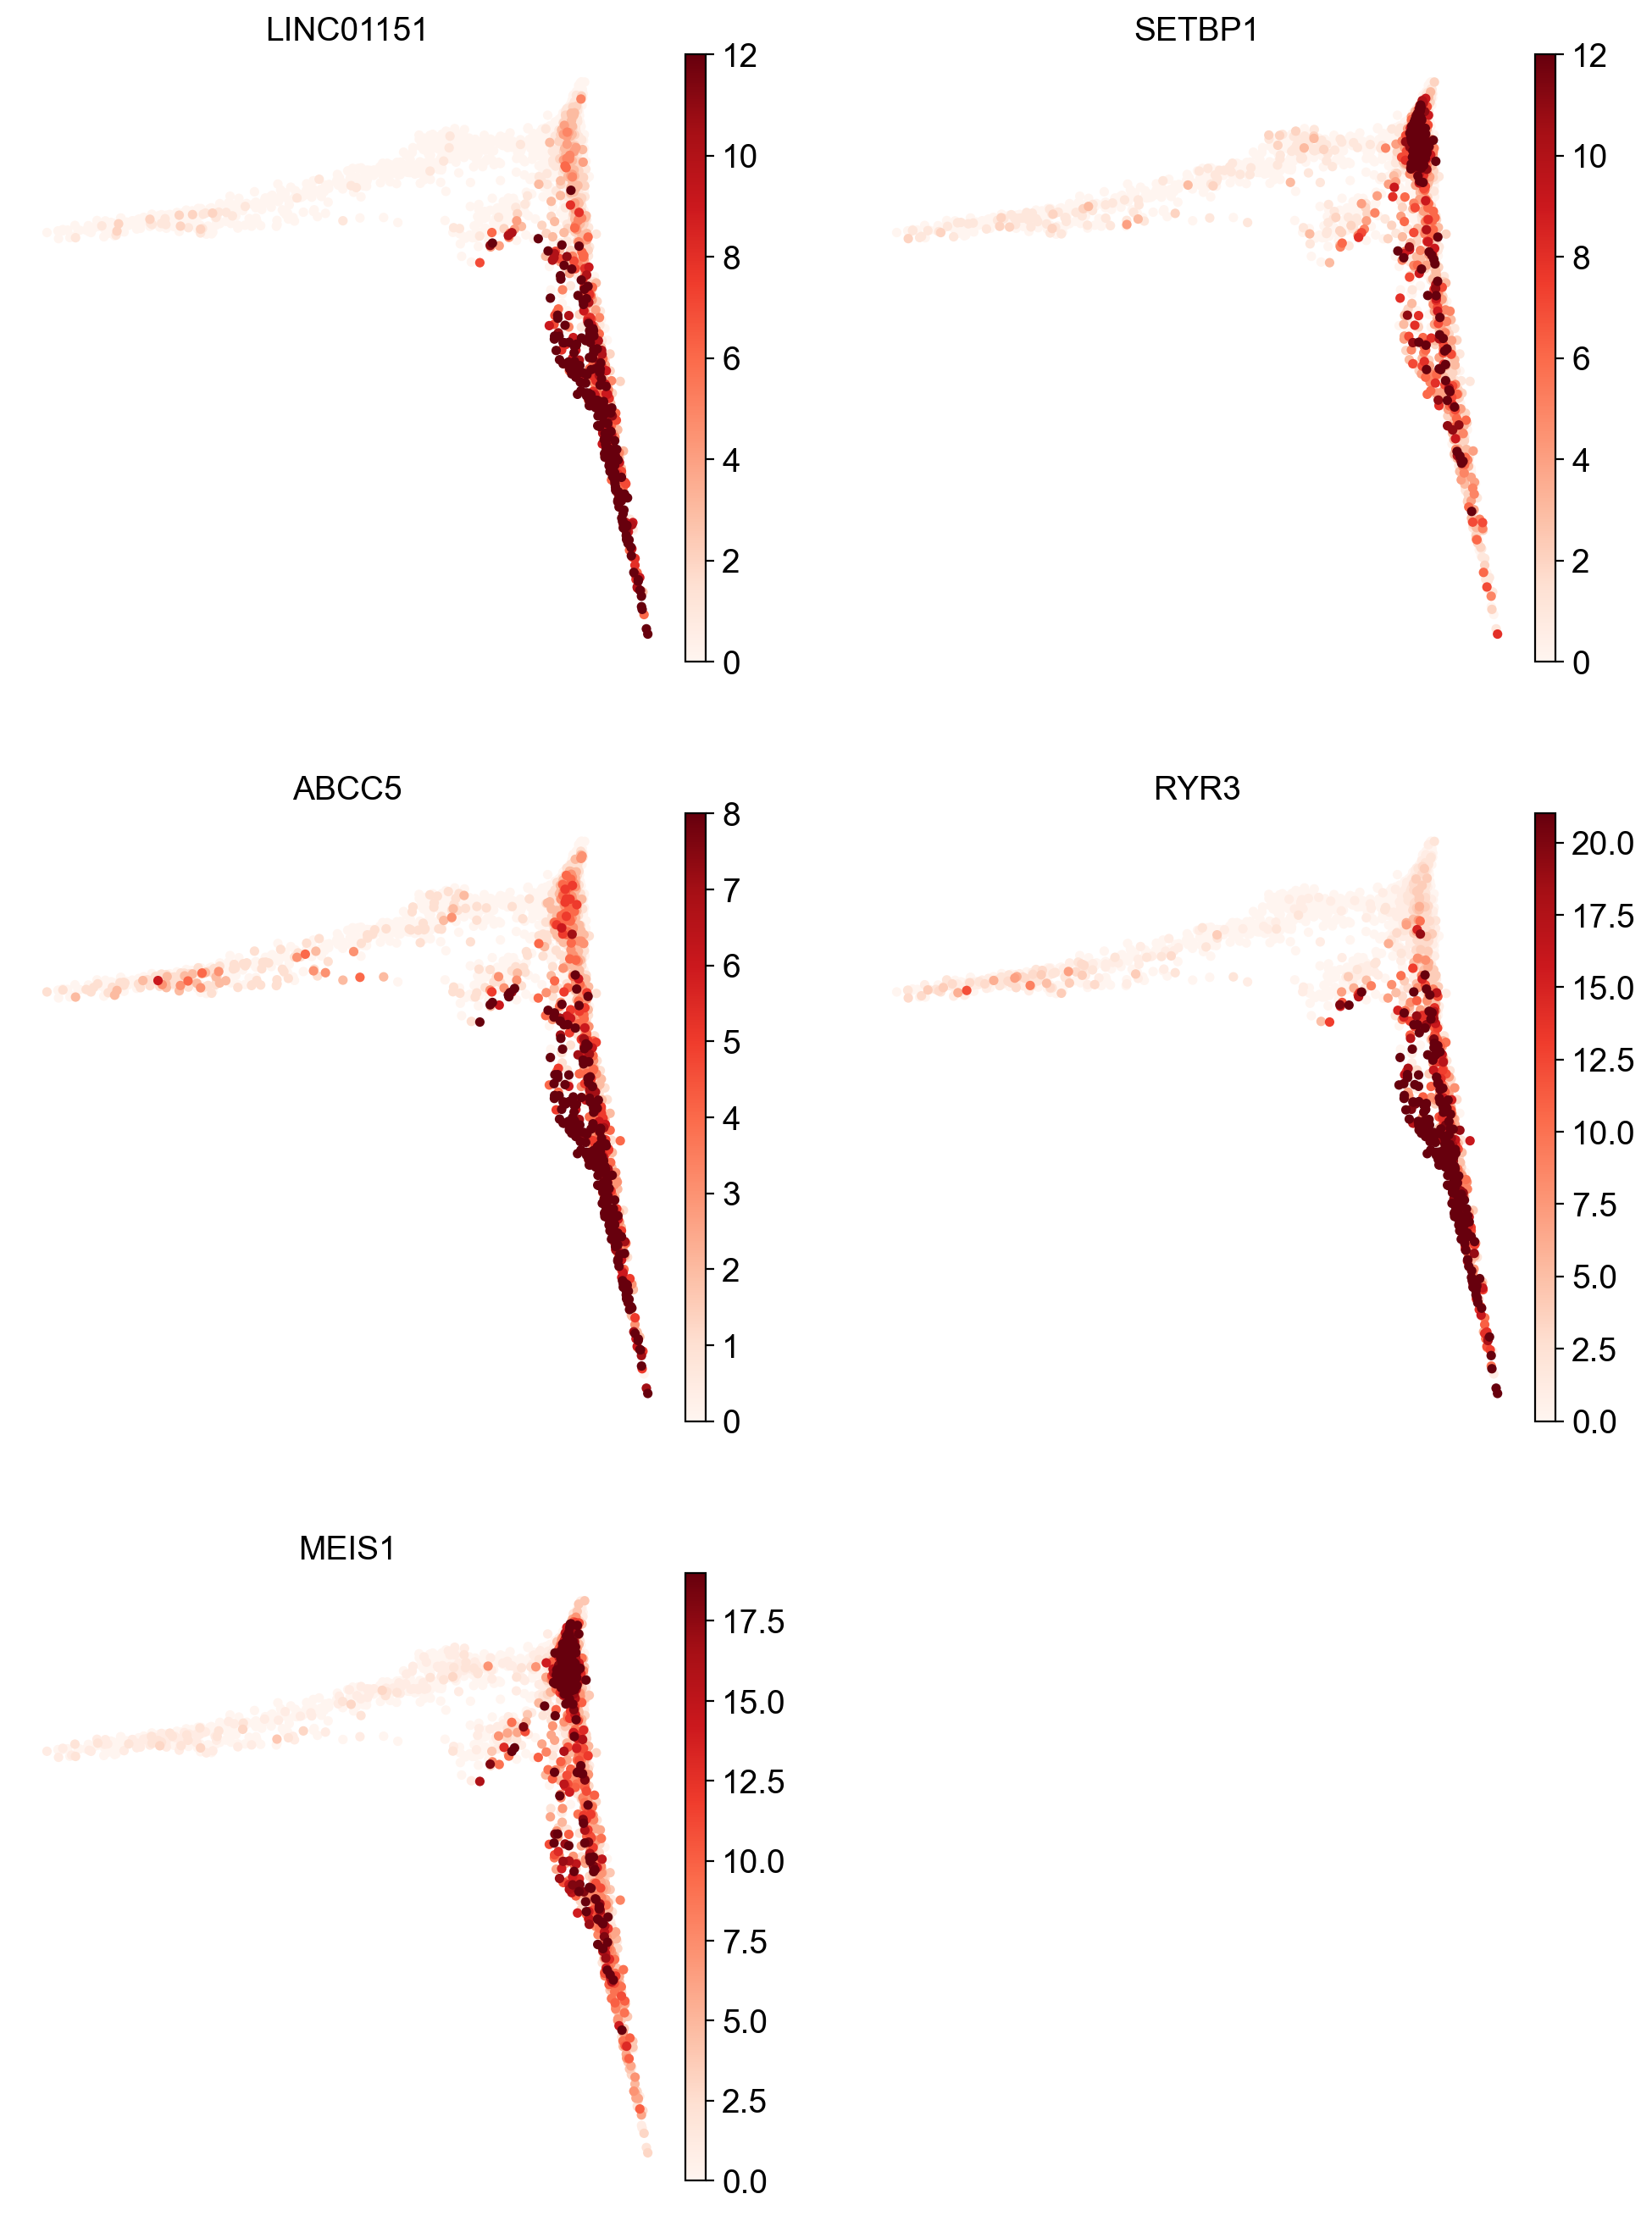

In [55]:
#list the genes associated with GATA family transcription factors
TF = 'GATA1'
df_subset = df_subset.sort_values(by=TF, ascending=False)
TF_list = df_subset[TF].head(5).index

sc.set_figure_params(dpi=200, figsize=(5,5))
#plot the accessibility and expression
sc.pl.umap(rna, color = TF_list, frameon=False, color_map='viridis',size=65,
          layer='LITE_prediction', ncols=2, vmin = 0, vmax = 'p97')
sc.pl.umap(rna, color = TF_list, frameon=False, color_map='Reds',size=65,
          layer='counts', ncols=2, vmin = 0, vmax = 'p97')

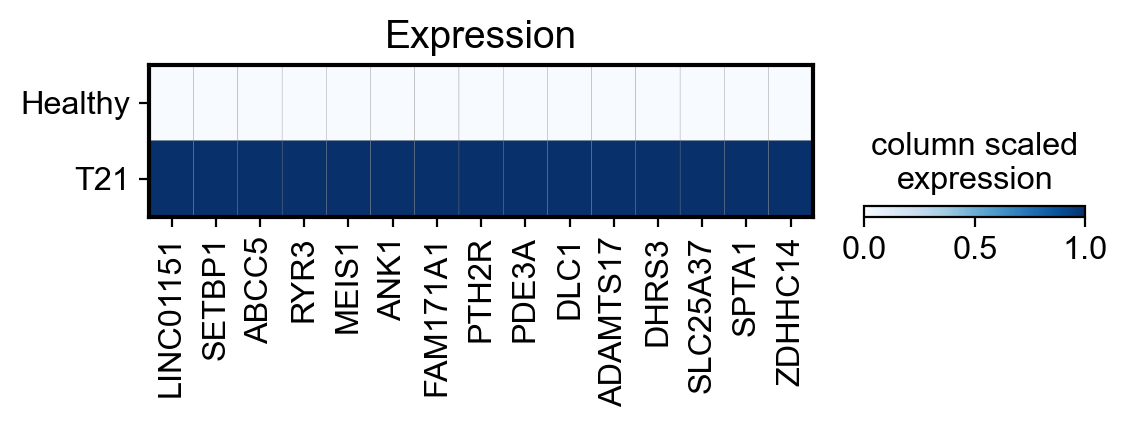

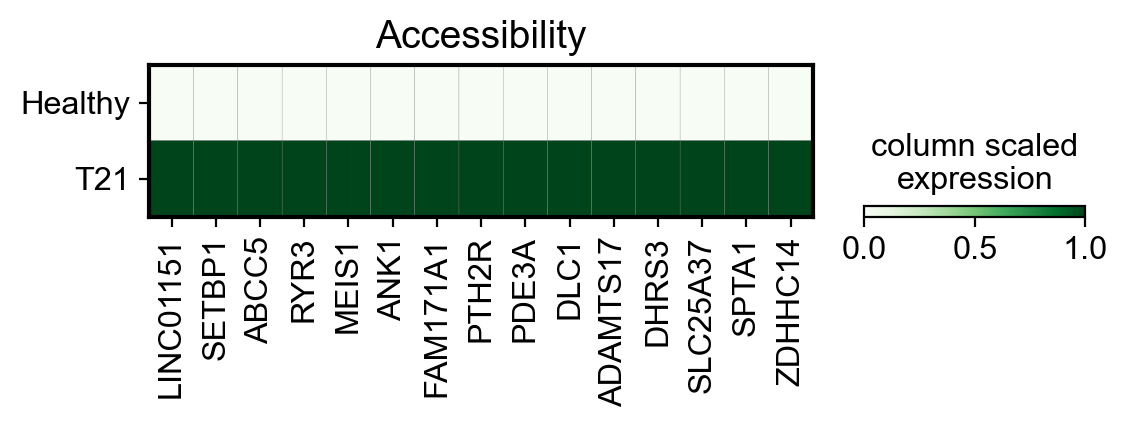

In [54]:
gata_list = ['LINC01151', 'SETBP1', 'ABCC5', 'RYR3', 'MEIS1',
            'ANK1', 'FAM171A1', 'PTH2R', 'PDE3A',
            'DLC1', 'ADAMTS17', 'DHRS3',
             'SLC25A37', 'SPTA1','ZDHHC14'
            ]

sc.pl.matrixplot(rna, gata_list, groupby='sample', layer='X_norm',figsize=(6,1),title='Expression',
                 dendrogram=True, cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')

sc.pl.matrixplot(rna, gata_list, groupby='sample', layer='LITE_prediction',figsize=(6,1),title='Accessibility',
                 dendrogram=True, cmap='Greens', standard_scale='var', colorbar_title='column scaled\nexpression')

In [10]:
#need to import the RNA model again 
model = mira.topics.ExpressionTopicModel.load('Single_Cell/MIRA/RNA_topic_model_HSC_only_T21_healthy.pth')
model.predict(rna)
model

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


Predicting latent vars:   0%|          | 0/13 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


ExpressionTopicModel(
  (decoder): Decoder(
    (beta): Linear(in_features=10, out_features=7905, bias=False)
    (bn): BatchNorm1d(7905, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
  (encoder): ExpressionEncoder(
    (fc_layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=4360, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.14010457382272842, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=22, bias=True)
        (1): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
)

Now we can query with many genes at a time to find potential regulators. The following query finds TF regulators of genes topic 9 which is associated with the T21 specific differentiation arm 


In [11]:
#topic 8 from the RNA model, using the top 150 genes to that topic 
isd_results = mira.tl.driver_TF_test(rna, geneset=model.get_top_genes(8, 150))

pd.DataFrame(isd_results).sort_values('pval').head(15)

INFO:mira.tools.tf_targeting:Testing with 139 query genes and 4311 background genes, against 468 factors


Testing factors:   0%|          | 0/468 [00:00<?, ?it/s]

id         name parsed_name      pval  test_statistic
345  MA0886.1         EMX2        EMX2  0.000226        351049.0
140  MA0704.1         LHX4        LHX4  0.009635        334218.0
31   MA0904.2        HOXB5       HOXB5  0.011744        332729.0
256  MA0755.1         CUX2        CUX2  0.019837        329415.0
388  MA0900.2        HOXA2       HOXA2  0.022057        329008.5
161  MA1463.1        ARGFX       ARGFX  0.025290        328612.0
433  MA0183.1         HHEX        HHEX  0.026950        328293.0
365  MA0661.1        MEOX1       MEOX1  0.028480        327814.5
128  MA0628.1       POU6F1      POU6F1  0.032485        326702.0
369  MA0703.2        LMX1B       LMX1B  0.034586        326554.5
449  MA0075.3        PRRX2       PRRX2  0.055603        323207.0
367  MA0754.1         CUX1        CUX1  0.064904        321555.0
116  MA1498.1        HOXA7       HOXA7  0.077137        320638.0
43   MA0140.2  GATA1::TAL1       GATA1  0.080357        320516.0
338  MA1497.1        HOXA6       HOXA6  0.083379        320086.0

notice the pvalues are not very significant !!


In [12]:
#associated betweeen genes and transcription factors according to binding motifs 
#topic 9 from the RNA model, using the top 150 genes to that topic 
isd_results = mira.tl.driver_TF_test(rna, geneset=model.get_top_genes(9, 150))

pd.DataFrame(isd_results).sort_values('pval').head(15)

INFO:mira.tools.tf_targeting:Testing with 145 query genes and 4305 background genes, against 468 factors


Testing factors:   0%|          | 0/468 [00:00<?, ?it/s]

id         name parsed_name          pval  test_statistic
268  MA0482.2        GATA4       GATA4  4.951808e-20        450390.0
16   MA0036.3        GATA2       GATA2  1.217330e-19        448878.0
459  MA0766.2        GATA5       GATA5  2.073989e-15        431458.0
43   MA0140.2  GATA1::TAL1       GATA1  2.422093e-15        431208.5
309  MA0149.1   EWSR1-FLI1       EWSR1  5.018509e-13        420604.5
315  MA0037.3        GATA3       GATA3  1.633789e-12        417981.0
196  MA1596.1       ZNF460      ZNF460  6.775951e-12        415013.0
76   MA0402.1         SWI5        SWI5  3.601808e-11        411262.0
79   MA1623.1        STAT2       STAT2  9.677477e-11        408985.0
375  MA0493.1         KLF1        KLF1  1.301424e-10        408285.0
227  MA0039.4         KLF4        KLF4  7.460370e-10        404097.0
384  MA0640.2         ELF3        ELF3  8.339534e-10        403824.0
422  MA0035.4        GATA1       GATA1  1.111399e-09        402994.0
120  MA1107.2         KLF9        KLF9  1.452905e-09        402448.0
221  MA0065.2  PPARG::RXRA       PPARG  2.433644e-09        401149.0

INFO:mira.tools.tf_targeting:Testing with 145 query genes and 4305 background genes, against 468 factors


Testing factors:   0%|          | 0/468 [00:00<?, ?it/s]

INFO:mira.tools.tf_targeting:Testing with 139 query genes and 4311 background genes, against 468 factors


Testing factors:   0%|          | 0/468 [00:00<?, ?it/s]

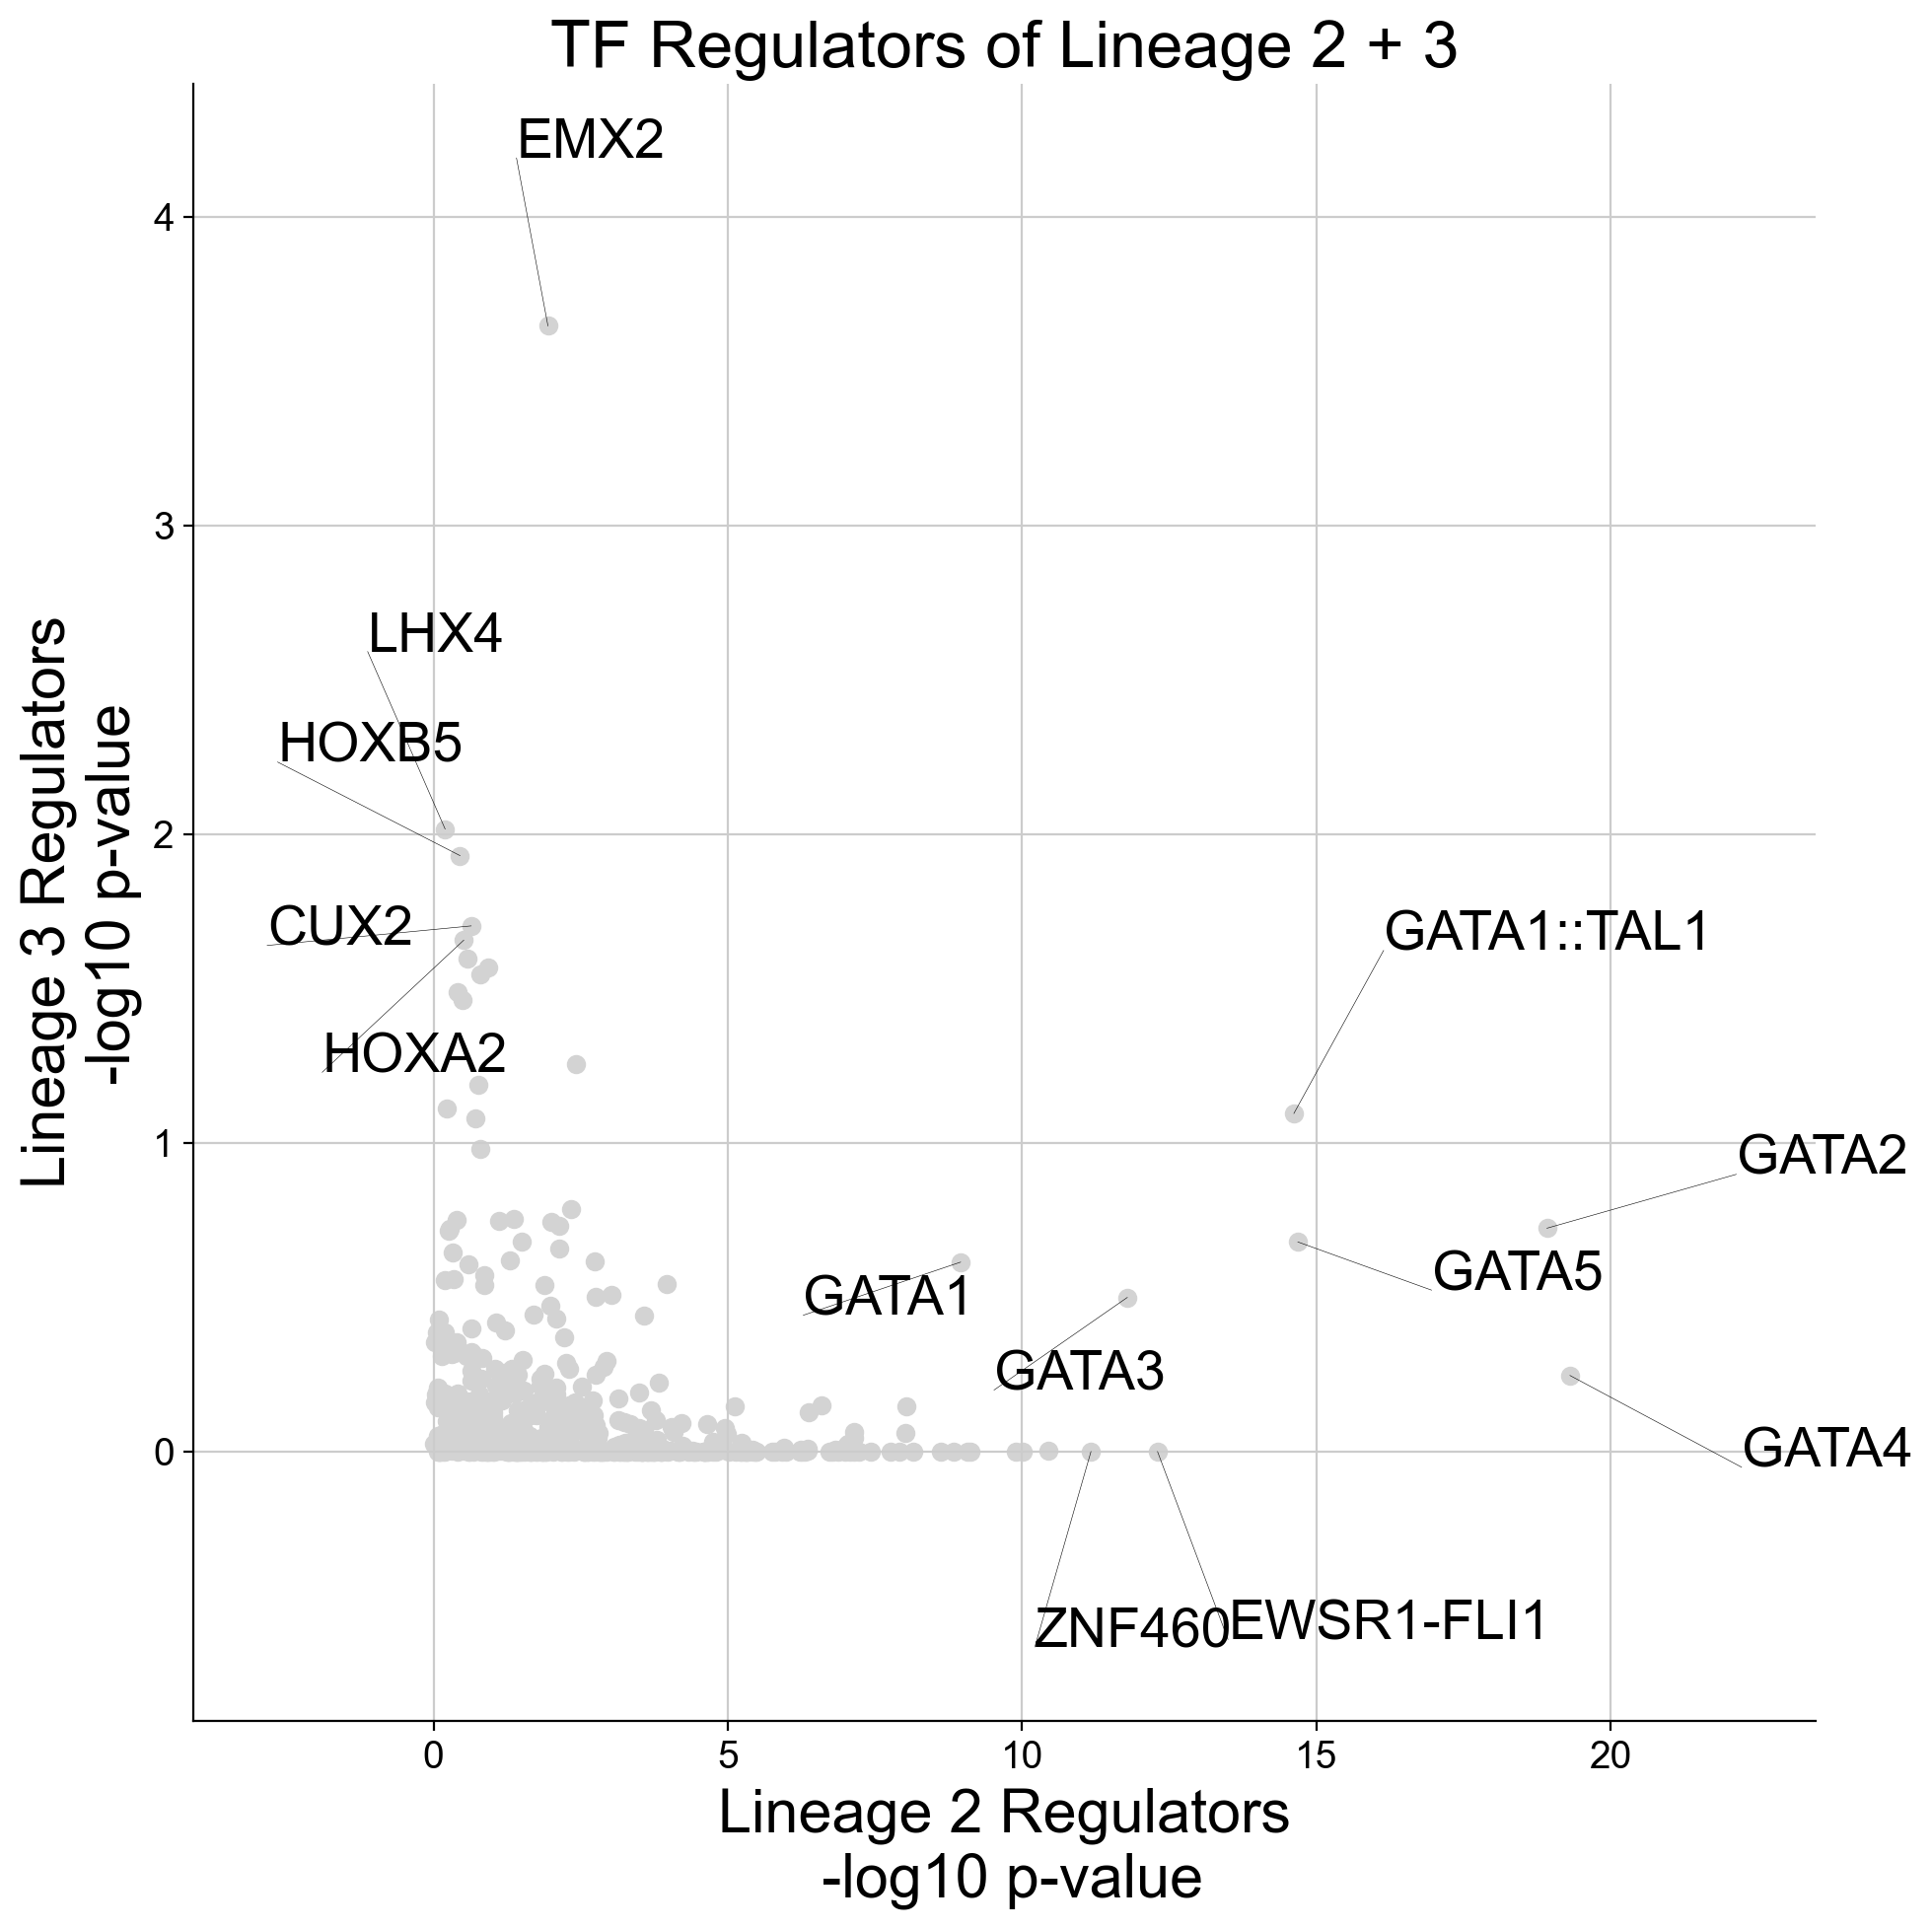

In [13]:
mira.pl.compare_driver_TFs_plot(rna,
                                geneset1=model.get_top_genes(9, 150),
                                geneset2=model.get_top_genes(8, 150),
                                label_factors=['GATA4','GATA2','GATA5','GATA1','GATA3','HOXB5','EWSR1-FLI1',
                                               'GATA1::TAL1','ZNF460','EMX2','LHX4','CUX2','HOXA2'],
                                fontsize=20, figsize=(10,10), color='lightgrey',
                                )
plt.title('TF Regulators of Lineage 2 + 3', fontsize=24)
plt.xlabel('Lineage 2 Regulators\n -log10 p-value', fontsize=22)
plt.ylabel('Lineage 3 Regulators\n -log10 p-value', fontsize=22)
plt.tight_layout()
plt.savefig('Single_Cell/MIRA/figures/pISD_TF_regualtors_diferentiation_arms.png', dpi=300)
plt.show()